In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../model')
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os
from tqdm import tqdm
from plotting import *
import h5py
from functions import *

In [2]:
# load_dir = '/Users/jo/notebooks_paper/run_data/2024-02-05/Untitled/18:37'
# pre_trial = False
load_dir = '/Users/jo/notebooks_paper/run_data/best/'
pre_trial = True

In [3]:
def partition_trials(arr, t_axis=1):
    arr_trial = np.array_split(arr, arr.shape[t_axis]//Conf.trial_len, axis=t_axis)
    arr_trial = np.stack(arr_trial, axis=1)
    return arr_trial

def partition_all(arrs, pre_trial, t_axis=1):
    offset=0 if not pre_trial else 2
    return [partition_trials(arr[:, offset:, :], t_axis=t_axis) for arr in arrs]

def argmax_all(arrs, onehot_axis=-1):
    return [np.argmax(arr, axis=onehot_axis) for arr in arrs]

def unpack_data_dict(data_dict):
    return data_dict['inputs'], data_dict['targets'], data_dict['choices'], data_dict['ground_truth'], data_dict['p_A_high'], data_dict['hidden']

def detect_anomalies(thresholds = Conf.threshold):
    # thresholds = 4.99
    if thresholds is not None:
        thresholds = thresholds - 0.01
        anomaly = hidden_trial > thresholds
        return np.any(anomaly, axis=(1,2,3))
    else:
        return []

In [4]:
def list_all_datasets(h5file, prefix=''):
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path} {item.shape}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data_test.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)

    # Load the data
    n_chunks = 1
    means, bin_counts = [], []

    data_dict = {}
    for key in file.keys():
        data_dict[key] = file[key][:]

    inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
    print([x.shape for x in [inputs, targets, choices, ground_truth, p_A, hiddens]])
    
    inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens], pre_trial=pre_trial)
    print([x.shape for x in [inputs_trial, choices_trial, targets_trial, hidden_trial]])

    # del inputs, targets, ground_truth
    # del inputs_trial, choices_trial, targets_trial, hidden_trial

    # if Conf.pre_trial:
    #     x_arg_trial = np.argmax(inputs[:,:2,:Conf.x_dim], axis=-1)
    #     print(x_arg_trial.shape)
    # else:
    #     raise NotImplementedError
    #     x_arg_trial = np.argmax(inputs_trial[:,:Conf.x_dim,:], axis=-1)[:,0,:]
    # x_arg_trial = np.repeat(x_arg_trial[:, np.newaxis, :], inputs_trial.shape[1], axis=1)
    # print(x_arg_trial.shape)

    if pre_trial:
        layouts = np.argmax(inputs[:,:2,:Conf.x_dim], axis=-1)
    else:
        layouts = np.argmax(inputs_trial[:,0,1:3,:Conf.x_dim], axis=-1)
    # anomalous_batches = []
    # mean, bin_count = get_means(p_A, x_arg_trial, hidden_trial, anomalous_batches, n_p_bins=20 if Conf.reward_prob == 0.8 else 2)

if Conf.pre_trial: 
    hiddens = hiddens[:, 2:, :]
    targets = targets[:, 2:, :]
    choices = choices[:, 2:, :]
    inputs = inputs[:, 2:, :]
    ground_truth = ground_truth[:, 2:, :]

['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
Dataset: /choices (10000, 82, 404)
Dataset: /ground_truth (10000, 82, 404)
Dataset: /hidden (10000, 82, 1024)
Dataset: /inputs (10000, 82, 404)
Dataset: /p_A_high (10000, 40, 1)
Dataset: /targets (10000, 82, 404)
[(10000, 82, 404), (10000, 82, 404), (10000, 82, 404), (10000, 82, 404), (10000, 40, 1), (10000, 82, 1024)]
[(10000, 40, 2, 404), (10000, 40, 2, 404), (10000, 40, 2, 404), (10000, 40, 2, 1024)]


In [5]:
# def list_all_datasets(h5file, prefix=''):
#     print('here')
#     print([k for k in h5file.keys()])
#     for key in h5file.keys():
#         item = h5file[key]
#         path = f"{prefix}/{key}"
#         if isinstance(item, h5py.Dataset):
#             # This is a dataset
#         elif isinstance(item, h5py.Group):
#             # This is a group, recurse into it
#             list_all_datasets(item, path)

# with h5py.File(os.path.join(load_dir, 'data_train.h5'), 'r') as file:
#     # Access the dataset
#     list_all_datasets(file)
#     print([k for k in file.keys()])

#     # Determine chunk size
#     num_trials_test = 40 # Conf.num_trials_test
#     chunk_size_trial = 40
#     chunk_size_t = num_trials_test * Conf.trial_len
#     # n_chunks = Conf.num_epochs_test  
#     lens = []
#     for key in file.keys():
#         lens.append(file[key].shape[1])
#         print(key, file[key].shape[1])
#     lens = np.unique(lens)
#     n_chunks = np.min(lens) // chunk_size_trial
#     # Read and process in chunks
#     print('n_chunks:', n_chunks)
#     means, bin_counts = [], []
#     for i in range(0, n_chunks):
#         # Read a chunk
#         data_dict = {}
#         for key in file.keys():
#             item = file[key]
#             chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

#             slices = [slice(None)] * len(item.shape)
#             # Replace the slice in the specified axis with the new range
#             start = i * chunk_size
#             slices[1] = slice(start, start + chunk_size)
#             slices = tuple(slices)
#             data_dict[key] = item[slices]

#         inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
#         print([x.shape for x in [inputs, choices, targets, hiddens]])
#         inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
#         print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

#         # inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
#         # print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

#         # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

#         if i == 0:
#             x_arg_trial = np.argmax(inputs_trial[:,:Conf.x_dim,:], axis=-1)[:,0,:]
#             x_arg_trial = np.repeat(x_arg_trial[:, np.newaxis, :], inputs_trial.shape[1], axis=1)

#         anomalous_batches = detect_anomalies()
#         mean, bin_count = get_means(p_A, x_arg_trial, hidden_trial, anomalous_batches, n_p_bins=20 if Conf.reward_prob == 0.8 else 2)
#         means.append(mean)
#         bin_counts.append(bin_count)
#         # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

In [6]:
del inputs_trial, choices_trial, targets_trial, hidden_trial, ground_truth

In [7]:
anomalous_idxs, non_anomalous_idxs = get_anomalous_batches(choices)

# anomalous: 117
# non-anomalous: 9883


In [8]:
action = choices[:,:,Conf.x_dim + Conf.r_dim:][:, Conf.ab_choice_step::Conf.trial_len]
# Turn action array into 1's if element in row equals max in row
action = np.argmax(action, axis=-1)
# Repeat choice for each of the trial steps
action = np.repeat(action, Conf.trial_len, axis=1)

not_action = swap_unique_elements(action, layouts)

In [53]:
# action_train, action_test, hiddens_train, hiddens_test, _, _, = train_test_split_layouts([action, hiddens, layouts], layouts)
hiddens_train, hiddens_test, action_train, action_test  = train_test_split_layouts(layouts, hiddens, action, test_size=0.2, random_state=42)


Using custom train/test split
Shapes: [(4842, 80, 1024), (898, 80, 1024), (4842, 80), (898, 80)]


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

random_state = 0
iters = 20000
N = 5
plt.figure()

accs_train = np.zeros((2, N))
accs_test = np.zeros((2, N))
losses_train = np.zeros((2, N))
losses_test = np.zeros((2, N))

for i in tqdm(range(N)):
    X = hiddens__[:,2+i,:].copy()
    y = action[:,2+i].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    for j, scale in enumerate([False, True]):
        if scale:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        model = LogisticRegression(solver='lbfgs', class_weight='balanced', multi_class='ovr', random_state=0, max_iter=iters)
        model.fit(X_train_scaled, y_train)

        accs_train[j,i] = model.score(X_train_scaled, y_train)
        accs_test[j,i] = model.score(X_test_scaled, y_test)

        p_train = model.predict_log_proba(X_train_scaled)
        idxs = (np.arange(p_train.shape[0]), y_train)
        losses_train[j,i] = np.mean(p_train[idxs])

        p_test = model.predict_log_proba(X_test_scaled)
        idxs = (np.arange(p_test.shape[0]), y_test)
        losses_test[j,i] = np.mean(p_test[idxs])



  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'hiddens__' is not defined

<Figure size 640x480 with 0 Axes>

In [13]:
X_train, X_test, y_train, y_test, layouts_train, layouts_test = train_test_split(hiddens__, action, layouts, test_size=0.2, random_state=40)

NameError: name 'hiddens__' is not defined

In [14]:
X_train.shape

NameError: name 'X_train' is not defined

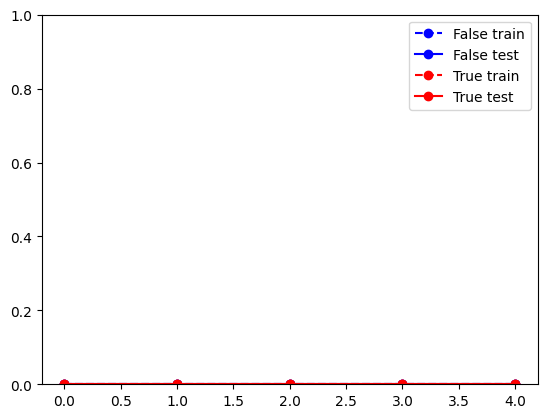

In [15]:
plt.figure()
cols = ['b', 'r']
for i, scale in enumerate([False, True]):
    plt.plot(accs_train[i,:], marker='o', linestyle='--', color=cols[i], label=str(scale) + ' train')
    plt.plot(accs_test[i,:], marker='o', color=cols[i], label=str(scale) + ' test')
# plt.ylim(0, 1)
plt.ylim(0,1)
plt.legend()

In [ ]:
plt.figure()
cols = ['b', 'r']
for i, scale in enumerate([False, True]):
    plt.plot(losses_train[i,:], marker='o', linestyle='--', color=cols[i], label=str(scale) + ' train')
    plt.plot(losses_test[i,:], marker='o', color=cols[i], label=str(scale) + ' test')
# plt.ylim(0, 1)
plt.ylim(top=0)
plt.legend()

In [9]:
accuracies_action, _, chance, _ = train_decoders(hiddens, targets=action, layouts=layouts, exclude_batch_idxs=None, T=20, multi_class='ovr', max_iter=1000, random_state=42)

Using multiclass: True


/Users/jo/notebooks_paper/analysis/decoder/functions.py:242: RuntimeWarning: invalid value encountered in divide
  hiddens_train_scaled = (hiddens_train - mean) / std
/Users/jo/notebooks_paper/analysis/decoder/functions.py:243: RuntimeWarning: divide by zero encountered in divide
  hiddens_test_scaled = (hiddens_test - mean) / std
/Users/jo/notebooks_paper/analysis/decoder/functions.py:243: RuntimeWarning: invalid value encountered in divide
  hiddens_test_scaled = (hiddens_test - mean) / std
  0%|          | 0/20 [00:00<?, ?it/s]/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

KeyboardInterrupt: 

In [ ]:
getsizeof(hiddens) / 1e6

In [ ]:
plot_decoding_accuracy(accuracies_action, chance=chance, n_class=Conf.port_dim, title='Port choice decoding')

In [ ]:
accuracies_action, _, chance, _ = train_decoders(hiddens, targets=action, layouts=layouts, exclude_batch_idxs=None, T=20, multi_class='ovr', max_iter=10000, random_state=41)

In [ ]:
plot_decoding_accuracy(accuracies_action, chance=chance, n_class=Conf.port_dim, title='Port choice decoding')

In [ ]:
accuracies_not_action, conf_matrices_not_action, chance_not_action, data = train_decoders(hiddens, targets=not_action, layouts=layouts, exclude_batch_idxs=None, T=20, multi_class='ovr', max_iter=200, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_not_action, n_class=Conf.port_dim, title='Port non-choice decoding')

In [ ]:
n_p_bins = 50
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins

fig, axes = plt.subplots(5,8)
for i,ax in enumerate(axes.flatten()):
    bins = np.digitize(p_A[:,i,:], bin_edges).squeeze()
    counts = np.bincount(bins.flatten(), minlength=n_p_bins)
    print(bin_edges.shape, counts.shape)

    ax.bar(bin_edges - 0.5 / n_p_bins, counts, width=np.diff(bin_edges, prepend=0), align='edge', capsize=2)

In [ ]:
n_p_bins = 50
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
print(bins.shape, hiddens.shape)
accuracies_p_bins, conf_matrices_p_bins, chance_p_bins, data = train_decoders(hiddens[:, 2:, :], targets=bins, layouts=layouts, n_class=n_p_bins, exclude_batch_idxs=non_anomalous_idxs, T=40, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_p_bins, chance=chance_p_bins, n_class=n_p_bins, title='p(A) decoding')

In [ ]:
plot_conf_matrices(conf_matrices_p_bins, bins, n_p_bins, bin_edges, mask_type='all')

In [ ]:
n_p_bins = 4
bin_edges = np.array([0.2, 0.5, 0.8, 1.0]) #np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
accuracies_p_bins, conf_matrices_p_bins, chance, data = train_decoders(hiddens, targets=bins, layouts=layouts, n_class=n_p_bins, exclude_batch_idxs=non_anomalous_idxs, T=40, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_p_bins, chance=None, n_class=n_p_bins, title='p(A) decoding')

In [ ]:
plot_conf_matrices(conf_matrices_p_bins, bins, n_p_bins, bin_edges, mask_type='step')

In [ ]:
N_step = 40

hiddens_flatten = hiddens[:, :N_step, :].reshape(-1, 1, hiddens.shape[-1])
t_step = np.broadcast_to(np.arange(N_step), (hiddens.shape[0], N_step))
t_step_flatten = t_step.flatten()
layouts_flatten = np.repeat(layouts, hiddens_flatten.shape[0] // hiddens.shape[0], axis=0)
print(hiddens_flatten.shape)
print(t_step_flatten.shape)
print(layouts_flatten.shape)

accuracies_t_step, conf_matrices_t_step, chance, _ = train_decoders(hiddens_flatten, targets=t_step_flatten, layouts=layouts_flatten, T=40, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy(accuracies_p_good, n_class=2, title='p(A) decoding')

In [105]:
def train_test_split_layouts_(layouts, *arrs, **kwargs):
    print('Using custom train/test split')
    test_size = kwargs['test_size'] / 2 if 'test_size' in kwargs else 0.2
    np.random.seed(kwargs['random_state'] if 'random' in kwargs else None)

    return_arrs = []
    # exclude_port_set = np.random.choice(np.arange(Conf.port_dim), size=(int(Conf.port_dim*test_size)), replace=False)
    exclude_port_set = np.arange(60)
    truth_array = np.isin(layouts, exclude_port_set)
    exclude_batch_idxs = np.all(truth_array, axis=1)
    include_batch_idxs = np.any(truth_array, axis=1) == False

    layouts_train, layouts_test = layouts[include_batch_idxs], layouts[exclude_batch_idxs]

    for arr in arrs:
        train_arr, test_arr = arr[include_batch_idxs], arr[exclude_batch_idxs]
        return_arrs += [train_arr, test_arr]

    print('Shapes: {}'.format([x.shape for x in return_arrs]))

    # if np.isin(layouts_train, exclude_port_set).any():
    #     raise ValueError(f'Port found in training set')
    
    # if not np.any(np.isin(layouts_test, exclude_port_set), axis=1).all():
    #     raise ValueError(f'Port not found in testing set')

    return tuple(return_arrs)

action_train, action_test, hiddens_train, hiddens_test, layouts_train, layouts_test = train_test_split_layouts_(layouts, action, hiddens, layouts, test_size=0.2, random_state=42)

Using custom train/test split
Shapes: [(4842, 80), (898, 80), (4842, 80, 1024), (898, 80, 1024), (4842, 2), (898, 2)]


In [110]:
layouts_test[:40,:]

array([[ 4, 30],
       [ 4, 53],
       [38, 44],
       [49, 40],
       [40, 59],
       [21, 57],
       [ 7, 27],
       [39,  8],
       [50, 11],
       [58, 19],
       [44, 20],
       [ 3, 24],
       [52, 13],
       [24,  8],
       [36,  2],
       [ 1, 28],
       [27, 15],
       [52,  9],
       [14, 21],
       [40, 59],
       [30,  1],
       [32, 28],
       [ 5,  6],
       [ 6, 36],
       [22, 29],
       [20, 30],
       [56, 41],
       [27, 12],
       [55, 34],
       [ 9, 32],
       [ 9, 18],
       [ 6, 40],
       [15, 39],
       [43, 30],
       [ 4, 55],
       [51,  7],
       [31, 30],
       [35, 44],
       [ 6, 54],
       [34, 40]])

## Cross-step decoding

### Port choice

In [12]:
import numpy as np
step = np.ones_like(action, dtype=np.int64)
step[:, ::2] = 0

def double_up_arr(arr):
    shape = np.array(arr.shape)
    shape[0] *= 2
    shape[1] //= 2
    print(shape)
    new_arr = np.zeros(shape, dtype=arr.dtype)

    new_arr[::2,:] = arr[:, ::2]
    new_arr[1::2,:] = arr[:, 1::2]
    
    return new_arr

step_double = double_up_arr(step)
hiddens_double = double_up_arr(hiddens)
layouts_double = layouts.repeat(2, axis=0)

[20000    40]
[20000    40  1024]


In [23]:
train_steps = [10]
scale = False
fold = False
accs, conf_mats, losses_train, losses_test = train_decoders_looped(hiddens_double, step_double, layouts_double, train_steps=train_steps, T=None, fold_trials=fold, 
                                                                   scale=scale, exclude_batch_idxs=None, 
                                                                   by_port=True, n_class=Conf.port_dim, multi_class='ovr', 
                                                                   max_iter=1000, random_state=42)

Using custom train/test split
Shapes: [(9684, 40, 1024), (1796, 40, 1024), (9684, 40), (1796, 40)]
Finished scaling.
Train/test:	(9684, 40, 1024),	(1796, 40, 1024)
Folded:		(9684, 1, 1024)


100%|██████████| 40/40 [00:01<00:00, 25.51it/s]


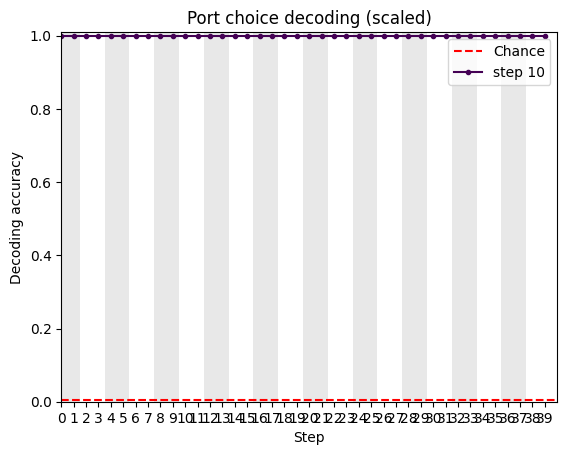

In [24]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, title='Port choice decoding (scaled)')
fig = plt.gcf()
# fig.savefig('./figs/full/choice_fold.png', dpi=300)

In [39]:
A_choice = (action == layouts[:,0][:, np.newaxis]).astype(np.int64)

train_steps = [40,41]
scale = False
fold = False
accs, conf_mats, losses_train, losses_test = train_decoders_looped(hiddens, A_choice, layouts, train_steps=train_steps, T=None, fold_trials=fold, 
                                                                   scale=scale, exclude_batch_idxs=None, 
                                                                   by_port=False, n_class=Conf.port_dim, multi_class='ovr', 
                                                                   max_iter=1000, random_state=42)

(10000, 80, 1024) (10000, 80)
Finished scaling.
Train/test:	(8000, 80, 1024),	(2000, 80, 1024)
Folded:		(8000, 2, 1024)


100%|██████████| 80/80 [00:02<00:00, 39.22it/s]


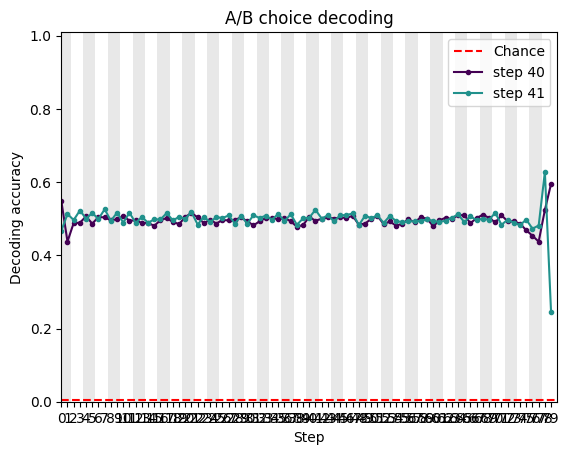

In [40]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, title='A/B choice decoding')
fig = plt.gcf()
# fig.savefig('./figs/full/choice_fold.png', dpi=300)

In [61]:
n_p_bins = 10
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)

action_p = action * n_p_bins + bins

train_steps = np.arange(40, 78)
scale = False
fold = False
accs, conf_mats, losses_train, losses_test = train_decoders_looped(hiddens, action_p, layouts, train_steps=train_steps, T=None, fold_trials=fold, 
                                                                   scale=scale, exclude_batch_idxs=None, 
                                                                   by_port=False, n_class=Conf.port_dim * n_p_bins, multi_class='ovr', 
                                                                   max_iter=1000, random_state=42)

(10000, 80, 1024) (10000, 80)
Finished scaling.
Train/test:	(8000, 80, 1024),	(2000, 80, 1024)
Folded:		(8000, 38, 1024)


 85%|████████▌ | 68/80 [00:34<00:06,  1.98it/s]

: 

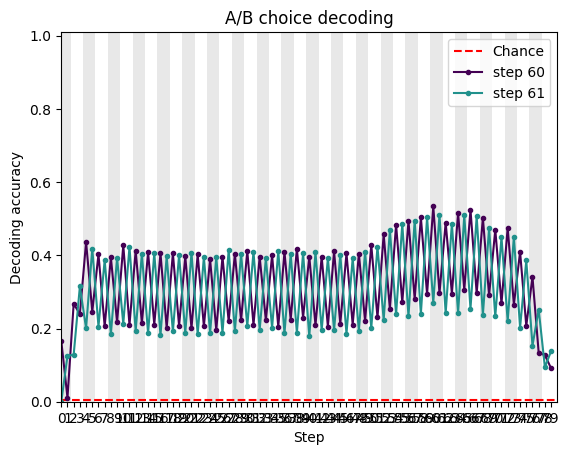

In [59]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, title='A/B choice decoding')
fig = plt.gcf()
# fig.savefig('./figs/full/choice_fold.png', dpi=300)

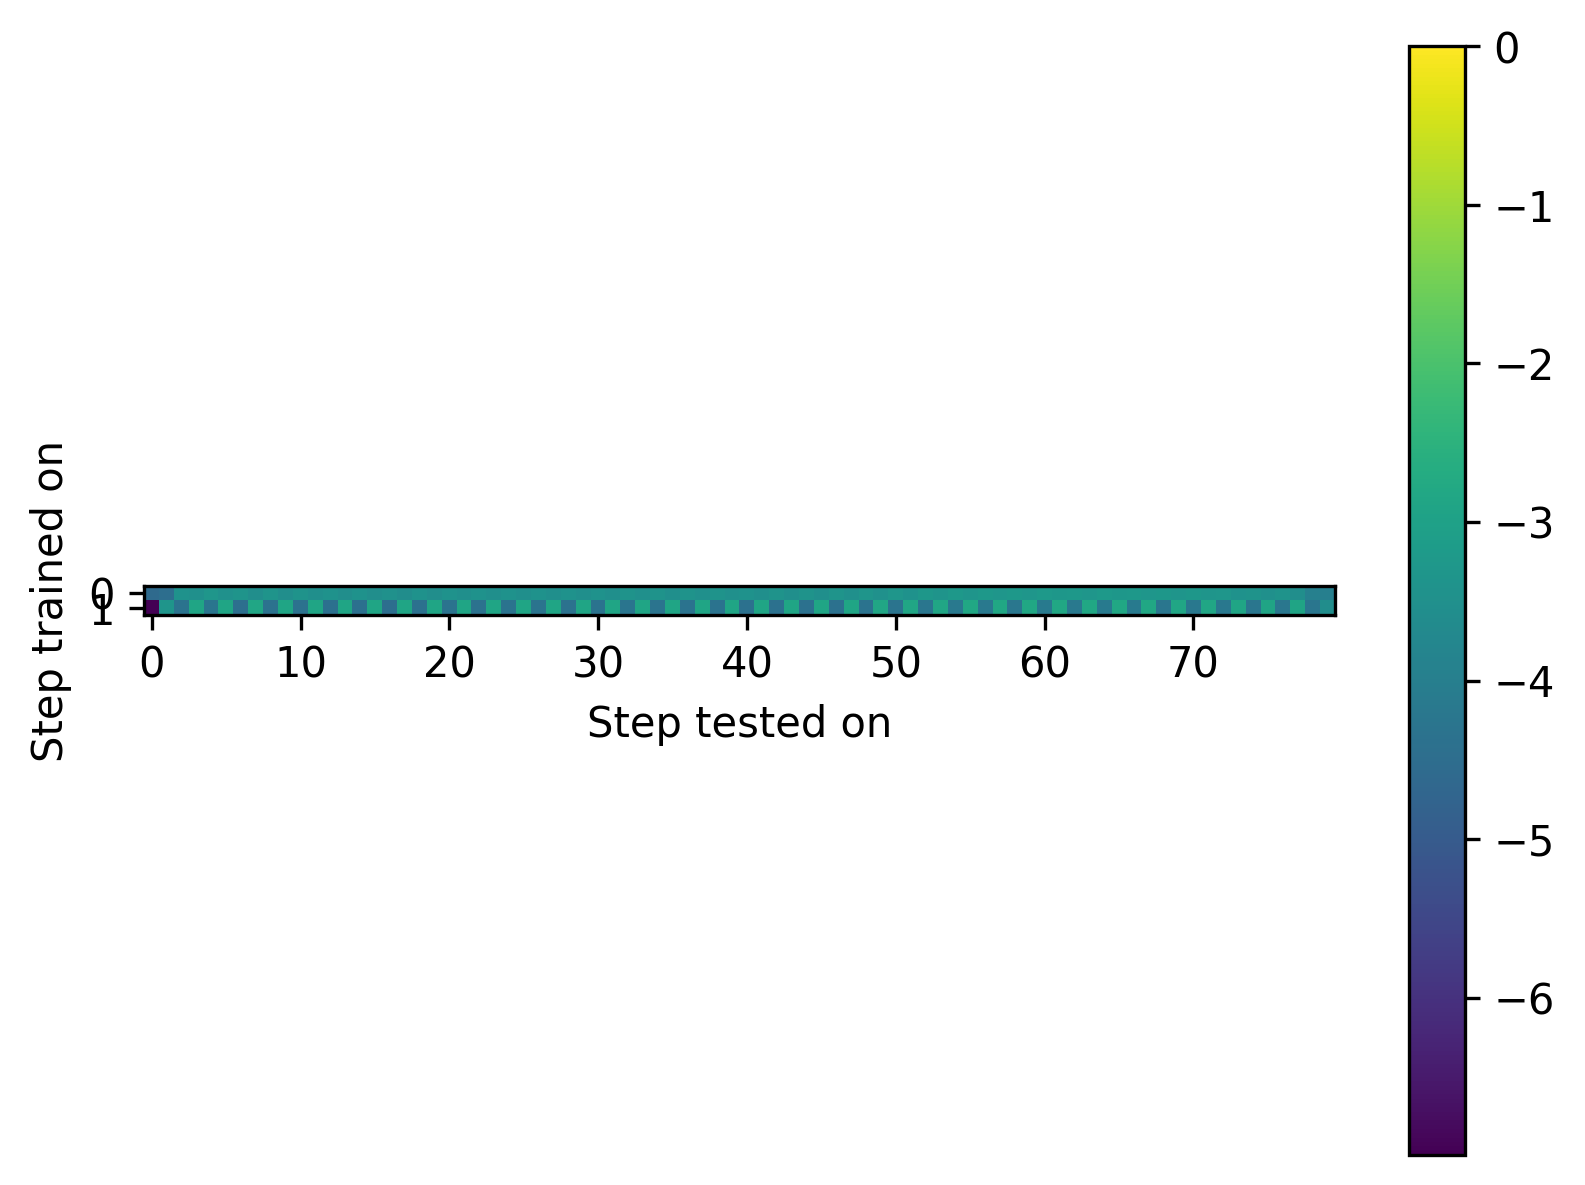

In [60]:
plt.figure(dpi=300)
plt.imshow(np.array(losses_test), vmax=0)
plt.xlabel('Step tested on')
plt.xticks(np.arange(0, 80, 10), np.arange(0, 80, 10))
# plt.yticks(np.arange(len(train_steps))[10::10]-train_steps[0], np.arange(len(train_steps))[10::10])
plt.ylabel('Step trained on')
plt.colorbar()
# plt.savefig('./figs/full/choice_accs_mat.png', dpi=300)

#### Scaled

In [10]:
from functions import *

In [26]:
train_steps = np.arange(2,20)
scale = True
fold = False
accs, conf_mats, losses_train, losses_test = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=None, fold_trials=fold, 
                                                                   scale=scale, exclude_batch_idxs=None, 
                                                                   by_port=False, n_class=Conf.port_dim, multi_class='ovr', 
                                                                   max_iter=1000, random_state=42)

/Users/jo/notebooks_paper/analysis/decoder/functions.py:426: RuntimeWarning: invalid value encountered in divide
  hiddens_train_scaled = (hiddens_train - mean) / std
/Users/jo/notebooks_paper/analysis/decoder/functions.py:427: RuntimeWarning: divide by zero encountered in divide
  hiddens_test_scaled = (hiddens_test - mean) / std
/Users/jo/notebooks_paper/analysis/decoder/functions.py:427: RuntimeWarning: invalid value encountered in divide
  hiddens_test_scaled = (hiddens_test - mean) / std


Finished scaling.
Train/test:	(8000, 80, 968),	(2000, 80, 968)
Folded:		(8000, 18, 968)


  0%|          | 0/80 [00:00<?, ?it/s]/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
  1%|▏         | 1/80 [00:01<01:29,  1.14s/it]/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
  2%|▎         | 2/80 [00:01<00:46,  1.66it/s]/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages

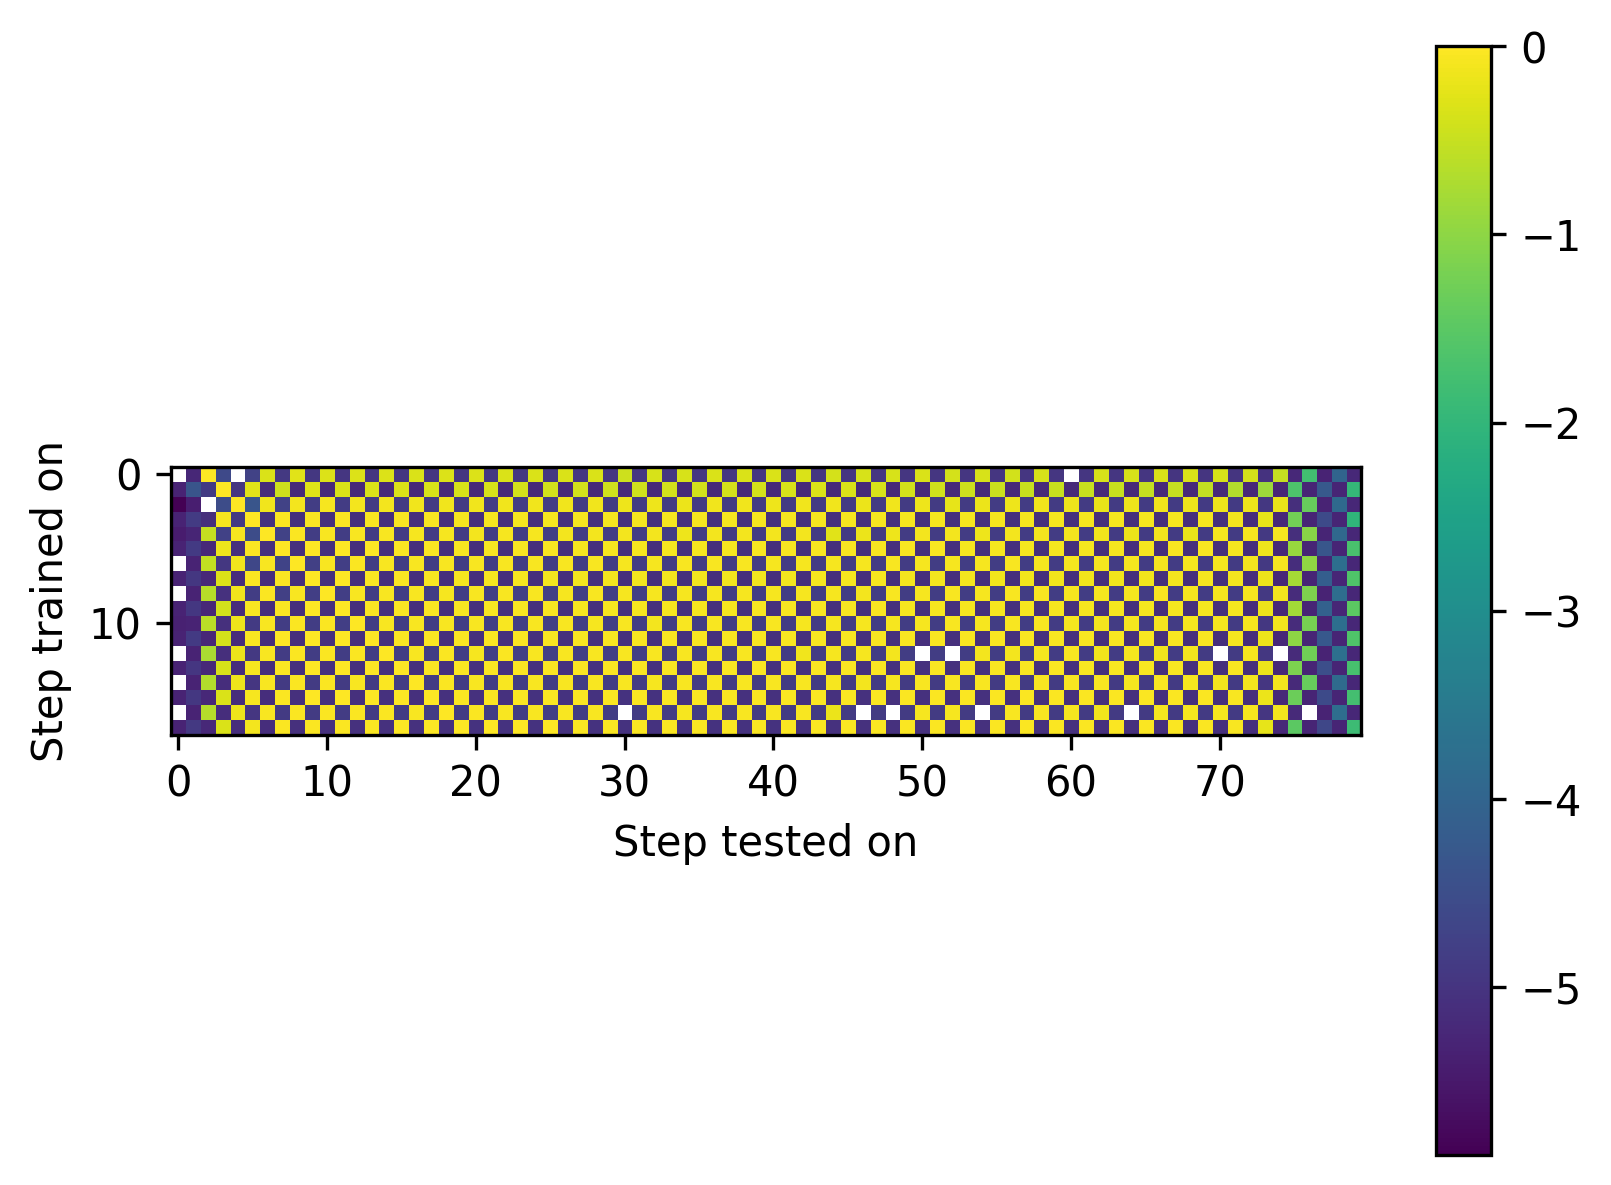

In [31]:
plt.figure(dpi=300)
plt.imshow(np.array(losses_train), vmax=0)
plt.xlabel('Step tested on')
plt.xticks(np.arange(0, 80, 10), np.arange(0, 80, 10))
# plt.yticks(np.arange(len(train_steps))[10::10]-train_steps[0], np.arange(len(train_steps))[10::10])
plt.ylabel('Step trained on')
plt.colorbar()
# plt.savefig('./figs/full/choice_accs_mat.png', dpi=300)

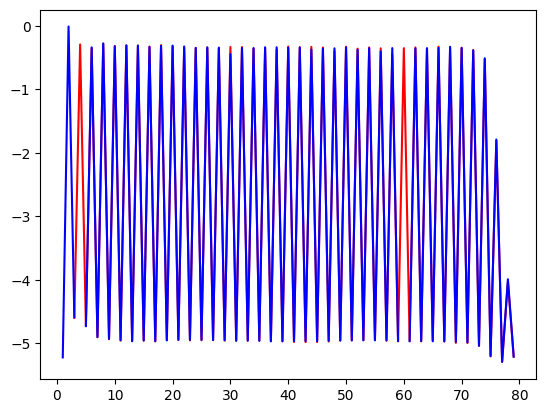

In [28]:
plt.plot(losses_test[0],c='r')
plt.plot(losses_train[0],c='b')

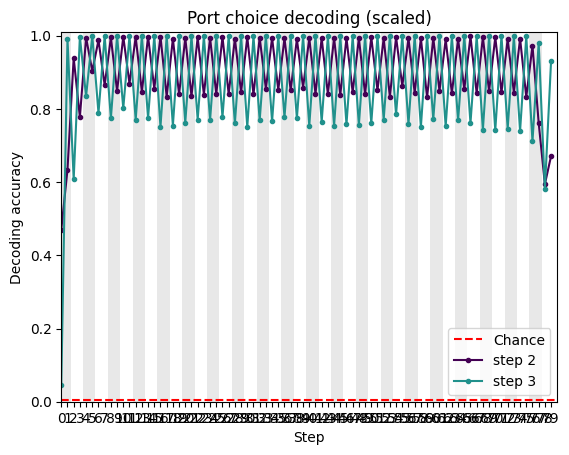

In [29]:
plot_decoding_accuracy_looped(accs[2:4], train_steps, n_class=Conf.port_dim, T=80, title='Port choice decoding (scaled)')
fig = plt.gcf()
# fig.savefig('./figs/full/choice_fold.png', dpi=300)

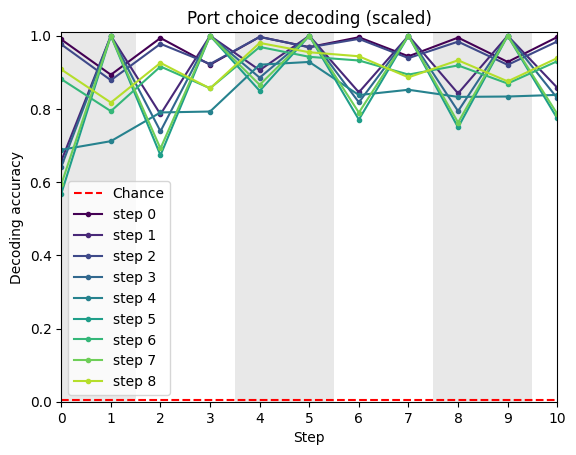

In [39]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, title='Port choice decoding (scaled)')
fig = plt.gcf()
fig.savefig('./figs/choice_scaled_.png', dpi=300)

(0.0, 0.02)

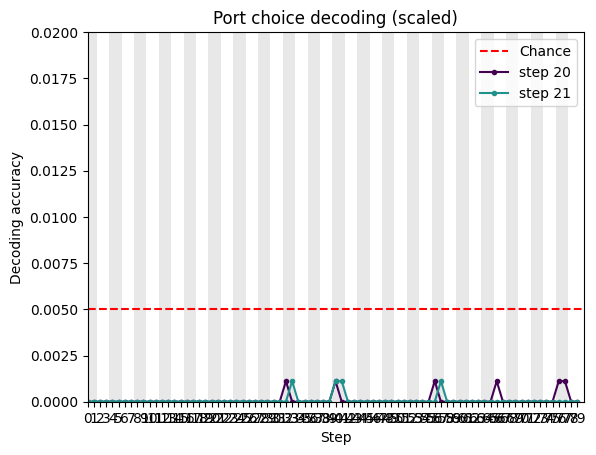

In [120]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, title='Port choice decoding (scaled)')
fig = plt.gcf()
fig.savefig('./figs/choice_scaled_.png', dpi=300)
plt.ylim([0, 0.02])

(-5.18837717899722, 0.0)

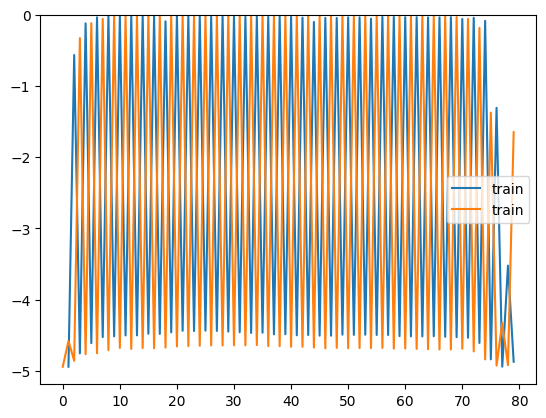

In [125]:
for l in losses_train:
    plt.plot(l, label='train')
# for l in losses_test:
#     plt.plot(l, 'r', label='test', linestyle=':')
plt.legend()
plt.ylim(top=0)

#### Unscaled

In [22]:
# train_steps = range(2,82)
scale = False
accs, conf_mats, losses_train, losses_test = train_decoders_looped(hiddens, action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                                                   scale=scale, exclude_batch_idxs=None, by_port=False, n_class=Conf.port_dim,
                                                                   multi_class='ovr', max_iter=1000, 
                                                                   random_state=42)

Finished scaling.
Train/test:	(8000, 80, 1024),	(2000, 80, 1024)
Folded:		(8000, 2, 1024)


  1%|▏         | 1/80 [00:00<00:12,  6.41it/s]

(2000, 200)
(2000, 200)


  5%|▌         | 4/80 [00:00<00:09,  8.31it/s]

(2000, 200)
(2000, 200)


  8%|▊         | 6/80 [00:00<00:09,  7.70it/s]

(2000, 200)
(2000, 200)


 10%|█         | 8/80 [00:01<00:09,  7.50it/s]

(2000, 200)
(2000, 200)


 12%|█▎        | 10/80 [00:01<00:08,  7.89it/s]

(2000, 200)
(2000, 200)


 15%|█▌        | 12/80 [00:01<00:07,  8.52it/s]

(2000, 200)
(2000, 200)


 18%|█▊        | 14/80 [00:01<00:08,  7.83it/s]

(2000, 200)
(2000, 200)


 20%|██        | 16/80 [00:02<00:08,  7.79it/s]

(2000, 200)
(2000, 200)


 22%|██▎       | 18/80 [00:02<00:08,  7.29it/s]

(2000, 200)
(2000, 200)


 25%|██▌       | 20/80 [00:02<00:07,  8.18it/s]

(2000, 200)
(2000, 200)


 28%|██▊       | 22/80 [00:02<00:06,  8.37it/s]

(2000, 200)
(2000, 200)


 30%|███       | 24/80 [00:03<00:06,  8.65it/s]

(2000, 200)
(2000, 200)


 32%|███▎      | 26/80 [00:03<00:06,  8.62it/s]

(2000, 200)
(2000, 200)


 35%|███▌      | 28/80 [00:03<00:07,  7.27it/s]

(2000, 200)
(2000, 200)


 38%|███▊      | 30/80 [00:03<00:06,  7.56it/s]

(2000, 200)
(2000, 200)


 39%|███▉      | 31/80 [00:03<00:06,  8.12it/s]

(2000, 200)
(2000, 200)


 42%|████▎     | 34/80 [00:04<00:05,  8.66it/s]

(2000, 200)
(2000, 200)
(2000, 200)


 46%|████▋     | 37/80 [00:04<00:05,  8.49it/s]

(2000, 200)
(2000, 200)


 48%|████▊     | 38/80 [00:04<00:04,  8.65it/s]

(2000, 200)
(2000, 200)


 51%|█████▏    | 41/80 [00:05<00:04,  8.34it/s]

(2000, 200)
(2000, 200)


 54%|█████▍    | 43/80 [00:05<00:04,  8.49it/s]

(2000, 200)
(2000, 200)


 56%|█████▋    | 45/80 [00:05<00:04,  7.78it/s]

(2000, 200)
(2000, 200)


 59%|█████▉    | 47/80 [00:05<00:04,  8.14it/s]

(2000, 200)
(2000, 200)


 61%|██████▏   | 49/80 [00:06<00:03,  7.75it/s]

(2000, 200)
(2000, 200)


 64%|██████▍   | 51/80 [00:06<00:03,  7.88it/s]

(2000, 200)
(2000, 200)


 66%|██████▋   | 53/80 [00:06<00:03,  6.81it/s]

(2000, 200)
(2000, 200)


 70%|███████   | 56/80 [00:06<00:02,  8.33it/s]

(2000, 200)
(2000, 200)
(2000, 200)


 72%|███████▎  | 58/80 [00:07<00:02,  8.07it/s]

(2000, 200)
(2000, 200)


 75%|███████▌  | 60/80 [00:07<00:02,  8.79it/s]

(2000, 200)
(2000, 200)


 78%|███████▊  | 62/80 [00:07<00:02,  8.40it/s]

(2000, 200)
(2000, 200)


 80%|████████  | 64/80 [00:07<00:01,  8.64it/s]

(2000, 200)
(2000, 200)


 82%|████████▎ | 66/80 [00:08<00:01,  7.70it/s]

(2000, 200)
(2000, 200)


 85%|████████▌ | 68/80 [00:08<00:01,  7.77it/s]

(2000, 200)
(2000, 200)


 88%|████████▊ | 70/80 [00:08<00:01,  7.68it/s]

(2000, 200)
(2000, 200)


 90%|█████████ | 72/80 [00:08<00:00,  8.37it/s]

(2000, 200)
(2000, 200)


 92%|█████████▎| 74/80 [00:09<00:00,  8.18it/s]

(2000, 200)
(2000, 200)


 95%|█████████▌| 76/80 [00:09<00:00,  7.74it/s]

(2000, 200)
(2000, 200)


 98%|█████████▊| 78/80 [00:09<00:00,  7.69it/s]

(2000, 200)
(2000, 200)


100%|██████████| 80/80 [00:10<00:00,  7.98it/s]


(2000, 200)
(2000, 200)


  2%|▎         | 2/80 [00:00<00:12,  6.11it/s]

(2000, 200)
(2000, 200)


  5%|▌         | 4/80 [00:00<00:10,  7.40it/s]

(2000, 200)
(2000, 200)


  8%|▊         | 6/80 [00:00<00:09,  7.75it/s]

(2000, 200)
(2000, 200)


  9%|▉         | 7/80 [00:00<00:09,  8.03it/s]

(2000, 200)
(2000, 200)


 12%|█▎        | 10/80 [00:01<00:09,  7.77it/s]

(2000, 200)
(2000, 200)


 14%|█▍        | 11/80 [00:01<00:08,  8.01it/s]

(2000, 200)
(2000, 200)


 18%|█▊        | 14/80 [00:01<00:08,  8.12it/s]

(2000, 200)
(2000, 200)


 20%|██        | 16/80 [00:02<00:07,  8.69it/s]

(2000, 200)
(2000, 200)


 22%|██▎       | 18/80 [00:02<00:07,  8.71it/s]

(2000, 200)
(2000, 200)


 25%|██▌       | 20/80 [00:02<00:06,  8.79it/s]

(2000, 200)
(2000, 200)


 29%|██▉       | 23/80 [00:02<00:06,  9.23it/s]

(2000, 200)
(2000, 200)
(2000, 200)


 31%|███▏      | 25/80 [00:03<00:06,  8.72it/s]

(2000, 200)
(2000, 200)


 34%|███▍      | 27/80 [00:03<00:06,  8.79it/s]

(2000, 200)
(2000, 200)


 36%|███▋      | 29/80 [00:03<00:06,  8.29it/s]

(2000, 200)
(2000, 200)


 39%|███▉      | 31/80 [00:03<00:05,  8.28it/s]

(2000, 200)
(2000, 200)


 41%|████▏     | 33/80 [00:04<00:06,  7.53it/s]

(2000, 200)
(2000, 200)


 44%|████▍     | 35/80 [00:04<00:05,  7.81it/s]

(2000, 200)
(2000, 200)


 46%|████▋     | 37/80 [00:04<00:05,  7.79it/s]

(2000, 200)
(2000, 200)


 49%|████▉     | 39/80 [00:04<00:05,  7.78it/s]

(2000, 200)
(2000, 200)


 51%|█████▏    | 41/80 [00:05<00:05,  7.46it/s]

(2000, 200)
(2000, 200)


 54%|█████▍    | 43/80 [00:05<00:04,  7.67it/s]

(2000, 200)
(2000, 200)
(2000, 200)


 59%|█████▉    | 47/80 [00:05<00:03,  9.15it/s]

(2000, 200)
(2000, 200)
(2000, 200)


 61%|██████▏   | 49/80 [00:05<00:03,  9.04it/s]

(2000, 200)
(2000, 200)


 64%|██████▍   | 51/80 [00:06<00:03,  8.61it/s]

(2000, 200)
(2000, 200)


 66%|██████▋   | 53/80 [00:06<00:03,  7.86it/s]

(2000, 200)
(2000, 200)


 68%|██████▊   | 54/80 [00:06<00:03,  7.73it/s]

(2000, 200)
(2000, 200)


 71%|███████▏  | 57/80 [00:06<00:02,  8.28it/s]

(2000, 200)
(2000, 200)


 74%|███████▍  | 59/80 [00:07<00:02,  8.05it/s]

(2000, 200)
(2000, 200)


 76%|███████▋  | 61/80 [00:07<00:02,  8.18it/s]

(2000, 200)
(2000, 200)


 79%|███████▉  | 63/80 [00:07<00:02,  7.80it/s]

(2000, 200)
(2000, 200)


 81%|████████▏ | 65/80 [00:07<00:02,  7.41it/s]

(2000, 200)
(2000, 200)


 84%|████████▍ | 67/80 [00:08<00:01,  7.79it/s]

(2000, 200)
(2000, 200)


 86%|████████▋ | 69/80 [00:08<00:01,  7.69it/s]

(2000, 200)
(2000, 200)


 89%|████████▉ | 71/80 [00:08<00:01,  8.09it/s]

(2000, 200)
(2000, 200)


 91%|█████████▏| 73/80 [00:09<00:00,  7.10it/s]

(2000, 200)
(2000, 200)


 94%|█████████▍| 75/80 [00:09<00:00,  7.68it/s]

(2000, 200)
(2000, 200)


 96%|█████████▋| 77/80 [00:09<00:00,  7.62it/s]

(2000, 200)
(2000, 200)


 99%|█████████▉| 79/80 [00:09<00:00,  8.41it/s]

(2000, 200)
(2000, 200)


100%|██████████| 80/80 [00:09<00:00,  8.10it/s]


(2000, 200)


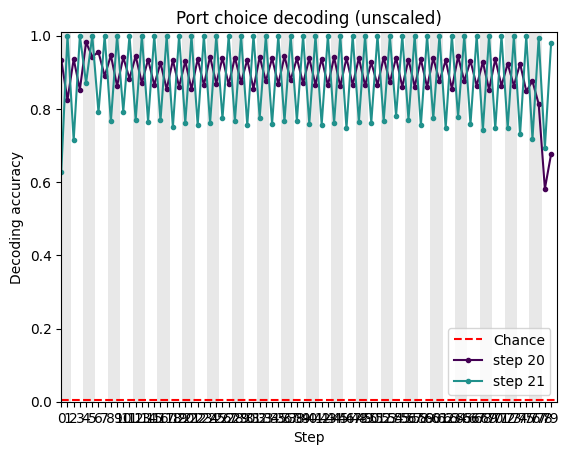

In [23]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, 
                              title='Port choice decoding ({})'.format('scaled' if scale else 'unscaled'))

### Port non-choice

#### Scaled

In [ ]:
scale = True
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale=scale, exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=80, 
                              title='Port non-choice decoding ({})'.format('scaled' if scale else 'unscaled'))

#### Unscaled

In [ ]:
# train_steps = range(2,82)
scale = False
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale=scale, exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding ({})'.format('scaled' if scale else 'unscaled'))

In [ ]:
train_steps = range(70,82)
scale = True
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale=scale, exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding ({})'.format('scaled' if scale else 'unscaled'))

In [ ]:
train_steps = range(70,82)
scale = True
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale_old=True, scale_new=False, 
                                        exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding ({})'.format('scaled' if scale else 'unscaled'))

In [ ]:
train_steps = range(70,82)
scale = True
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale_old=False, scale_new=False, 
                                        exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding ({})'.format('scaled' if scale else 'unscaled'))

In [ ]:
train_steps = range(2,82)
scale = True
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale_old=False, scale_new=True, 
                                        exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding ({})'.format('scaled' if scale else 'unscaled'))

In [ ]:
train_steps = [41]
scale = True
accs, conf_mats = train_decoders_looped(hiddens, not_action, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale_new=False, scale_old=False,
                                        exclude_batch_idxs=None, multi_class='ovr', max_iter=10000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding old scaling')

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding no scaling')

In [ ]:
plt.plot(np.m(hiddens, axis=(0,-1)))

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding new scaling')

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding minus mean')

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding minus mean')

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=Conf.port_dim, T=82, 
                              title='Port non-choice decoding minus mean')

### p(A)

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_16804/1532166980.py:4: RuntimeWarning: invalid value encountered in divide
  hiddens_ = (hiddens - mean) / std


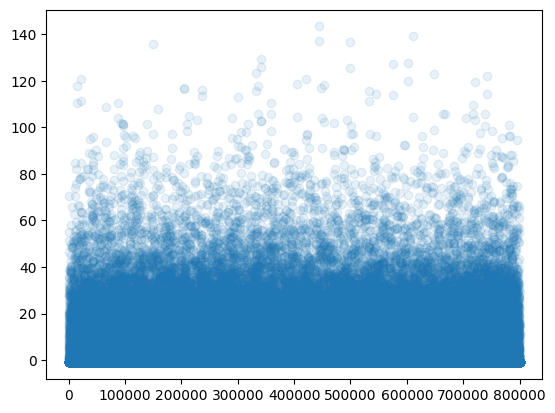

In [154]:
mean = np.mean(hiddens, axis=(0,1))
std = np.mean(hiddens, axis=(0,1))

hiddens_ = (hiddens - mean) / std

nan_idxs = np.where(np.any(np.isnan(hiddens_)==False, axis=(0,1)))[0]
hiddens_ = hiddens_[:,:,nan_idxs]
plt.plot(hiddens_[:,:,4].flatten(), marker='o', alpha=0.1, linestyle='')

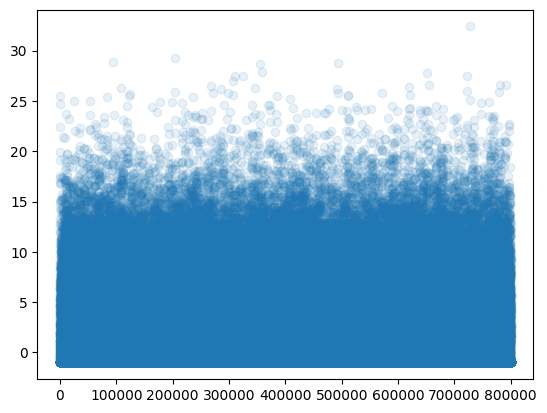

In [161]:
plt.plot(hiddens_[:,:,6].flatten(), marker='o', alpha=0.1, linestyle='')

In [58]:
collapse_p = True

train_steps = np.arange(2,80)

n_p_bins = 20
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze() if not collapse_p else np.digitize(0.5 + np.abs(p_A - 0.5), bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)

scale = False
by_port = False
fold = False
accs, conf_mats, losses_train, losses_test = train_decoders_looped(hiddens, bins, layouts, train_steps=train_steps, n_class=n_p_bins, 
                                                                   T=None, fold_trials=fold, scale=scale, exclude_batch_idxs=None, by_port=by_port,
                                                                   multi_class='ovr', max_iter=1000, random_state=42)

Finished scaling.
Train/test:	(8000, 80, 1024),	(2000, 80, 1024)
Folded:		(8000, 78, 1024)


  0%|          | 0/80 [00:00<?, ?it/s]/Users/jo/notebooks_paper/analysis/decoder/functions.py:489: RuntimeWarning: Mean of empty slice
  losses_train[i, step] = np.nanmean(p_train_sparse[idxs])
/Users/jo/notebooks_paper/analysis/decoder/functions.py:496: RuntimeWarning: Mean of empty slice
  losses_test[i, step] = np.nanmean(p_test_sparse[idxs])
  1%|▏         | 1/80 [00:00<00:07,  9.98it/s]/Users/jo/notebooks_paper/analysis/decoder/functions.py:489: RuntimeWarning: Mean of empty slice
  losses_train[i, step] = np.nanmean(p_train_sparse[idxs])
/Users/jo/notebooks_paper/analysis/decoder/functions.py:496: RuntimeWarning: Mean of empty slice
  losses_test[i, step] = np.nanmean(p_test_sparse[idxs])
  0%|          | 0/80 [00:00<?, ?it/s]/Users/jo/notebooks_paper/analysis/decoder/functions.py:489: RuntimeWarning: Mean of empty slice
  losses_train[i, step] = np.nanmean(p_train_sparse[idxs])
/Users/jo/notebooks_paper/analysis/decoder/functions.py:496: RuntimeWarning: Mean of empty slice
  los

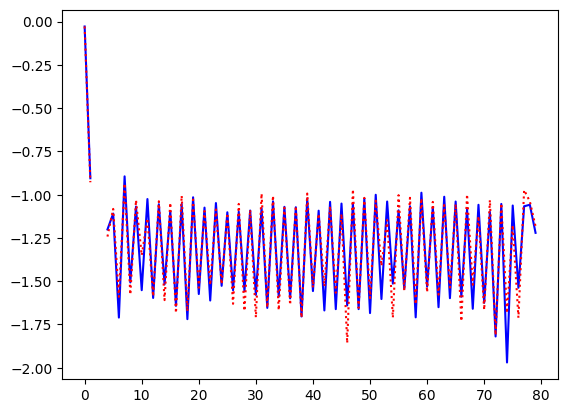

In [40]:
plt.plot(losses_train[0],c='b')
plt.plot(losses_test[0],c='r', linestyle=':')

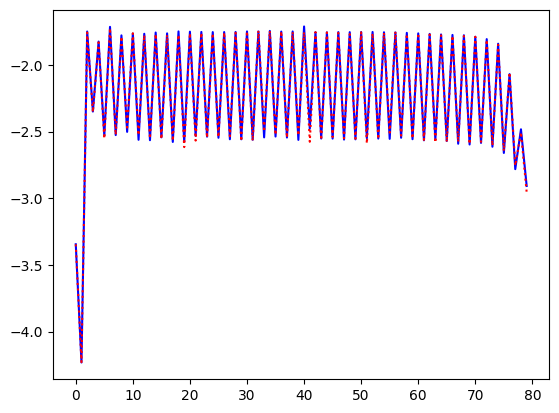

In [35]:
plt.plot(losses_train[0],c='b')
plt.plot(losses_test[0],c='r', linestyle=':')

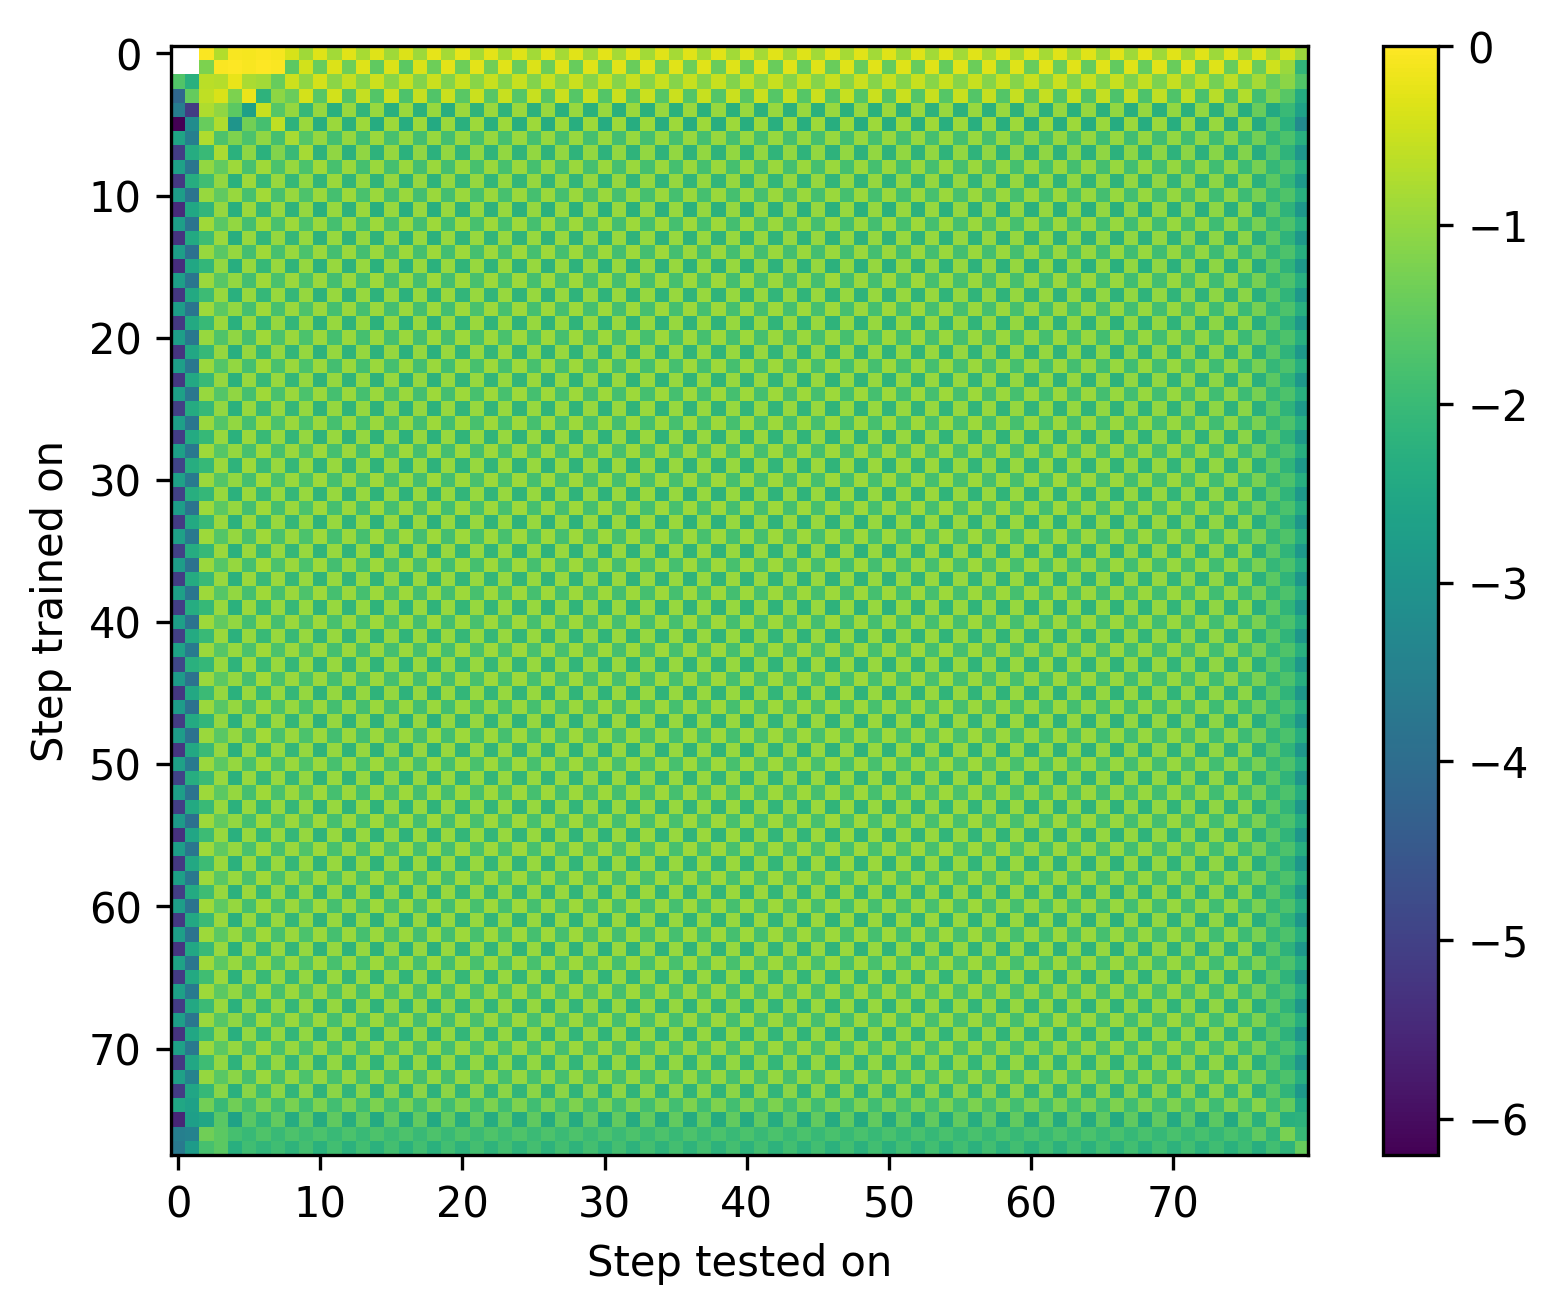

In [59]:
plt.figure(dpi=300)
plt.imshow(np.array(losses_train), vmax=0)
plt.xlabel('Step tested on')
plt.xticks(np.arange(0, 80, 10), np.arange(0, 80, 10))
# plt.yticks(np.arange(len(train_steps))[10::10]-train_steps[0], np.arange(len(train_steps))[10::10])
plt.ylabel('Step trained on')
plt.colorbar()
# plt.savefig('./figs/full/probs_trainloss_mat.png', dpi=300)

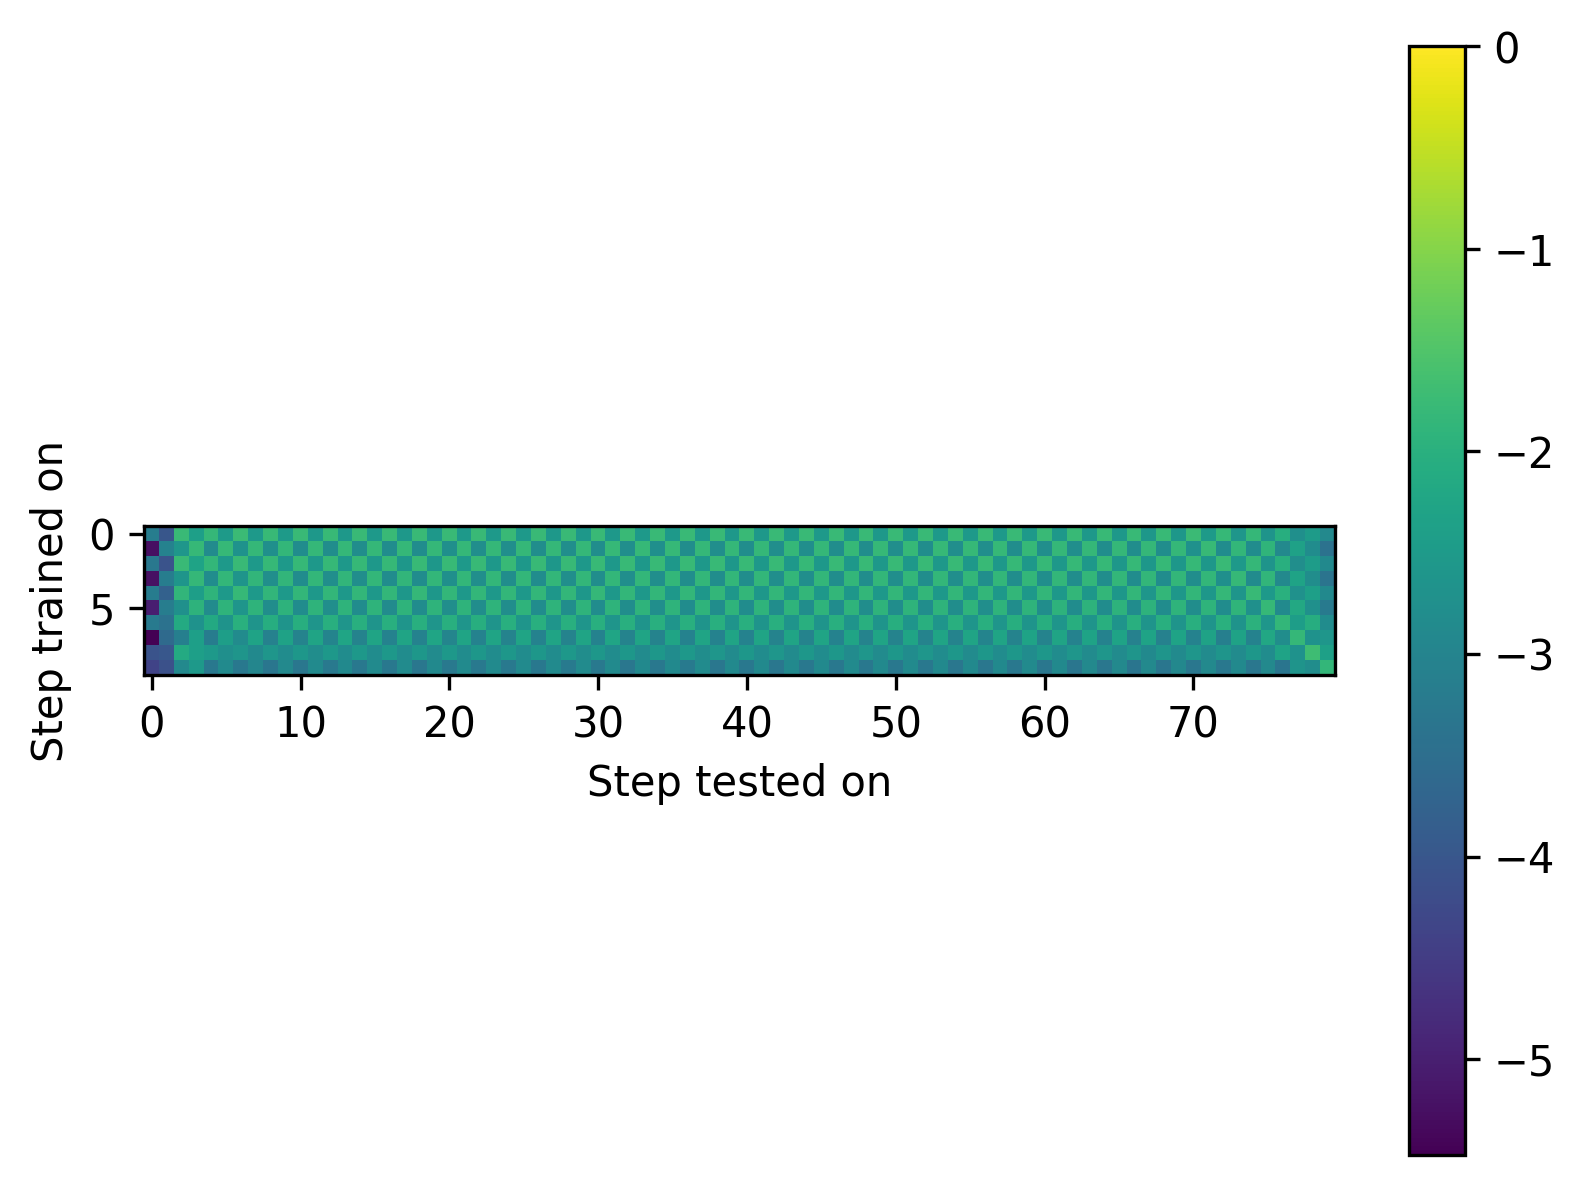

In [21]:
plt.figure(dpi=300)
plt.imshow(np.array(losses_train), vmax=0)
plt.xlabel('Step tested on')
plt.xticks(np.arange(0, 80, 10), np.arange(0, 80, 10))
# plt.yticks(np.arange(len(train_steps))[10::10]-train_steps[0], np.arange(len(train_steps))[10::10])
plt.ylabel('Step trained on')
plt.colorbar()
# plt.savefig('./figs/full/probs_accs_mat.png', dpi=300)

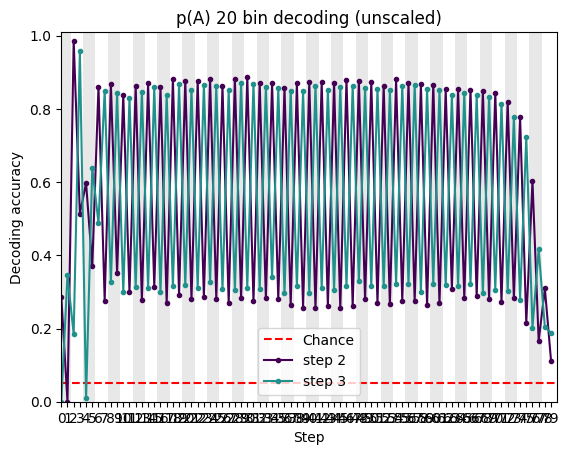

In [60]:
plot_decoding_accuracy_looped(accs[60:62], train_steps, n_class=n_p_bins, T=80, 
                              title='p(A) {} bin decoding ({})'.format(n_p_bins, 'scaled' if scale else 'unscaled'))
fig = plt.gcf()
# fig.savefig('./figs/full/probs.png', dpi=300)

(0.0, 82.95)

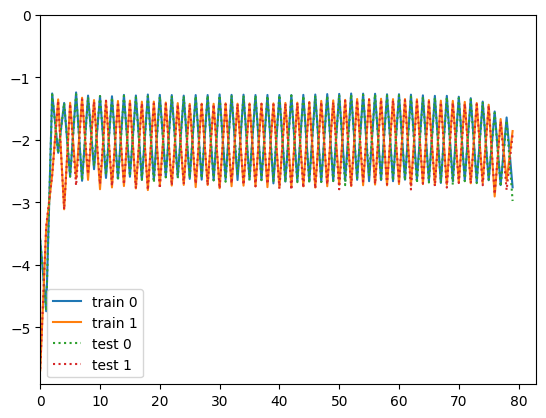

In [53]:
for i, l in enumerate(losses_train):
    plt.plot(l, label='train ' + str(i))
for i, l in enumerate(losses_test):
    plt.plot(l, label='test ' + str(i), linestyle=':')
plt.legend()
plt.ylim(top=0)
plt.xlim(left=0)

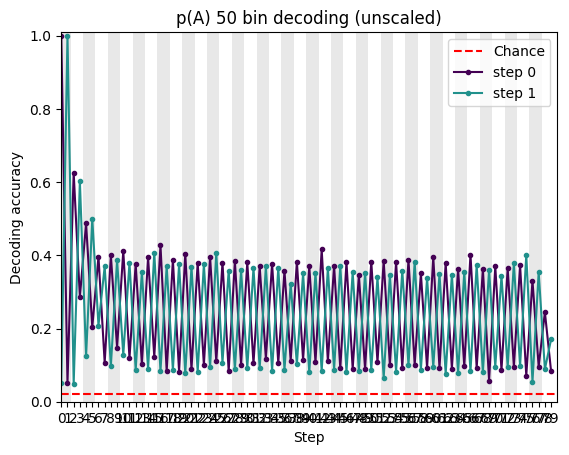

In [132]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=n_p_bins, T=80, 
                              title='p(A) {} bin decoding ({})'.format(n_p_bins, 'scaled' if scale else 'unscaled'))
fig = plt.gcf()
fig.savefig('./figs/probs_scaled.png', dpi=300)

(0.0, 82.95)

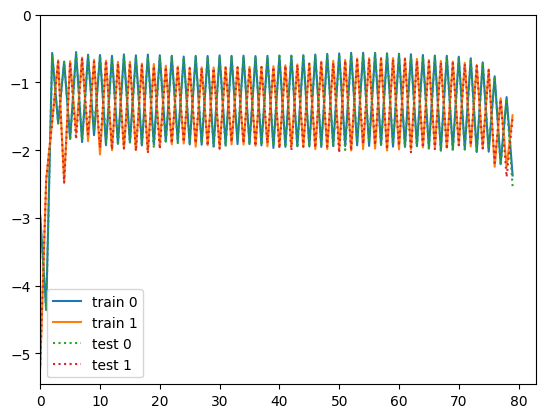

In [66]:
for i, l in enumerate(losses_train):
    plt.plot(l, label='train ' + str(i))
for i, l in enumerate(losses_test):
    plt.plot(l, label='test ' + str(i), linestyle=':')
plt.legend()
plt.ylim(top=0)
plt.xlim(left=0)

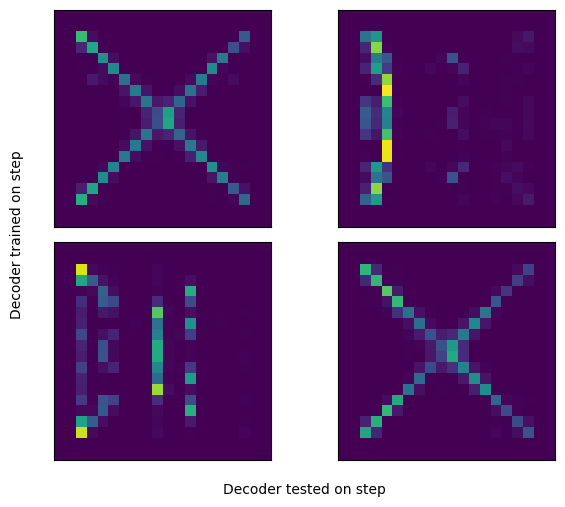

In [70]:
plot_conf_matrices_by_step(conf_mats)
fig = plt.gcf()
fig.savefig(f'./figs/full/cm_probs_fold_byport.png', dpi=300)

In [ ]:
train_steps = np.arange(0,80)

n_p_bins = 50
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)

scale = False
accs, conf_mats = train_decoders_looped(hiddens[:,2:,:], bins, layouts, train_steps=train_steps, T=None, fold_trials=True, 
                                        scale=scale, exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)

In [ ]:
plot_decoding_accuracy_looped(accs, train_steps, n_class=n_p_bins, T=20, 
                              title='p(A) {} bin decoding ({})'.format(n_p_bins, 'scaled' if scale else 'unscaled'))
fig = plt.gcf()
fig.savefig('./figs/probs_unscaled.png', dpi=300)

In [ ]:
plot_conf_matrices_by_step(conf_mats)
fig = plt.gcf()
fig.savefig('./figs/cm_probs_unscaled.png')

## Cross port decoding

In [ ]:
port_id = 1

In [ ]:
from functions import *
n_p_bins = 10
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins

p_A_ = np.abs(p_A-0.5)+0.5
bins = np.digitize(p_A_, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
train_steps = np.arange(4,160)

accs_all = []
for port_id in range(20):
    accs, conf_matrices = train_decoders_looped_port(port_id, hiddens, bins, layouts, train_steps=train_steps, T=160, fold_trials=True, scale=False,
                                                exclude_batch_idxs=None, multi_class='ovr', max_iter=1000, random_state=42)
    accs_all.append(accs)

In [ ]:
accs_all = np.array(accs_all)
print(accs_all.shape)
accs_mean = np.mean(accs_all, axis=0)

In [ ]:
plot_decoding_accuracy_looped(accs_mean, train_steps, n_class=n_p_bins, T=40, title='p(A) 50 bin decoding (unscaled)')

In [ ]:
accs_means_fold = np.zeros((Conf.trial_len, Conf.trial_len))
for i in range(Conf.trial_len):
    x = np.mean(accs_mean[:,2*Conf.trial_len+i::Conf.trial_len], axis=(-1))
    accs_means_fold[:, i] = x

cmap = plt.cm.get_cmap('viridis')
for i, line in enumerate(accs_means_fold):
    color = cmap(i / len(accs))
    plt.plot(line, color=color, marker='o', markersize=3)

In [ ]:
plot_conf_matrices_by_step(conf_matrices)

## What are my hypotheses?

### Trivial ones
1. Both ports decodable at every timestep
2. p(A) decodable at every timestep

### Non-trivial ones
3. Choice represented as good/bad binary or value continuum
4. Value integration is stimulus-generic
5. Value integration is stimulus-specific


## PCA

In [101]:
hiddens_flat = np.reshape(hiddens, (-1, hiddens.shape[-1]))
hiddens_flat -= np.mean(hiddens_flat, axis=0)
hiddens_flat /= np.std(hiddens_flat, axis=0)
hiddens_flat = hiddens_flat[~np.isnan(hiddens_flat).any(axis=0)]
# hiddens_flat.shape

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/1922496774.py:3: RuntimeWarning: invalid value encountered in divide
  hiddens_flat /= np.std(hiddens_flat, axis=0)


In [108]:
hiddens_flat = hiddens_flat[:, ~np.isnan(hiddens_flat).any(axis=0)]
hiddens_flat.shape

(800000, 969)

In [149]:
from sklearn.decomposition import PCA

scale = True

hiddens_flat = np.reshape(hiddens, (-1, hiddens.shape[-1]))
if scale:
    hiddens_flat -= np.mean(hiddens_flat, axis=0)
    hiddens_flat /= np.std(hiddens_flat, axis=0)
    hiddens_flat = hiddens_flat[:,~np.isnan(hiddens_flat).any(axis=0)]

pca = PCA(n_components=100)
pca.fit(hiddens_flat)
print(pca.explained_variance_ratio_[:50])

action_port = np.argmax(choices[:,:,-Conf.port_dim-1:], axis=-1)
a_choice = action_port == layouts[:,0, np.newaxis]
b_choice = action_port == layouts[:,1, np.newaxis]
null_choice = action_port == 200

X_comp = pca.transform(hiddens_flat)
X_comp = np.reshape(X_comp, (hiddens.shape[0], hiddens.shape[1], -1))

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/2761525091.py:8: RuntimeWarning: invalid value encountered in divide
  hiddens_flat /= np.std(hiddens_flat, axis=0)


[0.11089784 0.03143549 0.0203462  0.01922546 0.01563617 0.01423488
 0.01361155 0.01163126 0.01143426 0.01065985 0.01028743 0.0100626
 0.00950134 0.00889429 0.00853982 0.00816355 0.00789723 0.00739088
 0.00728634 0.00666106 0.0063851  0.00603617 0.00590887 0.00551456
 0.00547131 0.0053438  0.0050287  0.00455875 0.00453322 0.00439611
 0.00414502 0.0040123  0.00397341 0.00383221 0.00378502 0.00356873
 0.00354744 0.00352821 0.00347008 0.00337421 0.00334719 0.00325546
 0.00320287 0.00317127 0.00312518 0.00300374 0.00299452 0.00296155
 0.00291554 0.00290395]


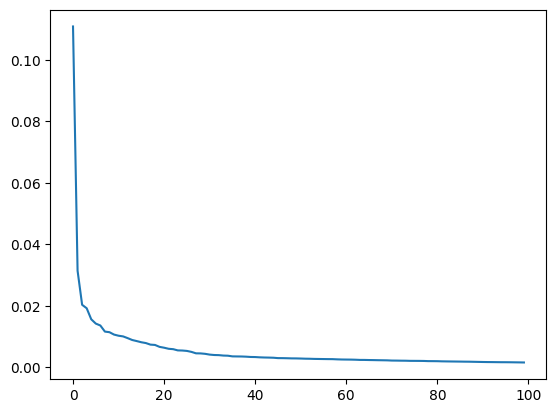

In [150]:
plt.plot(pca.explained_variance_ratio_[:100])

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/766727300.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/766727300.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=color)


Text(0.5, 0, 'PC3')

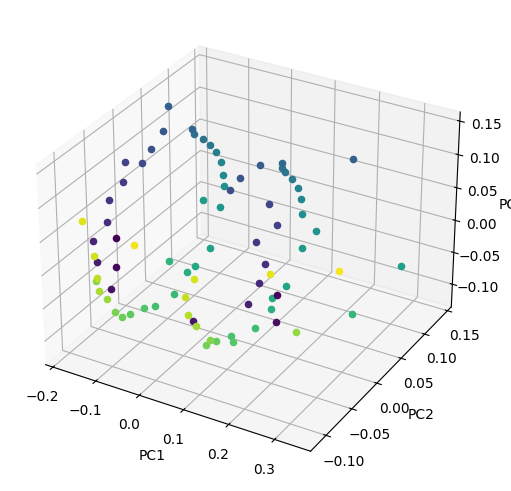

In [63]:
b = 7
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection='3d')

T = X_comp.shape[1]
cmap = plt.cm.get_cmap('viridis')

for i in range(T):
    x, y, z = X_comp[b, i, :3]
    color = cmap(i / T)
    ax.scatter(x, y, z, c=color)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


In [117]:
a = np.arange(10)
print(a)
print(a[-3:])

[0 1 2 3 4 5 6 7 8 9]
[7 8 9]


[ True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False]


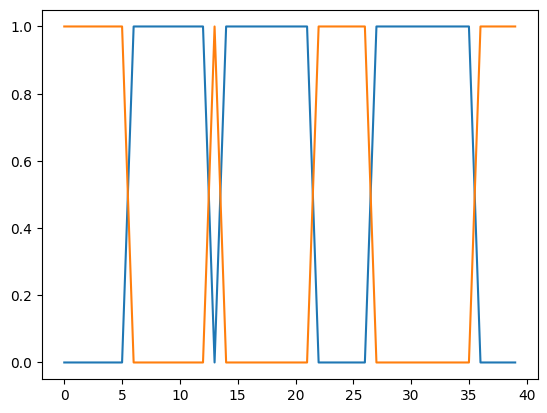

In [18]:
b=5
action_port = np.argmax(choices[:,:,-Conf.port_dim-1:], axis=-1)
a_choice = action_port == layouts[:,0, np.newaxis]
b_choice = action_port == layouts[:,1, np.newaxis]
null_choice = action_port == 200
print(null_choice[0,:])

plt.plot(np.arange(len(a_choice[b,1::2])), a_choice[b,1::2])
plt.plot(np.arange(len(b_choice[b,1::2])), b_choice[b,1::2])

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/3911556863.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')
MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/3911556863.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, s=25, c=c, edgecolor=[.6,.6,.6])


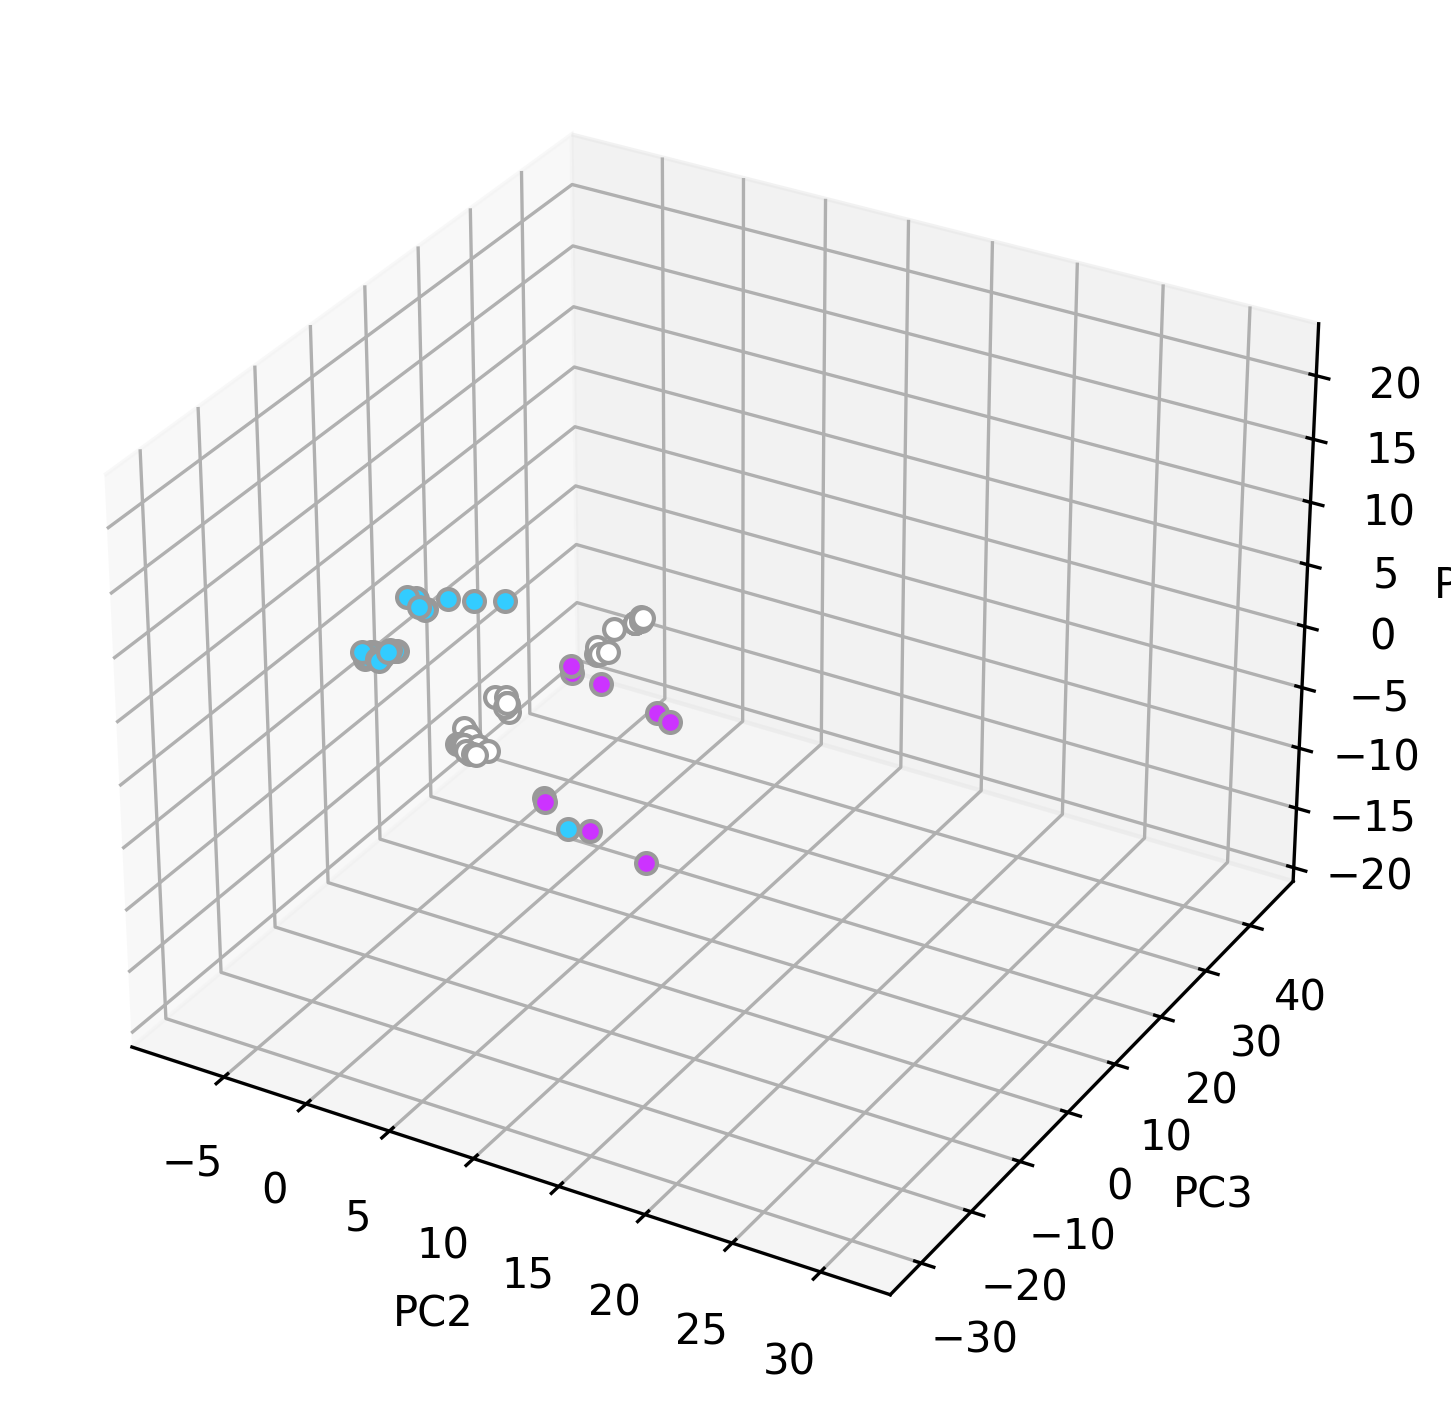

In [127]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

b = 1
T = X_comp.shape[1]
cmap = plt.cm.get_cmap('cool')

# Setup the figure and axis for 3D plotting
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

# Setting the limits if necessary (you might want to adjust these based on your data)
dims= [1, 2, 3]

ax.set_xlim([np.min(X_comp[:,:,dims[0]]), np.max(X_comp[:,:,dims[0]])])
ax.set_ylim([np.min(X_comp[:,:,dims[1]]), np.max(X_comp[:,:,dims[1]])])
ax.set_zlim([np.min(X_comp[:,:,dims[2]]), np.max(X_comp[:,:,dims[2]])])

# Initialize an empty plot
plot = ax.scatter([], [], [], c=[])

ax.set_xlabel(f'PC{dims[0]+1}')
ax.set_ylabel(f'PC{dims[1]+1}')
ax.set_zlabel(f'PC{dims[2]+1}')

plt.tight_layout()

# Animation update function
def update(i):
    x, y, z = X_comp[b, i, dims]
    # if a_choice[b, i]:
    #     c = 'r'
    # elif b_choice[b, i]:
    #     c = 'b'
    # elif null_choice[b, i]:
    #     c = 'k'
    # else:
    #     c = 'g'
    if null_choice[b, i]:
        c = 'w'
    else:
        # v = 2*np.abs(p_A[b, i//2, 0] - 0.5)
        # v = p_A[b, i//2, 0]
        v = 0.2 + 0.6*switch[b, i//2]
        c = cmap(v)
    ax.scatter(x, y, z, s=25, c=c, edgecolor=[.6,.6,.6]) 
    # ax.scatter(x, y, z, c=c)  # Scatter expects a list of colors
    return plot,

# Create animation
ani = FuncAnimation(fig, update, frames=range(T), blit=True)

ani.save('animation6.gif', writer='imagemagick')

# To display the animation in a Jupyter notebook
# HTML(ani.to_html5_video())

In [176]:
switch[0,:]

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/79901354.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_35280/79901354.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=25, c=c, alpha=alpha)  # Scatter expects a list of colors


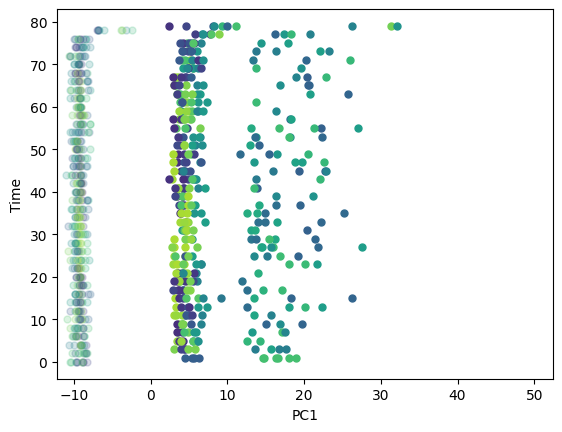

In [158]:
b = 0
T = X_comp.shape[1]
cmap = plt.cm.get_cmap('viridis')

# Setup the figure and axis for 3D plotting
fig = plt.figure()
ax = fig.add_subplot()

# Setting the limits if necessary (you might want to adjust these based on your data)
dim=0
ax.set_xlim([np.min(X_comp[:,:,dim]), np.max(X_comp[:,:,dim])])
# ax.set_ylim((-0.05, 0.05))

# Initialize an empty plot
plot = ax.scatter([], [], c=[])
ax.set_xlabel(f'PC{dim+1}')
ax.set_ylabel('Time')

# Animation update function
for b in range(10):
    for i in range(T):
        x, y = X_comp[b, i, dim], i
        # v = 0.2 + 0.6*switch[b, i//2]
        # v = np.abs(p_A[b, i//2, 0]-0.5)
        # v = p_A[b, i//2, 0]

        if null_choice[b, i]:
            # c = 'w'
            alpha = 0.2
        else:
            alpha = 1.
            # v = 2*np.abs(p_A[b, i//2, 0] - 0.5)
            v = p_A[b, i//2, 0]
            c = cmap(v)

        ax.scatter(x, y, s=25, c=c, alpha=alpha)  # Scatter expects a list of colors

plt.savefig(f'pc{dim+1}_absprob_scaled.png', dpi=300)


<BarContainer object of 100 artists>

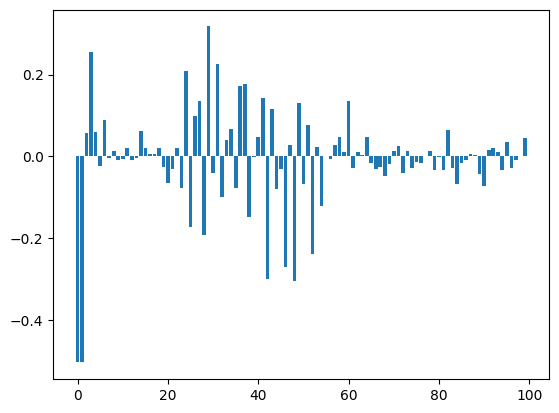

In [152]:
true = np.abs(p_A-0.5).flatten()
corrs = []
for dim in range(100):
    pred = X_comp[:, 1::2, dim].flatten()
    corr = np.corrcoef(true, pred)[0,1]
    corrs.append(corr)

plt.bar(np.arange(100), corrs)

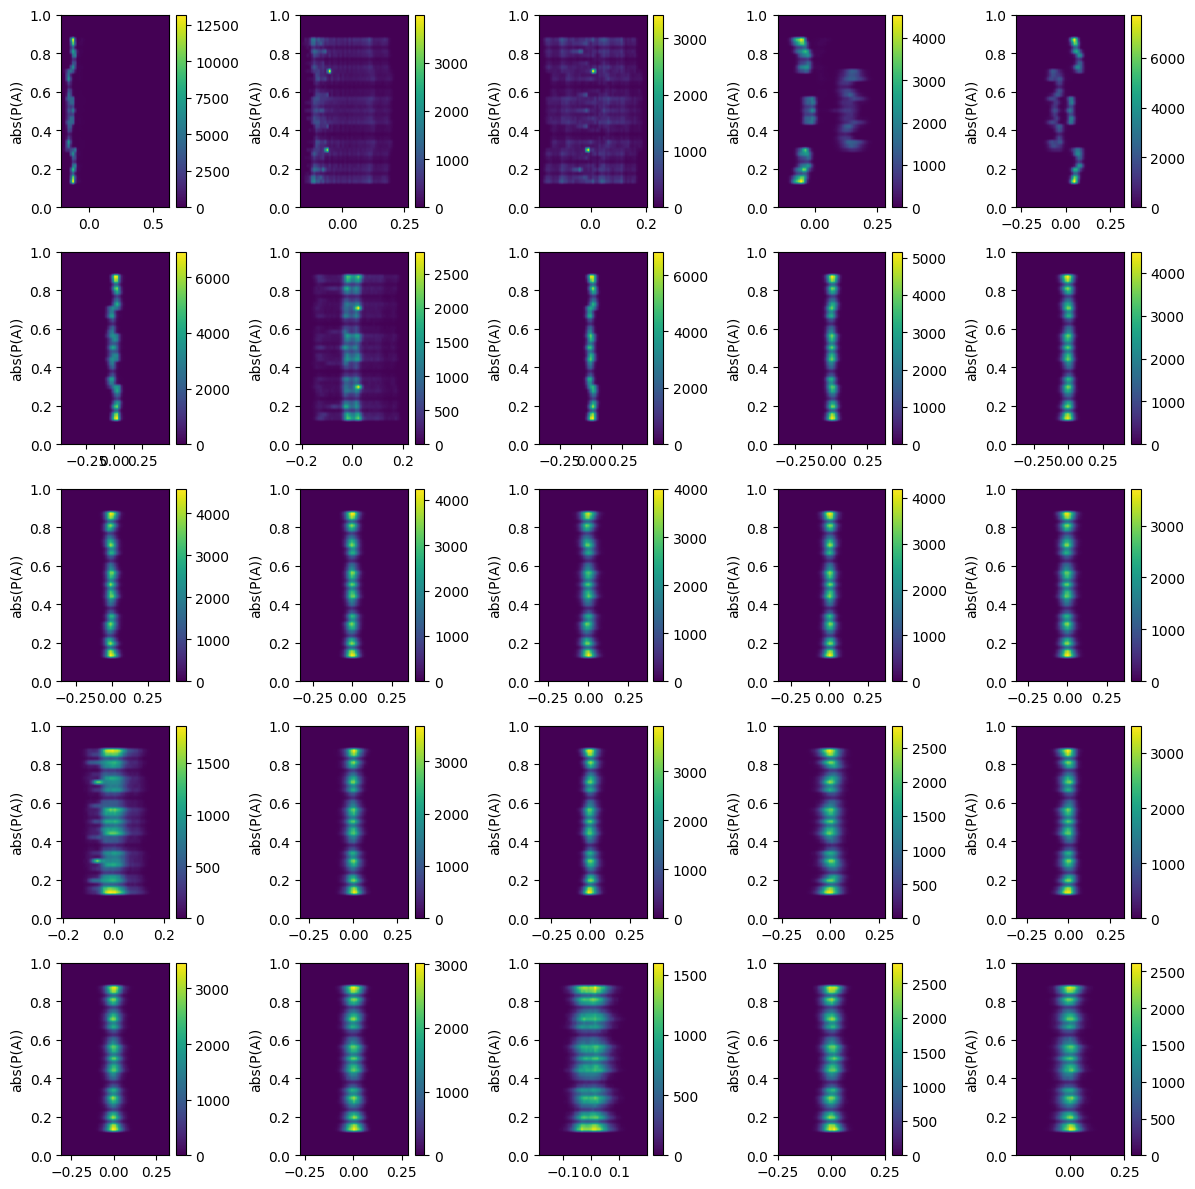

In [110]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5,5, figsize=(12,12))
for dim, ax in enumerate(axes.flatten()):
    val_pred = X_comp[:, 0::2, dim].flatten()
    val_true = p_A.flatten()

    # Compute a 2D histogram
    xbins = np.linspace(np.min(X_comp[:, :, dim]), np.max(X_comp[:, :, dim]), 50)
    ybins = np.linspace(0, 1.0, 50)
    hist, xedges, yedges = np.histogram2d(val_pred, val_true, bins=(xbins, ybins))

    # Display the 2D histogram as an image
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(hist.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')

    ax.set_ylabel('abs(P(A))')
    fig.colorbar(im, ax=ax)

plt.tight_layout()


In [123]:
np.reshape(np.arange(10), (50))

ValueError: cannot reshape array of size 10 into shape (50,)

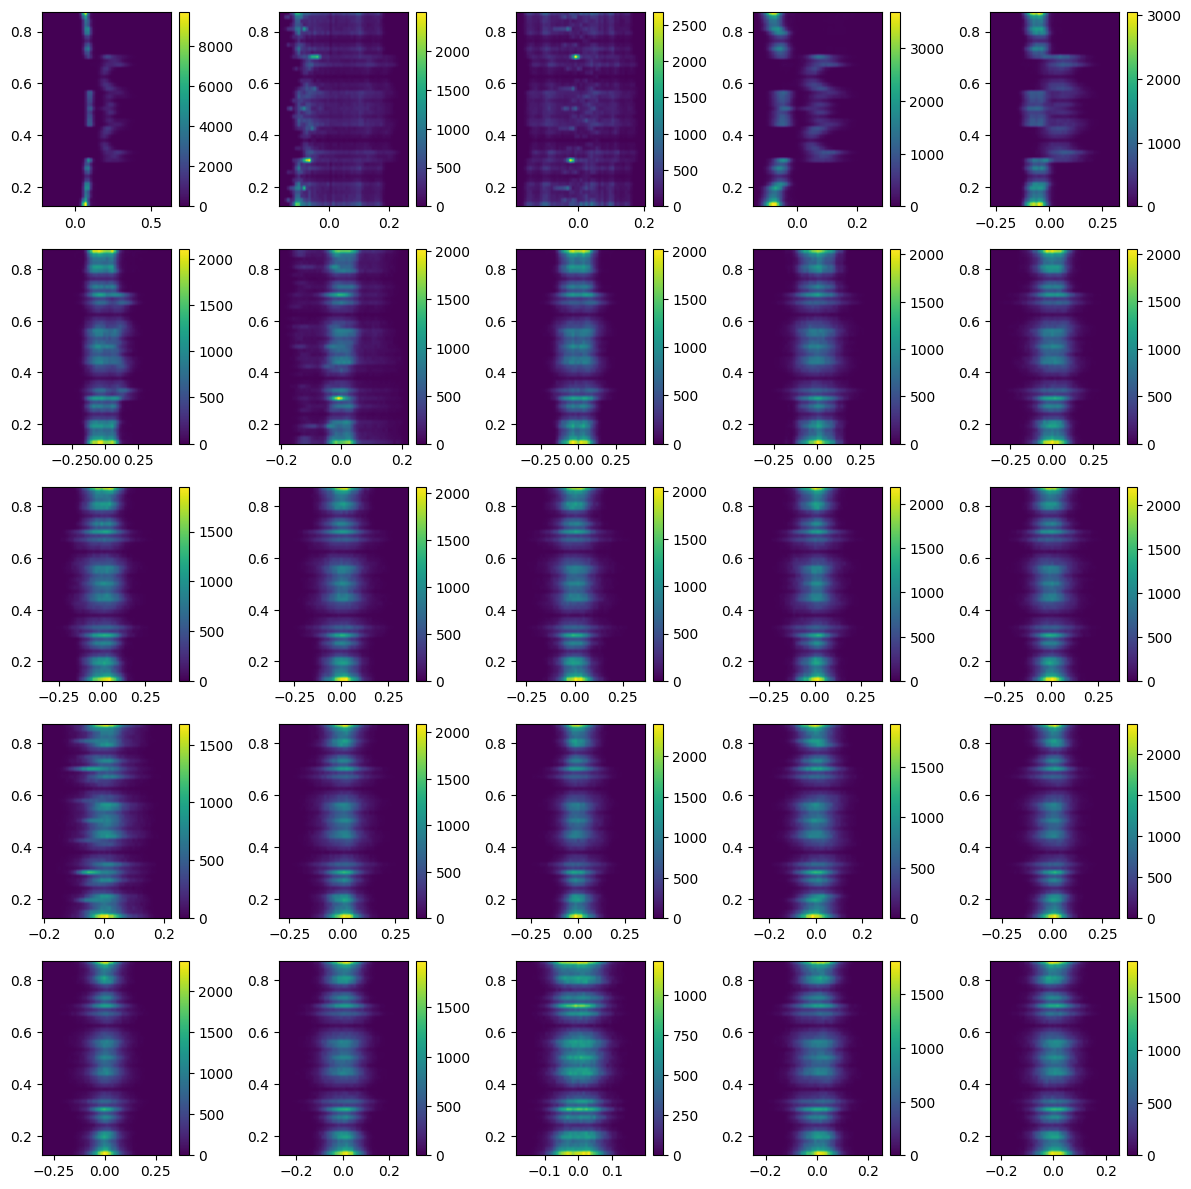

In [164]:
import numpy as np
import matplotlib.pyplot as plt

x = X_comp[:, 1::2, :]
# y_true = np.tile(np.array([0, 1]), (x.shape[1]*x.shape[0])//2)
# print(x.shape, y_true.shape)
y_true = p_A.flatten()
# y_true = switch.flatten()
# y_true = np.tile(np.arange(x.shape[1]), x.shape[0])

fig, axes = plt.subplots(5,5, figsize=(12,12))
for dim, ax in enumerate(axes.flatten()):
    y_pred = x[:, :, dim].flatten()

    # Compute a 2D histogram
    xbins = np.linspace(np.min(X_comp[:, :, dim]), np.max(X_comp[:, :, dim]), 50)
    ybins = np.linspace(np.min(y_true), np.max(y_true), 50)
    hist, xedges, yedges = np.histogram2d(y_pred, y_true, bins=(xbins, ybins))

    # Display the 2D histogram as an image
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(hist.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')

    # ax.set_ylabel('abs(P(A))')
    fig.colorbar(im, ax=ax)

plt.tight_layout()


In [75]:
ab_choice = (p_A[:,:,0]>0.5).astype(int)
switch = np.pad(np.abs(ab_choice[:,1:] - ab_choice[:,:-1]), ((0,0),(1,0)))
switch.shape

(10000, 40)

[0.  0.5 1. ]


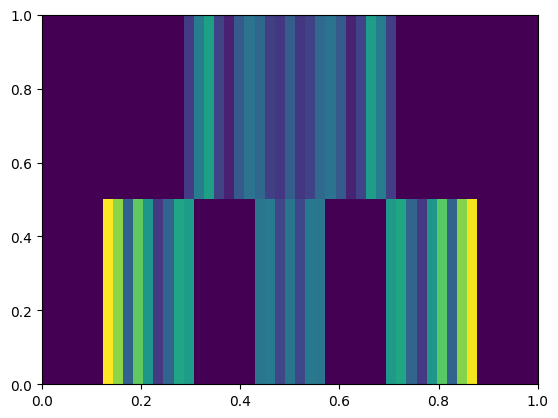

In [199]:
xbins = np.linspace(0, 1., 50)
ybins = np.linspace(0, 1, 3)
print(ybins)
hist, xedges, yedges = np.histogram2d(p_A.flatten(), switch.flatten(), bins=(xbins, ybins))
plt.figure()
# Display the 2D histogram as an image
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = plt.imshow(hist.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
plt.show()

(0.0, 1.0)

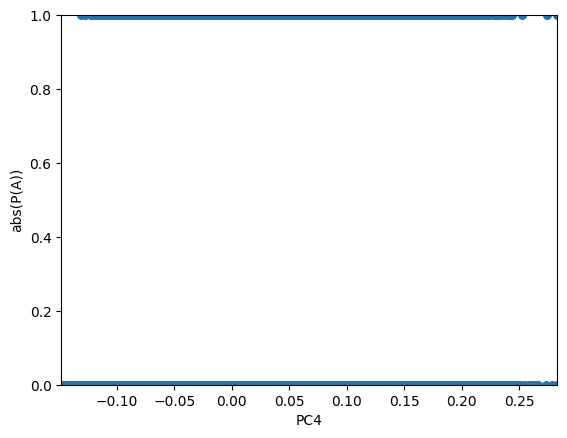

In [163]:
dim=3
x = X_comp[:, 1::2, dim].flatten()
y = switch.flatten()

plt.scatter(x, y, s=30)
plt.xlabel('PC4')
plt.ylabel('abs(P(A))')
plt.xlim(min(x), max(x))
plt.ylim(min(y), max(y))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_87298/2503559282.py:21: RuntimeWarning: invalid value encountered in divide
  transition_matrix = counts / counts.sum(axis=1, keepdims=True)


LinAlgError: Array must not contain infs or NaNs

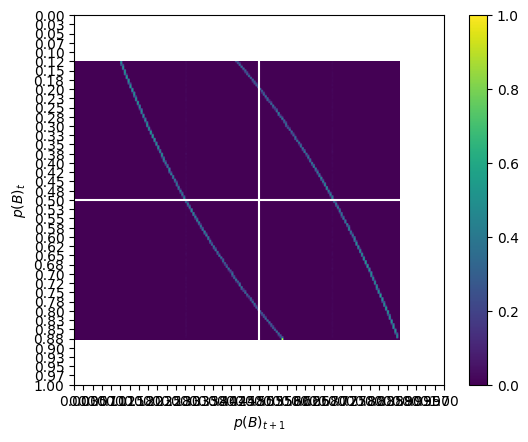

In [209]:
n_p_bins = 200
bin_edges = np.linspace(0, 1, n_p_bins+1)  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges) - 1

# how to get a transition matrix from this series of numbers?
import numpy as np
from scipy.sparse import csr_matrix

# Number of unique states
bins = bins.flatten()
num_states = max(bins) + 1

# Collect transitions
rows = bins[:-1]
cols = bins[1:]

# Count transitions using a sparse matrix
counts = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(num_states, num_states)).toarray()

# Normalize to get probabilities
transition_matrix = counts / counts.sum(axis=1, keepdims=True)

plt.imshow(transition_matrix)
print(np.nansum(transition_matrix, axis=1))
plt.xticks(np.arange(-0.5, n_p_bins+1, 5), [f'{b:.2f}' for b in bin_edges[::5]])
plt.yticks(np.arange(-0.5, n_p_bins+1, 5), [f'{b:.2f}' for b in bin_edges[::5]])
plt.ylabel(r'$p(B)_{t}$')
plt.xlabel(r'$p(B)_{t+1}$')
plt.colorbar()
plt.axhline(np.mean(bins), c='w')
plt.axvline(np.mean(bins), c='w')


eigenvalues, eigenvectors = np.linalg.eig(transition_matrix)

print(eigenvectors.shape)
plt.figure()
plt.plot([p for p in np.real(eigenvectors[:, :])])
plt.show()

In [12]:
print(action.shape)

(10000, 80)


In [13]:
start_trial, end_trial = 1, -1
target_choices = np.argmax(targets[:, :, -(Conf.port_dim + 1):-1], axis=-1)
b = 6
print(target_choices[b,1::2])
print(action[b, 1::2])
print(p_A[b, :, 0])

[ 4  4  4  4  4 53  4 53  4 53  4  4 53  4  4  4  4  4  4  4  4  4 53  4
 53 53 53 53 53 53 53 53 53 53 53  4 53 53  4 53]
[ 4  4  4  4  4 53  4 53  4 53  4  4 53  4  4  4  4  4  4  4  4  4 53  4
 53 53 53 53 53 53 53 53 53 53 53  4 53 53  4  4]
[0.7        0.8012048  0.8453287  0.5370411  0.7203412  0.43982238
 0.66518307 0.401439   0.64174354 0.3858677  0.6319432  0.76903045
 0.47589502 0.6863254  0.7949106  0.8427046  0.8622577  0.8700164
 0.55815387 0.7315865  0.81543124 0.5123682  0.30697218 0.57949907
 0.34649065 0.22054029 0.16380219 0.14035453 0.13101225 0.44273973
 0.2688845  0.18477781 0.1488814  0.13438685 0.44566238 0.6686628
 0.40378714 0.24875058 0.5375293  0.32144567]


In [14]:
action_trimmed = action[:, 2 * start_trial : 2 * end_trial]
target_choices = np.repeat(np.argmax(targets[:, 2 * start_trial : 2 * end_trial, -(Conf.port_dim + 1):-1], axis=-1)[:, 1::2], 2, axis=-1)

correct = action_trimmed == target_choices

print(action_trimmed[0,:])
print(target_choices[0,:])

idx = np.where(~correct)
p_A_trimmed[idx]

[113 113   0   0   0   0 113 113 113 113   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 113 113 113 113
   0   0 113 113 113 113 113 113 113 113 113 113 113 113 113 113   0   0
 113 113 113 113 113 113 113 113 113 113   0   0   0   0   0   0   0   0
   0   0 113 113]
[113 113   0   0   0   0 113 113 113 113   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 113 113 113 113
   0   0 113 113 113 113 113 113 113 113 113 113 113 113 113 113   0   0
 113 113 113 113 113 113 113 113 113 113   0   0   0   0   0   0   0   0
   0   0 113 113]


NameError: name 'p_A_trimmed' is not defined

In [26]:
import pandas as pd
from copy import copy

n_p_bins = 10
n_port = 15

start_trial, end_trial = 1, -1
action_trimmed = action[:, 2 * start_trial : 2 * end_trial]
not_action_trimmed = not_action[:, 2 * start_trial : 2 * end_trial]

p_A_trimmed = np.repeat(p_A, 2, axis=1)[:, 2 * start_trial : 2 * end_trial]
# bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
# bin_edges = np.linspace(np.min(p_A), np.max(p_A), 20+1)[1:]  # Creates 5 edges for 4 bins
# p_bins = np.digitize(p_A_trimmed, bin_edges).squeeze()

steps = np.repeat(np.tile(np.arange(2), action_trimmed.shape[1] // 2)[np.newaxis, :], action_trimmed.shape[0], axis=0)

print(steps.shape)
assert steps.shape == action_trimmed.shape

datas = []

for step in range(2):
    for port in range(n_port):
        p_port = copy(p_A_trimmed)
        p_port[(layouts == port)[:,-1], :] = 1 - p_port[(layouts == port)[:,-1], :]
        bin_edges = np.linspace(0.5, np.max(p_port), n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
        p_bins = np.digitize(p_port, bin_edges).squeeze()

        for prob in range(n_p_bins):
            # idxs = np.where((action_trimmed[:, ::2] == port) & (p_bins == prob))
            # idxs = np.where((action_trimmed == port) & (p_bins == prob) & (steps == step))
            idxs = np.where((action_trimmed == port) & (p_bins == prob) & (steps == step) & (correct))

            n_elem = len(idxs[0])

            # hid_data = hiddens[idxs]
            row_idx_data = np.expand_dims(idxs[0], -1)
            col_idx_data = np.expand_dims(idxs[1], -1)
            port_data = int(port) * np.ones((n_elem, 1), dtype=np.int64)
            step_data = int(step) * np.ones((n_elem, 1), dtype=np.int64)
            prob_data = int(prob) * np.ones((n_elem, 1), dtype=np.int64)

            data = np.concatenate([step_data, port_data, prob_data, row_idx_data, col_idx_data], axis=1)
            print(f'step {step}, port {port}, prob {prob}, shape {data.shape}')

            datas.append(data)
            # ys.append(y)
            # xs.append(x)

datas = np.concatenate(datas, axis=0)
print(datas.shape)

# X = np.concatenate(xs)
# Y = np.concatenate(ys)

# y = hiddens[choice_zero_idxs]
# x = np.ones((y.shape[0], 1))
# print(x.shape)
# y.shape is (2141, 1024)
# I want to train a linear regression model with Lasso regularization to predict the 2141 batches, from x

(10000, 76)
step 0, port 0, prob 0, shape (224, 5)
step 0, port 0, prob 1, shape (279, 5)
step 0, port 0, prob 2, shape (102, 5)
step 0, port 0, prob 3, shape (82, 5)
step 0, port 0, prob 4, shape (216, 5)
step 0, port 0, prob 5, shape (199, 5)
step 0, port 0, prob 6, shape (163, 5)
step 0, port 0, prob 7, shape (183, 5)
step 0, port 0, prob 8, shape (246, 5)
step 0, port 0, prob 9, shape (446, 5)
step 0, port 1, prob 0, shape (165, 5)
step 0, port 1, prob 1, shape (244, 5)
step 0, port 1, prob 2, shape (111, 5)
step 0, port 1, prob 3, shape (58, 5)
step 0, port 1, prob 4, shape (167, 5)
step 0, port 1, prob 5, shape (149, 5)
step 0, port 1, prob 6, shape (157, 5)
step 0, port 1, prob 7, shape (148, 5)
step 0, port 1, prob 8, shape (186, 5)
step 0, port 1, prob 9, shape (383, 5)
step 0, port 2, prob 0, shape (207, 5)
step 0, port 2, prob 1, shape (287, 5)
step 0, port 2, prob 2, shape (111, 5)
step 0, port 2, prob 3, shape (76, 5)
step 0, port 2, prob 4, shape (208, 5)
step 0, port 2, 

In [27]:
df = pd.DataFrame(datas)
df.columns = ['step', 'port', 'prob', 'row', 'col']

print(df)
print('123')

       step  port  prob   row  col
0         0     0     0     0   36
1         0     0     0     0   70
2         0     0     0   345   60
3         0     0     0   502   42
4         0     0     0   502   48
...     ...   ...   ...   ...  ...
57899     1    14     9  9948   75
57900     1    14     9  9949    3
57901     1    14     9  9949   29
57902     1    14     9  9949   37
57903     1    14     9  9949   39

[57904 rows x 5 columns]
123


In [28]:
import numpy as np

# mask = (df['step'] == step) & (df['port'] == port) & (df['prob'] == prob)
mask = None
remove_dead_neurons = True

def get_xy(df, mask, hiddens_trimmed, scale=True, remove_dead_neurons=False):
    df_masked = df[mask] if mask is not None else df
    row = df_masked['row']
    col = df_masked['col']

    y = copy(hiddens_trimmed[row, col])

    if remove_dead_neurons:
        keep_idxs = np.where(~np.all(y == 0, axis=(0)))[0]
        y = y[:, keep_idxs]

    if scale:
        y -= np.mean(y, axis=0)
        y /= np.std(y, axis=0)
        y = y[:,~np.isnan(y).any(axis=0)]

    x_ = pd.concat([df_masked['step'], df_masked['port'], df_masked['prob']], axis=1).to_numpy()

    x = indices_to_onehot(x_)
    return x, y

def indices_to_onehot(indices):
    dim1, dim2, dim3 = 2, n_port, n_p_bins
    num_samples = indices.shape[0]
    num_classes = dim1 * dim2 * dim3
    onehot = np.zeros((num_samples, num_classes), dtype=np.float32)
    onehot[np.arange(num_samples), indices[:, 0] * (dim2 * dim3) + indices[:, 1] * dim3 + indices[:, 2]] = 1
    return onehot

hiddens_trimmed = hiddens[:, 2*start_trial : 2*end_trial, :]

if remove_dead_neurons:
    keep_idxs = np.where(~np.all(hiddens_trimmed == 0, axis=(0,1)))[0]
    hiddens_trimmed = hiddens_trimmed[:, :, keep_idxs]

x, y = get_xy(df, mask, hiddens_trimmed, scale=False, remove_dead_neurons=False)

print(x.shape, y.shape)

(57904, 300) (57904, 851)


In [29]:
print(np.where(np.all(y==0, axis=(0))))
print(y.shape)
print(y[:, 802])

(array([ 14,  73,  84, 148, 149, 167, 170, 283, 344, 348, 359, 445, 542,
       593, 616, 802]),)
(57904, 851)
[0. 0. 0. ... 0. 0. 0.]


(0.0, 100.0)

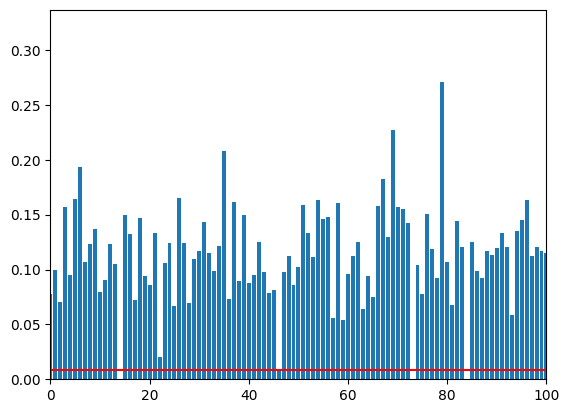

In [30]:
plt.bar(np.arange(y.shape[1]), np.max(y, axis=0))
plt.plot(np.arange(y.shape[1]), np.mean(y) * np.ones(y.shape[1]), c='r')
plt.xlim([0,100])

In [31]:
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# You would typically train one model per feature in y if you're trying to predict each feature independently
# Initialize an empty list to store models
losses_models = []

coeffs, losses_test, losses_train = [], [], []

# Loop over each feature in y
for i in tqdm(range(0, y.shape[-1])):
    # Initialize the Lasso model. You can adjust the alpha parameter to control the amount of regularization
    lasso = Lasso(alpha=1e-5, max_iter=1000)  # Example alpha, adjust based on your needs
    # lasso = LinearRegression()

    x_train, x_test, y_train, y_test = train_test_split(x, y[:, i], test_size=0.5) 

    # Fit the model to the data
    # Note: y[:, i] selects the i-th feature across all samples
    lasso.fit(x_train, y_train)

    y_pred = lasso.predict(x_test)
    test_loss = mean_squared_error(y_test, y_pred)
    losses_test.append(test_loss)

    y_pred = lasso.predict(x_train)
    train_loss = mean_squared_error(y_train, y_pred)
    losses_train.append(train_loss)

    print(f'Train: {train_loss},\tTest: {test_loss}')
    # Store the trained model
    coeffs.append(lasso.coef_)

  0%|          | 2/851 [00:00<02:10,  6.50it/s]

Train: 3.184784509357996e-05,	Test: 3.292749897809699e-05
Train: 4.130271190661006e-05,	Test: 4.173908746452071e-05


  0%|          | 3/851 [00:00<04:25,  3.20it/s]

Train: 2.980142926389817e-05,	Test: 3.039715375052765e-05


  0%|          | 4/851 [00:01<04:42,  2.99it/s]

Train: 0.00020969106117263436,	Test: 0.0002087044413201511
Train: 1.762214014888741e-05,	Test: 2.0029394363518804e-05


  1%|          | 7/851 [00:01<03:48,  3.70it/s]

Train: 0.0005771956057287753,	Test: 0.0005997097468934953
Train: 0.0001403162896167487,	Test: 0.00014223033213056624


  1%|          | 9/851 [00:02<03:03,  4.59it/s]

Train: 3.169910269207321e-05,	Test: 3.078140434809029e-05
Train: 7.934398308862001e-05,	Test: 8.457407966488972e-05


  1%|▏         | 11/851 [00:02<02:20,  6.00it/s]

Train: 0.00011026200809283182,	Test: 0.00011234606063226238
Train: 5.598784264293499e-05,	Test: 5.77486352995038e-05


  2%|▏         | 14/851 [00:02<01:40,  8.36it/s]

Train: 3.0693019652972e-05,	Test: 3.147341703879647e-05
Train: 2.833021426340565e-05,	Test: 3.1671741453465074e-05
Train: 5.387886267271824e-05,	Test: 5.61240449314937e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
  2%|▏         | 15/851 [00:05<09:10,  1.52it/s]

Train: 0.0,	Test: 0.0


  2%|▏         | 17/851 [00:05<05:57,  2.33it/s]

Train: 6.169568951008841e-05,	Test: 6.273765029618517e-05
Train: 5.5269560107262805e-05,	Test: 5.218255682848394e-05


  2%|▏         | 19/851 [00:05<04:06,  3.37it/s]

Train: 8.811289444565773e-05,	Test: 8.504631114192307e-05
Train: 6.403030420187861e-05,	Test: 6.613339064642787e-05


  3%|▎         | 22/851 [00:06<02:36,  5.30it/s]

Train: 3.532566552166827e-05,	Test: 3.470813680905849e-05
Train: 2.290477823407855e-05,	Test: 2.36603882513009e-05
Train: 7.777230348438025e-05,	Test: 8.049819734878838e-05


  3%|▎         | 24/851 [00:06<02:15,  6.10it/s]

Train: 8.541508833559419e-08,	Test: 1.159431874953043e-07
Train: 7.878491305746138e-05,	Test: 8.004684059415013e-05


  3%|▎         | 25/851 [00:06<02:17,  6.01it/s]

Train: 3.991030098404735e-05,	Test: 3.996918167104013e-05


  3%|▎         | 26/851 [00:06<02:47,  4.91it/s]

Train: 7.636567897861823e-05,	Test: 7.759439176879823e-05
Train: 5.905226862523705e-05,	Test: 5.860970850335434e-05


  3%|▎         | 29/851 [00:07<02:15,  6.08it/s]

Train: 4.646407614927739e-05,	Test: 4.786805948242545e-05
Train: 3.047549762413837e-05,	Test: 3.119614120805636e-05


  4%|▎         | 31/851 [00:07<01:59,  6.86it/s]

Train: 3.9966162148630247e-05,	Test: 3.985496368841268e-05
Train: 5.97630933043547e-05,	Test: 6.400927668437362e-05


  4%|▍         | 33/851 [00:07<02:03,  6.62it/s]

Train: 6.37393823126331e-05,	Test: 6.467357161454856e-05
Train: 0.0002578754210844636,	Test: 0.00026051970780827105


  4%|▍         | 35/851 [00:08<02:07,  6.40it/s]

Train: 6.431264046113938e-05,	Test: 6.697883509332314e-05
Train: 5.35081562702544e-05,	Test: 5.388124191085808e-05


  4%|▍         | 38/851 [00:08<01:35,  8.52it/s]

Train: 0.0003477154823485762,	Test: 0.000360536971129477
Train: 1.871550193754956e-05,	Test: 1.909030288516078e-05
Train: 8.232206164393574e-05,	Test: 8.300667104776949e-05


  5%|▍         | 40/851 [00:08<02:20,  5.75it/s]

Train: 0.00018390141485724598,	Test: 0.00019010882533621043
Train: 0.0003512878611218184,	Test: 0.0003539791505318135


  5%|▍         | 42/851 [00:09<01:55,  7.03it/s]

Train: 6.267126445891336e-05,	Test: 6.309977470664307e-05
Train: 5.702893759007566e-05,	Test: 6.014690734446049e-05


  5%|▌         | 43/851 [00:09<02:04,  6.51it/s]

Train: 0.00011085745791206136,	Test: 0.00011277404701104388


  5%|▌         | 45/851 [00:09<02:07,  6.32it/s]

Train: 3.852572990581393e-05,	Test: 3.982893758802675e-05
Train: 1.5551177057204768e-05,	Test: 1.610680737940129e-05


  6%|▌         | 48/851 [00:09<01:39,  8.08it/s]

Train: 3.742684202734381e-05,	Test: 3.880917574861087e-05
Train: 2.0114558907380342e-08,	Test: 2.554315514657901e-08
Train: 3.576597373466939e-05,	Test: 3.6756791814696044e-05


  6%|▌         | 50/851 [00:10<01:45,  7.61it/s]

Train: 4.2786858102772385e-05,	Test: 4.280520442989655e-05
Train: 5.108061304781586e-05,	Test: 5.138096457812935e-05


  6%|▌         | 52/851 [00:10<02:17,  5.82it/s]

Train: 0.00024517191923223436,	Test: 0.0002521695860195905
Train: 0.00010907663818215951,	Test: 0.00010910993296420202


  6%|▋         | 54/851 [00:11<02:18,  5.74it/s]

Train: 4.2476171074667946e-05,	Test: 4.3772906792582944e-05
Train: 9.861760918283835e-05,	Test: 9.969544043997303e-05


  6%|▋         | 55/851 [00:11<02:19,  5.70it/s]

Train: 0.00016756558034103364,	Test: 0.00017314172873739153


  7%|▋         | 57/851 [00:11<02:31,  5.23it/s]

Train: 0.00037355261156335473,	Test: 0.00038358510937541723
Train: 5.841623351443559e-05,	Test: 5.594415051746182e-05
Train: 1.9871415133820847e-05,	Test: 1.9738768969546072e-05


  7%|▋         | 59/851 [00:11<02:03,  6.41it/s]

Train: 0.00016444244829472154,	Test: 0.00016744145250413567
Train: 7.464294867531862e-06,	Test: 7.16573367753881e-06


  7%|▋         | 62/851 [00:12<01:53,  6.95it/s]

Train: 4.100702062714845e-05,	Test: 4.177543451078236e-05
Train: 0.00019513748702593148,	Test: 0.00019671328482218087


  7%|▋         | 63/851 [00:12<02:18,  5.70it/s]

Train: 0.00026079636882059276,	Test: 0.0002633087569847703
Train: 7.749339602014516e-06,	Test: 8.021594112506136e-06


  8%|▊         | 66/851 [00:13<02:17,  5.70it/s]

Train: 4.041203283122741e-05,	Test: 4.14766363974195e-05
Train: 2.4181174012483098e-05,	Test: 2.440162279526703e-05


  8%|▊         | 67/851 [00:13<02:20,  5.56it/s]

Train: 0.00023166491882875562,	Test: 0.0002391945308772847
Train: 0.00011123612785013393,	Test: 0.00011713717685779557


  8%|▊         | 69/851 [00:13<02:03,  6.34it/s]

Train: 0.00014185032341629267,	Test: 0.00014781802019570023


  8%|▊         | 71/851 [00:13<02:04,  6.27it/s]

Train: 0.0001370115642203018,	Test: 0.0001411368284607306
Train: 0.00011050800821976736,	Test: 0.00011550503404578194
Train: 0.00012991124822292477,	Test: 0.00013546101399697363


  9%|▊         | 73/851 [00:14<01:39,  7.80it/s]

Train: 2.1043233573436737e-05,	Test: 2.1994275812176056e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
  9%|▉         | 75/851 [00:16<06:16,  2.06it/s]

Train: 0.0,	Test: 0.0
Train: 4.534926119958982e-05,	Test: 4.3865198676940054e-05


  9%|▉         | 77/851 [00:16<04:30,  2.86it/s]

Train: 4.274408638593741e-05,	Test: 4.301652734284289e-05
Train: 0.000463089847471565,	Test: 0.00046554169966839254


  9%|▉         | 79/851 [00:17<03:04,  4.19it/s]

Train: 5.450850585475564e-05,	Test: 5.5067954235710204e-05
Train: 1.1075627298851032e-05,	Test: 1.2562085430545267e-05


 10%|▉         | 81/851 [00:17<02:35,  4.94it/s]

Train: 0.005443817935883999,	Test: 0.005565062630921602
Train: 4.191177504253574e-05,	Test: 4.376743527245708e-05


 10%|▉         | 83/851 [00:17<02:11,  5.86it/s]

Train: 4.0214643377112225e-05,	Test: 4.112159149372019e-05
Train: 9.795984078664333e-05,	Test: 9.924247569870204e-05


 10%|▉         | 84/851 [00:18<04:45,  2.68it/s]

Train: 0.00030395749490708113,	Test: 0.00031368451891466975


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 10%|█         | 86/851 [00:21<08:33,  1.49it/s]

Train: 0.0,	Test: 0.0
Train: 0.00019199843518435955,	Test: 0.00019353689276613295


 10%|█         | 88/851 [00:21<05:23,  2.36it/s]

Train: 1.0649286195985042e-05,	Test: 1.09752700154786e-05
Train: 4.719136268249713e-05,	Test: 4.690731657319702e-05


 11%|█         | 90/851 [00:21<03:51,  3.29it/s]

Train: 3.630739593063481e-05,	Test: 3.7718109524575993e-05
Train: 9.56611183937639e-05,	Test: 9.894325194181874e-05


 11%|█         | 92/851 [00:21<03:08,  4.02it/s]

Train: 6.61122176097706e-05,	Test: 7.17223301762715e-05
Train: 0.00012169386900495738,	Test: 0.00011849611473735422


 11%|█         | 94/851 [00:22<02:29,  5.07it/s]

Train: 0.00013841121108271182,	Test: 0.00013857267913408577
Train: 2.7178277377970517e-05,	Test: 2.6871000954997726e-05


 11%|█▏        | 96/851 [00:22<02:02,  6.16it/s]

Train: 4.1118419176200405e-05,	Test: 4.178097879048437e-05
Train: 0.00025486128288321197,	Test: 0.000264801929006353


 12%|█▏        | 98/851 [00:22<02:15,  5.56it/s]

Train: 0.00011283411731710657,	Test: 0.00011138174886582419
Train: 0.00020234806288499385,	Test: 0.00020907027646899223


 12%|█▏        | 99/851 [00:23<02:04,  6.02it/s]

Train: 7.558612560387701e-05,	Test: 7.503606320824474e-05


 12%|█▏        | 100/851 [00:23<02:27,  5.08it/s]

Train: 0.00012248674465809017,	Test: 0.00012309996236581355
Train: 6.362050771713257e-05,	Test: 6.620135536650196e-05


 12%|█▏        | 102/851 [00:23<02:08,  5.81it/s]

Train: 6.663416570518166e-05,	Test: 6.977937300689518e-05
Train: 0.00012126887304475531,	Test: 0.00012502829486038536


 12%|█▏        | 105/851 [00:24<02:21,  5.27it/s]

Train: 0.0002065365988528356,	Test: 0.00021247219410724938
Train: 0.00010899536573560908,	Test: 0.00011645728227449581


 13%|█▎        | 107/851 [00:24<01:52,  6.59it/s]

Train: 2.7291940568829887e-05,	Test: 2.2778513084631413e-05
Train: 0.00020809168927371502,	Test: 0.00021008682961110026


 13%|█▎        | 109/851 [00:24<01:52,  6.57it/s]

Train: 7.649892359040678e-05,	Test: 7.907401595730335e-05
Train: 2.5163806640193798e-05,	Test: 2.6078640075866133e-05


 13%|█▎        | 111/851 [00:25<01:44,  7.06it/s]

Train: 2.7506830519996583e-05,	Test: 2.7459673219709657e-05
Train: 4.167542647337541e-05,	Test: 4.282961890567094e-05


 13%|█▎        | 113/851 [00:25<01:45,  6.97it/s]

Train: 2.3890819647931494e-05,	Test: 2.3054190023685805e-05
Train: 0.00016900217451620847,	Test: 0.0001700571010587737


 13%|█▎        | 114/851 [00:25<01:51,  6.58it/s]

Train: 1.7537806343170814e-05,	Test: 1.7440230294596404e-05
Train: 3.4062562917824835e-05,	Test: 3.314190325909294e-05


 14%|█▎        | 116/851 [00:26<02:42,  4.52it/s]

Train: 0.0004298356652725488,	Test: 0.0004384790372569114


 14%|█▎        | 117/851 [00:26<03:30,  3.49it/s]

Train: 0.00014611998631153256,	Test: 0.00014776679745409638


 14%|█▍        | 119/851 [00:27<03:08,  3.88it/s]

Train: 0.00015633202565368265,	Test: 0.00015672882727812976
Train: 0.00010085314715979621,	Test: 0.00010237609967589378


 14%|█▍        | 121/851 [00:27<02:43,  4.46it/s]

Train: 0.000107000203570351,	Test: 0.00010620695684337988
Train: 6.073802069295198e-05,	Test: 6.184758967719972e-05


 14%|█▍        | 122/851 [00:27<02:23,  5.07it/s]

Train: 0.0001986836432479322,	Test: 0.00019568258721847087
Train: 3.24981301673688e-05,	Test: 3.792532152147032e-05


 15%|█▍        | 124/851 [00:27<02:25,  5.01it/s]

Train: 0.000263067486230284,	Test: 0.00027078355196863413


 15%|█▍        | 125/851 [00:28<02:29,  4.86it/s]

Train: 4.148234074818902e-05,	Test: 4.107832137378864e-05


 15%|█▍        | 127/851 [00:28<02:50,  4.24it/s]

Train: 0.000200531430891715,	Test: 0.00019677884120028466
Train: 2.0003930330858566e-05,	Test: 1.9947172404499725e-05


 15%|█▌        | 128/851 [00:29<02:46,  4.35it/s]

Train: 0.00010130945156561211,	Test: 0.00010263569856761023


 15%|█▌        | 129/851 [00:29<03:14,  3.72it/s]

Train: 0.0001473482116125524,	Test: 0.0001478818739997223


 15%|█▌        | 131/851 [00:29<03:01,  3.96it/s]

Train: 0.0004175727372057736,	Test: 0.0004287431656848639
Train: 7.507140253437683e-05,	Test: 7.683916919631884e-05


 16%|█▌        | 132/851 [00:30<02:46,  4.33it/s]

Train: 2.612395110190846e-05,	Test: 2.5138084311038256e-05


 16%|█▌        | 134/851 [00:30<02:43,  4.39it/s]

Train: 0.0002842794929165393,	Test: 0.0002883878187276423
Train: 6.305126589722931e-05,	Test: 7.102466042852029e-05


 16%|█▌        | 135/851 [00:30<02:26,  4.88it/s]

Train: 4.940786675433628e-05,	Test: 4.9097663577413186e-05
Train: 0.0001807873632060364,	Test: 0.00018375884974375367


 16%|█▋        | 139/851 [00:31<01:39,  7.13it/s]

Train: 5.09362798766233e-05,	Test: 5.376834815251641e-05
Train: 6.35033575235866e-05,	Test: 7.189147436292842e-05
Train: 9.40563313633902e-06,	Test: 1.0968659807986114e-05


 16%|█▋        | 140/851 [00:31<01:38,  7.20it/s]

Train: 2.742385186138563e-05,	Test: 2.926948400272522e-05


 17%|█▋        | 142/851 [00:31<01:51,  6.36it/s]

Train: 0.00015547654766123742,	Test: 0.00015973878907971084
Train: 2.5724109946168028e-05,	Test: 2.7324771508574486e-05


 17%|█▋        | 144/851 [00:32<02:06,  5.60it/s]

Train: 0.0002587091294117272,	Test: 0.00025579496286809444
Train: 0.00010518720227992162,	Test: 0.00010101543739438057


 17%|█▋        | 146/851 [00:32<02:20,  5.01it/s]

Train: 0.0003851994115393609,	Test: 0.0003789010806940496
Train: 3.815377931459807e-05,	Test: 3.915169509127736e-05


 17%|█▋        | 147/851 [00:32<02:12,  5.33it/s]

Train: 4.0042668842943385e-05,	Test: 3.96030955016613e-05


 17%|█▋        | 148/851 [00:33<02:21,  4.95it/s]

Train: 0.00013905955711379647,	Test: 0.00013583109830506146


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 18%|█▊        | 149/851 [00:35<08:54,  1.31it/s]

Train: 0.0,	Test: 0.0


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 18%|█▊        | 151/851 [00:37<09:54,  1.18it/s]

Train: 0.0,	Test: 0.0
Train: 0.00012834840163122863,	Test: 0.00013132364256307483


 18%|█▊        | 152/851 [00:37<07:32,  1.54it/s]

Train: 0.00023211570805869997,	Test: 0.00023696277639828622


 18%|█▊        | 154/851 [00:37<04:51,  2.39it/s]

Train: 6.471609231084585e-05,	Test: 6.524616765091196e-05
Train: 7.322122837649658e-05,	Test: 7.281709258677438e-05


 18%|█▊        | 156/851 [00:38<03:20,  3.46it/s]

Train: 0.0004974306793883443,	Test: 0.0004999732482247055
Train: 2.8312550057307817e-05,	Test: 3.047156860702671e-05


 18%|█▊        | 157/851 [00:38<03:02,  3.81it/s]

Train: 0.0002597142884042114,	Test: 0.0002648780937306583


 19%|█▊        | 158/851 [00:38<03:28,  3.32it/s]

Train: 0.0003327691520098597,	Test: 0.00033278026967309415


 19%|█▉        | 160/851 [00:39<02:54,  3.96it/s]

Train: 0.0003069412778131664,	Test: 0.00031167827546596527
Train: 3.9268186810659245e-05,	Test: 4.035725578432903e-05


 19%|█▉        | 162/851 [00:39<02:23,  4.79it/s]

Train: 0.00013749737991020083,	Test: 0.00014080965775065124
Train: 2.230356403742917e-05,	Test: 2.229364326922223e-05
Train: 3.551795816747472e-05,	Test: 3.5981145629193634e-05


 19%|█▉        | 165/851 [00:40<01:59,  5.72it/s]

Train: 0.00012747937580570579,	Test: 0.00013337566633708775
Train: 5.775172758148983e-05,	Test: 5.6805514759616926e-05


 20%|█▉        | 167/851 [00:40<01:52,  6.08it/s]

Train: 2.6112253181054257e-05,	Test: 2.688204222067725e-05
Train: 3.540249963407405e-05,	Test: 3.614244269556366e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 20%|█▉        | 169/851 [00:42<06:01,  1.89it/s]

Train: 0.0,	Test: 0.0
Train: 3.529417153913528e-05,	Test: 3.605173696996644e-05
Train: 9.486374619882554e-05,	Test: 0.00010226471204077825


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 20%|██        | 171/851 [00:44<08:12,  1.38it/s]

Train: 0.0,	Test: 0.0


 20%|██        | 173/851 [00:44<05:44,  1.97it/s]

Train: 5.923524804529734e-05,	Test: 5.946649253019132e-05
Train: 7.460470078513026e-05,	Test: 7.474491576431319e-05


 20%|██        | 174/851 [00:45<04:34,  2.47it/s]

Train: 5.5147924285847694e-05,	Test: 5.561108991969377e-05


 21%|██        | 177/851 [00:45<02:48,  4.00it/s]

Train: 0.00014386809198185802,	Test: 0.00014930529869161546
Train: 7.96520835137926e-05,	Test: 8.44535170472227e-05
Train: 0.00015145451470743865,	Test: 0.00015382221317850053


 21%|██        | 179/851 [00:45<02:27,  4.54it/s]

Train: 3.791229391936213e-05,	Test: 3.6665023799287155e-05
Train: 0.00024669471895322204,	Test: 0.00025095767341554165


 21%|██        | 180/851 [00:45<02:08,  5.23it/s]

Train: 8.609271753812209e-05,	Test: 8.455220813630149e-05


 21%|██▏       | 182/851 [00:46<01:56,  5.76it/s]

Train: 0.0001307286147493869,	Test: 0.00013324689643923193
Train: 2.3646549379918724e-05,	Test: 2.573165147623513e-05


 22%|██▏       | 183/851 [00:46<02:19,  4.80it/s]

Train: 0.00027565949130803347,	Test: 0.00028014153940603137


 22%|██▏       | 184/851 [00:46<02:22,  4.67it/s]

Train: 0.00019264162983745337,	Test: 0.00019356115080881864


 22%|██▏       | 186/851 [00:47<02:09,  5.13it/s]

Train: 0.00021946546621620655,	Test: 0.00023128368775360286
Train: 5.072699423180893e-05,	Test: 5.192261960473843e-05


 22%|██▏       | 188/851 [00:47<01:55,  5.76it/s]

Train: 3.1397066777572036e-05,	Test: 3.619860581238754e-05
Train: 4.689753404818475e-05,	Test: 4.814486237592064e-05


 22%|██▏       | 189/851 [00:47<01:43,  6.39it/s]

Train: 3.192499571014196e-05,	Test: 3.2116160582518205e-05
Train: 2.5218339942512102e-05,	Test: 2.6162259018747136e-05


 23%|██▎       | 192/851 [00:47<01:32,  7.12it/s]

Train: 0.00010526391270104796,	Test: 0.00010079208732349798
Train: 2.6911558961728588e-05,	Test: 2.7099655198981054e-05


 23%|██▎       | 194/851 [00:48<01:39,  6.60it/s]

Train: 0.00034190507722087204,	Test: 0.00034366772160865366
Train: 5.71856253372971e-05,	Test: 5.604600301012397e-05


 23%|██▎       | 196/851 [00:48<01:46,  6.13it/s]

Train: 3.338999522384256e-05,	Test: 3.358794856467284e-05
Train: 4.102209277334623e-05,	Test: 4.321545929997228e-05


 23%|██▎       | 197/851 [00:48<01:38,  6.63it/s]

Train: 8.596751285949722e-05,	Test: 8.771065040491521e-05


 23%|██▎       | 198/851 [00:49<02:12,  4.92it/s]

Train: 0.0001602966513019055,	Test: 0.00016550124564673752


 23%|██▎       | 199/851 [00:49<02:13,  4.90it/s]

Train: 0.0001178626116598025,	Test: 0.00012145100481575355
Train: 1.3444879186863545e-05,	Test: 1.1694899512804113e-05


 24%|██▎       | 202/851 [00:49<01:56,  5.59it/s]

Train: 0.00043275824282318354,	Test: 0.00044074180186726153
Train: 3.945501521229744e-05,	Test: 4.0397135308012366e-05


 24%|██▍       | 203/851 [00:49<01:50,  5.88it/s]

Train: 6.814180960645899e-05,	Test: 6.893122190376744e-05


 24%|██▍       | 204/851 [00:50<02:12,  4.88it/s]

Train: 6.54105533612892e-05,	Test: 6.757648952770978e-05


 24%|██▍       | 206/851 [00:50<02:09,  4.99it/s]

Train: 6.346236477838829e-05,	Test: 6.396673416020349e-05
Train: 0.00010860036127269268,	Test: 0.00010984194523189217


 24%|██▍       | 208/851 [00:50<01:44,  6.16it/s]

Train: 1.620559487491846e-05,	Test: 1.6741019862820394e-05
Train: 2.6986945158569142e-05,	Test: 2.7111816962133162e-05


 25%|██▍       | 211/851 [00:51<01:57,  5.43it/s]

Train: 9.975795546779409e-05,	Test: 0.00010220732656307518
Train: 1.2773426533385646e-05,	Test: 1.558247640787158e-05
Train: 0.00018017600814346224,	Test: 0.0001831548725022003


 25%|██▍       | 212/851 [00:51<01:47,  5.96it/s]

Train: 2.745347774180118e-05,	Test: 3.090300742769614e-05


 25%|██▌       | 213/851 [00:52<02:05,  5.07it/s]

Train: 0.0001708566560409963,	Test: 0.00017398755881004035


 25%|██▌       | 216/851 [00:52<01:43,  6.12it/s]

Train: 5.8651858125813305e-05,	Test: 5.885198697797023e-05
Train: 4.789787677594859e-09,	Test: 1.9111199289767455e-09
Train: 0.00014887942234054208,	Test: 0.00015667876868974417


 25%|██▌       | 217/851 [00:52<01:52,  5.65it/s]

Train: 2.834701990650501e-05,	Test: 2.838827458617743e-05
Train: 0.0002893574710469693,	Test: 0.00029998307581990957


 26%|██▌       | 220/851 [00:53<01:28,  7.10it/s]

Train: 4.527998680714518e-05,	Test: 4.590238677337766e-05
Train: 3.205898610758595e-05,	Test: 3.246969572501257e-05
Train: 1.7458340153098106e-05,	Test: 1.956167398020625e-05


 26%|██▌       | 223/851 [00:53<01:52,  5.56it/s]

Train: 0.0003472516546025872,	Test: 0.000358592631528154
Train: 5.398839493864216e-05,	Test: 5.6700991990510374e-05


 26%|██▋       | 224/851 [00:53<01:52,  5.57it/s]

Train: 4.738147617899813e-05,	Test: 4.814996646018699e-05


 27%|██▋       | 226/851 [00:54<02:05,  4.99it/s]

Train: 0.00010584027040749788,	Test: 0.00010646868031471968
Train: 3.3914104278665036e-05,	Test: 3.401768481126055e-05


 27%|██▋       | 229/851 [00:54<01:35,  6.49it/s]

Train: 6.517312431242317e-05,	Test: 6.691501766908914e-05
Train: 1.253942059520341e-06,	Test: 1.2670370779233053e-06
Train: 3.446295886533335e-05,	Test: 3.56474811269436e-05


 27%|██▋       | 230/851 [00:55<01:55,  5.36it/s]

Train: 0.00019295330275781453,	Test: 0.0001991206663660705


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 27%|██▋       | 231/851 [00:57<07:04,  1.46it/s]

Train: 0.0,	Test: 6.497227644786108e-08


 27%|██▋       | 233/851 [00:57<04:33,  2.26it/s]

Train: 4.1054208850255236e-05,	Test: 4.16886578022968e-05
Train: 2.223514275101479e-05,	Test: 2.1422623831313103e-05
Train: 2.3633777157527902e-09,	Test: 8.163370831095265e-14


 28%|██▊       | 236/851 [00:57<02:37,  3.91it/s]

Train: 4.862594354948513e-11,	Test: 1.572484920053796e-10
Train: 0.000551150063984096,	Test: 0.0005636948044411838


 28%|██▊       | 238/851 [00:58<02:08,  4.76it/s]

Train: 0.0013245393056422472,	Test: 0.0013542533852159977
Train: 5.20885041623842e-05,	Test: 4.857318344875239e-05


 28%|██▊       | 239/851 [00:58<02:02,  5.01it/s]

Train: 2.668646084202919e-05,	Test: 2.8166361516923644e-05


 28%|██▊       | 241/851 [00:58<02:11,  4.65it/s]

Train: 0.00025664843269623816,	Test: 0.00026918991352431476
Train: 6.531055987579748e-05,	Test: 6.417297845473513e-05


 28%|██▊       | 242/851 [00:59<02:03,  4.95it/s]

Train: 0.00011754203296732157,	Test: 0.00012095707643311471
Train: 0.00012148480163887143,	Test: 0.00011623962927842513


 29%|██▉       | 245/851 [00:59<01:44,  5.82it/s]

Train: 4.3225059926044196e-05,	Test: 4.291301956982352e-05
Train: 1.7163520169560798e-05,	Test: 1.751189847709611e-05


 29%|██▉       | 247/851 [00:59<01:31,  6.59it/s]

Train: 7.282549631781876e-05,	Test: 7.557516801171005e-05
Train: 1.97550962184323e-05,	Test: 1.9688204702106304e-05


 29%|██▉       | 248/851 [01:00<01:47,  5.63it/s]

Train: 0.0003139328327961266,	Test: 0.0003262402315158397


 29%|██▉       | 249/851 [01:00<02:36,  3.85it/s]

Train: 0.00038301138556562364,	Test: 0.00039665005169808865


 29%|██▉       | 251/851 [01:00<02:23,  4.17it/s]

Train: 0.0002021042164415121,	Test: 0.0002004464331548661
Train: 0.0001877298636827618,	Test: 0.00018984593043569475


 30%|██▉       | 253/851 [01:01<02:31,  3.94it/s]

Train: 0.0002608353679534048,	Test: 0.00026879727374762297
Train: 9.609568223822862e-05,	Test: 9.632673754822463e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 30%|███       | 256/851 [01:03<04:21,  2.28it/s]

Train: 0.0,	Test: 4.84350649865295e-11
Train: 1.1205436749150977e-05,	Test: 1.1017025826731697e-05
Train: 5.62572167837061e-05,	Test: 6.178270268719643e-05


 30%|███       | 257/851 [01:03<03:45,  2.64it/s]

Train: 0.00013830699026584625,	Test: 0.0001394520077155903


 30%|███       | 258/851 [01:04<03:36,  2.73it/s]

Train: 0.00019408823573030531,	Test: 0.00019935825548600405


 31%|███       | 260/851 [01:04<02:48,  3.50it/s]

Train: 0.00016603933181613684,	Test: 0.0001690788776613772
Train: 0.0003341829578857869,	Test: 0.00034373434027656913


 31%|███       | 263/851 [01:04<01:46,  5.53it/s]

Train: 0.0001874852750916034,	Test: 0.00019637055811472237
Train: 5.547287946683355e-05,	Test: 5.249841706245206e-05
Train: 2.8832799216615967e-05,	Test: 2.7493329980643466e-05


 31%|███       | 264/851 [01:05<01:40,  5.82it/s]

Train: 5.845735358889215e-05,	Test: 5.9981040976708755e-05


 31%|███▏      | 267/851 [01:05<01:33,  6.26it/s]

Train: 0.000266848539467901,	Test: 0.00027121268794871867
Train: 1.3967176528240088e-05,	Test: 1.3937758922111243e-05
Train: 0.00017427308193873614,	Test: 0.000178209287696518


 32%|███▏      | 269/851 [01:05<01:33,  6.21it/s]

Train: 1.7143205695901997e-05,	Test: 1.6916254026000388e-05
Train: 3.478799044387415e-05,	Test: 3.6039873521076515e-05


 32%|███▏      | 272/851 [01:06<01:06,  8.74it/s]

Train: 8.577419794164598e-05,	Test: 9.829357441049069e-05
Train: 6.704279076075181e-05,	Test: 6.476802082033828e-05
Train: 5.804018599064875e-09,	Test: 1.2473142518842906e-08


 32%|███▏      | 274/851 [01:06<01:08,  8.38it/s]

Train: 1.7405629478162155e-05,	Test: 1.7591635696589947e-05
Train: 0.00018915730470325798,	Test: 0.0001893168082460761


 32%|███▏      | 276/851 [01:06<01:08,  8.33it/s]

Train: 1.8685354007175192e-05,	Test: 1.8748822185443714e-05
Train: 2.8305874366196804e-05,	Test: 2.8892853151774034e-05


 33%|███▎      | 277/851 [01:06<01:20,  7.17it/s]

Train: 5.7687651860760525e-05,	Test: 5.851334208273329e-05


 33%|███▎      | 280/851 [01:07<01:33,  6.09it/s]

Train: 0.0004044382367283106,	Test: 0.00040766960592009127
Train: 4.676900644540183e-08,	Test: 3.1340093187282037e-08
Train: 1.6282980141113512e-05,	Test: 1.6438580132671632e-05


 33%|███▎      | 281/851 [01:07<01:39,  5.74it/s]

Train: 0.00017360280617140234,	Test: 0.00016969977878034115
Train: 2.602502888748859e-07,	Test: 9.770516129492535e-08


 33%|███▎      | 283/851 [01:07<01:25,  6.61it/s]

Train: 6.881875015096739e-05,	Test: 6.90281594870612e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 33%|███▎      | 284/851 [01:09<05:15,  1.80it/s]

Train: 0.0,	Test: 0.0


 34%|███▎      | 286/851 [01:10<03:48,  2.47it/s]

Train: 0.0004546628915704787,	Test: 0.00045427546137943864
Train: 8.072601485764608e-05,	Test: 8.255800639744848e-05


 34%|███▎      | 287/851 [01:10<03:23,  2.77it/s]

Train: 0.00026785285444930196,	Test: 0.00027436588425189257


 34%|███▍      | 290/851 [01:10<02:05,  4.46it/s]

Train: 0.00023808864352758974,	Test: 0.00023567512107547373
Train: 6.609944102820009e-05,	Test: 6.631164433201775e-05
Train: 4.3029933294747025e-05,	Test: 4.6822628064546734e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 34%|███▍      | 291/851 [01:12<05:48,  1.61it/s]

Train: 0.0,	Test: 2.7332731633578078e-09
Train: 0.00011387585254851729,	Test: 0.00012135339056840166


 35%|███▍      | 294/851 [01:13<03:16,  2.84it/s]

Train: 6.108936941018328e-05,	Test: 6.988862878642976e-05
Train: 0.00011221024760743603,	Test: 0.00011406165867811069


 35%|███▍      | 296/851 [01:13<02:33,  3.63it/s]

Train: 5.8979519963031635e-05,	Test: 5.898550807614811e-05
Train: 4.673464718507603e-05,	Test: 4.66893361590337e-05


 35%|███▌      | 298/851 [01:13<01:50,  4.99it/s]

Train: 1.5027302069370307e-08,	Test: 4.59063098645629e-09
Train: 3.35261102009099e-05,	Test: 3.4031203540507704e-05


 35%|███▌      | 300/851 [01:14<02:05,  4.38it/s]

Train: 0.00023073438205756247,	Test: 0.00023724055790808052
Train: 0.0001155463105533272,	Test: 0.0001190471593872644


 35%|███▌      | 302/851 [01:14<01:33,  5.87it/s]

Train: 3.063871190533973e-05,	Test: 3.108584132860415e-05
Train: 5.531266288016923e-05,	Test: 5.597451308858581e-05


 36%|███▌      | 304/851 [01:14<01:35,  5.71it/s]

Train: 0.0003447687195148319,	Test: 0.00034228875301778316
Train: 0.00029694754630327225,	Test: 0.00029821539646945894


 36%|███▌      | 306/851 [01:15<01:43,  5.28it/s]

Train: 0.0004628778842743486,	Test: 0.000467357924208045
Train: 3.0531395168509334e-05,	Test: 3.137671228614636e-05


 36%|███▌      | 307/851 [01:15<02:05,  4.34it/s]

Train: 0.00030921294819563627,	Test: 0.00032077496871352196
Train: 2.7161157049704343e-05,	Test: 2.7435940864961594e-05


 36%|███▋      | 310/851 [01:16<01:35,  5.68it/s]

Train: 0.0002855452767107636,	Test: 0.0003005894541274756
Train: 2.330677853024099e-05,	Test: 2.2973081286181696e-05


 37%|███▋      | 312/851 [01:16<01:34,  5.71it/s]

Train: 0.00011841857485705987,	Test: 0.00012034337851218879
Train: 0.00017989793559536338,	Test: 0.0001810386311262846


 37%|███▋      | 314/851 [01:16<01:34,  5.71it/s]

Train: 6.613751611439511e-05,	Test: 6.956216384423897e-05
Train: 0.0006015955004841089,	Test: 0.0006029973737895489


 37%|███▋      | 316/851 [01:17<01:30,  5.90it/s]

Train: 0.00026167978649027646,	Test: 0.000267999799689278
Train: 0.00017438852228224277,	Test: 0.00017895438941195607


 37%|███▋      | 317/851 [01:17<01:50,  4.83it/s]

Train: 0.00033937484840862453,	Test: 0.0003465218178462237


 37%|███▋      | 319/851 [01:17<01:49,  4.84it/s]

Train: 0.00023831349972169846,	Test: 0.0002391475427430123
Train: 8.240029274020344e-05,	Test: 8.596210682298988e-05


 38%|███▊      | 321/851 [01:18<01:22,  6.46it/s]

Train: 4.012786303064786e-05,	Test: 4.0805130993248895e-05
Train: 0.00011719539907062426,	Test: 0.00012634045560844243


 38%|███▊      | 323/851 [01:18<01:13,  7.23it/s]

Train: 0.00040348898619413376,	Test: 0.00041146916919387877
Train: 4.5620774471899495e-05,	Test: 4.810992322745733e-05


 38%|███▊      | 325/851 [01:18<01:08,  7.72it/s]

Train: 1.4059759450901765e-05,	Test: 1.448829334549373e-05
Train: 0.00012118029553676024,	Test: 0.00012602421338669956


 38%|███▊      | 327/851 [01:18<01:15,  6.94it/s]

Train: 0.0002008092706091702,	Test: 0.00020056954235769808
Train: 0.00017982393910642713,	Test: 0.00018278273637406528


 39%|███▊      | 328/851 [01:19<01:20,  6.53it/s]

Train: 3.948933590436354e-05,	Test: 4.168550731264986e-05


 39%|███▊      | 329/851 [01:19<01:32,  5.63it/s]

Train: 0.0003099931636825204,	Test: 0.0003154051082674414


 39%|███▉      | 330/851 [01:19<01:47,  4.83it/s]

Train: 0.0003003352612722665,	Test: 0.0003071496030315757


 39%|███▉      | 331/851 [01:19<02:07,  4.09it/s]

Train: 0.000101532852568198,	Test: 9.808630420593545e-05


 39%|███▉      | 332/851 [01:20<02:05,  4.14it/s]

Train: 0.00012600650370586663,	Test: 0.00012555527791846544


 39%|███▉      | 334/851 [01:20<01:56,  4.45it/s]

Train: 0.0002227032819064334,	Test: 0.0002299126936122775
Train: 4.6907611249480397e-05,	Test: 4.8116846301127225e-05
Train: 1.3382416000240482e-05,	Test: 1.1690821338561364e-05


 39%|███▉      | 336/851 [01:20<01:27,  5.86it/s]

Train: 5.2128500101389363e-05,	Test: 5.376352783059701e-05


 40%|███▉      | 338/851 [01:21<01:27,  5.87it/s]

Train: 0.0005567497573792934,	Test: 0.0005715871229767799
Train: 3.386576645425521e-05,	Test: 3.654587271739729e-05


 40%|███▉      | 339/851 [01:21<02:06,  4.04it/s]

Train: 0.00012041255104122683,	Test: 0.00012143654748797417


 40%|███▉      | 340/851 [01:22<02:13,  3.81it/s]

Train: 0.00010826922516571358,	Test: 0.00011157408152939752


 40%|████      | 342/851 [01:22<02:37,  3.24it/s]

Train: 0.00031690901960246265,	Test: 0.0003251185407862067
Train: 2.223263891210081e-06,	Test: 2.0851421140832826e-06


 40%|████      | 343/851 [01:23<02:30,  3.38it/s]

Train: 0.00025859559536911547,	Test: 0.0002670360845513642


 40%|████      | 344/851 [01:23<02:38,  3.19it/s]

Train: 9.393483196618035e-05,	Test: 9.686140401754528e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 41%|████      | 345/851 [01:25<07:13,  1.17it/s]

Train: 0.0,	Test: 0.0


 41%|████      | 346/851 [01:25<05:35,  1.50it/s]

Train: 0.00010403630585642532,	Test: 0.0001060955401044339


 41%|████      | 348/851 [01:26<03:28,  2.41it/s]

Train: 5.0186674343422055e-05,	Test: 5.184438850847073e-05
Train: 2.8899301469209604e-05,	Test: 2.9173632356105372e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 41%|████      | 350/851 [01:28<05:31,  1.51it/s]

Train: 0.0,	Test: 0.0
Train: 3.095768261118792e-05,	Test: 3.124076101812534e-05


 41%|████▏     | 352/851 [01:28<03:22,  2.47it/s]

Train: 0.0001059079950209707,	Test: 0.00010922650108113885
Train: 7.025022205198184e-05,	Test: 7.129355071811005e-05


 41%|████▏     | 353/851 [01:28<02:53,  2.86it/s]

Train: 0.00012502331810537726,	Test: 0.0001297319686273113


 42%|████▏     | 355/851 [01:29<02:07,  3.90it/s]

Train: 0.00018636473396327347,	Test: 0.00019028638780582696
Train: 0.0001176484947791323,	Test: 0.00012296380009502172


 42%|████▏     | 357/851 [01:29<01:31,  5.40it/s]

Train: 2.736927490332164e-05,	Test: 2.6486015485716052e-05
Train: 3.288802690804005e-05,	Test: 3.306403959868476e-05


 42%|████▏     | 359/851 [01:29<01:21,  6.04it/s]

Train: 3.818301411229186e-05,	Test: 3.760039180633612e-05
Train: 3.37657293130178e-05,	Test: 3.5023265809286386e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 42%|████▏     | 361/851 [01:31<04:28,  1.83it/s]

Train: 0.0,	Test: 0.0
Train: 3.587089668144472e-05,	Test: 3.6687804822577164e-05


 43%|████▎     | 363/851 [01:32<02:58,  2.74it/s]

Train: 0.0001359221205348149,	Test: 0.00013573812611866742
Train: 2.1150079192011617e-05,	Test: 2.1692307200282812e-05


 43%|████▎     | 364/851 [01:32<02:19,  3.50it/s]

Train: 8.758687908994034e-05,	Test: 8.882445399649441e-05


 43%|████▎     | 365/851 [01:32<02:18,  3.50it/s]

Train: 5.847544161952101e-05,	Test: 6.124725041445345e-05


 43%|████▎     | 368/851 [01:33<02:04,  3.86it/s]

Train: 0.00024695531465113163,	Test: 0.0002516085223760456
Train: 0.00012942939065396786,	Test: 0.00013360666343942285
Train: 2.8164191462565213e-05,	Test: 2.794264037220273e-05


 43%|████▎     | 370/851 [01:33<01:52,  4.29it/s]

Train: 0.00025712433853186667,	Test: 0.0002570835640653968
Train: 0.0042891306802630424,	Test: 0.004331530537456274


 44%|████▎     | 372/851 [01:34<01:28,  5.43it/s]

Train: 1.0644179383234587e-05,	Test: 1.0738195669546258e-05
Train: 3.506011125864461e-05,	Test: 3.622681470005773e-05


 44%|████▍     | 373/851 [01:34<01:36,  4.95it/s]

Train: 8.433617767877877e-05,	Test: 8.913264173315838e-05


 44%|████▍     | 375/851 [01:34<01:34,  5.03it/s]

Train: 0.00012696691555902362,	Test: 0.00013016772572882473
Train: 4.983744292985648e-05,	Test: 5.2109571697656065e-05


 44%|████▍     | 377/851 [01:35<01:23,  5.65it/s]

Train: 5.851035894011147e-05,	Test: 5.964648516965099e-05
Train: 3.182892396580428e-05,	Test: 3.1743016734253615e-05


 45%|████▍     | 379/851 [01:35<01:25,  5.52it/s]

Train: 0.00018719417857937515,	Test: 0.00019164805416949093
Train: 2.9955865102238022e-05,	Test: 3.2306536013493314e-05


 45%|████▍     | 381/851 [01:36<01:33,  5.05it/s]

Train: 7.760213338769972e-05,	Test: 7.851611007936299e-05
Train: 6.121349724708125e-05,	Test: 6.13357697147876e-05


 45%|████▌     | 383/851 [01:36<01:15,  6.17it/s]

Train: 4.95327367389109e-05,	Test: 4.916562102152966e-05
Train: 4.918930426356383e-05,	Test: 4.664731750381179e-05


 45%|████▌     | 384/851 [01:36<01:17,  6.04it/s]

Train: 0.00015308798174373806,	Test: 0.00015803183487150818


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 45%|████▌     | 386/851 [01:38<04:08,  1.87it/s]

Train: 0.0,	Test: 8.695563713523313e-11
Train: 0.00015778026136104017,	Test: 0.00016026200319174677


 46%|████▌     | 388/851 [01:38<02:43,  2.84it/s]

Train: 0.0002366348635405302,	Test: 0.0002350390568608418
Train: 2.8497870516730472e-05,	Test: 2.8254360586288385e-05
Train: 1.6652786143822595e-05,	Test: 1.8097996871802025e-05


 46%|████▌     | 392/851 [01:39<01:19,  5.80it/s]

Train: 5.398300695347302e-10,	Test: 6.484116021887587e-10
Train: 7.855103831388988e-06,	Test: 7.325627848331351e-06
Train: 3.845270475721918e-05,	Test: 4.0238159272121266e-05


 46%|████▋     | 394/851 [01:39<01:12,  6.34it/s]

Train: 6.314253550954163e-05,	Test: 7.039939373498783e-05
Train: 0.0003517230798024684,	Test: 0.000357863144017756


 47%|████▋     | 396/851 [01:39<01:14,  6.07it/s]

Train: 0.00011210951925022528,	Test: 0.0001125644994317554
Train: 5.851823516422883e-05,	Test: 5.974297528155148e-05


 47%|████▋     | 397/851 [01:40<01:14,  6.09it/s]

Train: 6.944023334654048e-05,	Test: 6.903194298502058e-05
Train: 4.804427953786217e-05,	Test: 4.83706098748371e-05


 47%|████▋     | 399/851 [01:40<01:14,  6.05it/s]

Train: 0.0002085114538203925,	Test: 0.00020851737644989043
Train: 0.00013097065675538033,	Test: 0.00013531855074688792


 47%|████▋     | 402/851 [01:40<01:10,  6.39it/s]

Train: 3.814838783000596e-05,	Test: 3.880439908243716e-05
Train: 1.8241058569401503e-05,	Test: 1.849879299697932e-05
Train: 4.430306944414042e-05,	Test: 4.353565236669965e-05


 47%|████▋     | 404/851 [01:41<00:54,  8.16it/s]

Train: 4.6769880412966813e-08,	Test: 7.545580871237689e-08


 48%|████▊     | 406/851 [01:41<01:14,  5.94it/s]

Train: 0.000134339090436697,	Test: 0.00013851486437488347
Train: 9.307666914537549e-05,	Test: 9.930315718520433e-05


 48%|████▊     | 409/851 [01:41<01:01,  7.17it/s]

Train: 7.518051279475912e-05,	Test: 7.974820618983358e-05
Train: 6.253981700865552e-05,	Test: 6.415089592337608e-05
Train: 5.987486656522378e-05,	Test: 5.693247658200562e-05


 48%|████▊     | 411/851 [01:42<01:09,  6.32it/s]

Train: 0.0002839783555828035,	Test: 0.00029053533216938376
Train: 0.00010007961100200191,	Test: 0.00010270805796608329


 49%|████▊     | 413/851 [01:42<01:06,  6.60it/s]

Train: 0.00020062011026311666,	Test: 0.00019425185746513307
Train: 2.240174580947496e-05,	Test: 2.4342405595234595e-05


 49%|████▉     | 415/851 [01:42<00:54,  7.93it/s]

Train: 1.6569882063777186e-05,	Test: 1.5970317690516822e-05
Train: 2.4308410502271727e-05,	Test: 2.6918489311356097e-05


 49%|████▉     | 417/851 [01:43<01:02,  6.95it/s]

Train: 9.990744001697749e-05,	Test: 0.00010249211482005194
Train: 9.768807649379596e-05,	Test: 9.904247417580336e-05


 49%|████▉     | 419/851 [01:43<00:57,  7.52it/s]

Train: 3.2684918551240116e-05,	Test: 3.425330214668065e-05
Train: 0.0001607036974746734,	Test: 0.00015571506810374558


 49%|████▉     | 421/851 [01:43<01:08,  6.28it/s]

Train: 8.801841613603756e-05,	Test: 9.0050081780646e-05
Train: 5.341511496226303e-05,	Test: 5.508475442184135e-05


 50%|████▉     | 422/851 [01:43<01:06,  6.48it/s]

Train: 0.00011105904559371993,	Test: 0.0001124096306739375


 50%|████▉     | 424/851 [01:44<01:17,  5.54it/s]

Train: 0.00021747982827946544,	Test: 0.00021448392362799495
Train: 3.522491533658467e-05,	Test: 3.751710755750537e-05


 50%|█████     | 426/851 [01:45<01:49,  3.88it/s]

Train: 0.0006042395834811032,	Test: 0.0006397521938197315
Train: 4.6933182602515444e-05,	Test: 4.64323275082279e-05


 50%|█████     | 428/851 [01:45<01:28,  4.78it/s]

Train: 0.0004868003015872091,	Test: 0.0004841661429964006
Train: 7.740542787360027e-05,	Test: 7.817029836587608e-05


 51%|█████     | 430/851 [01:45<01:37,  4.33it/s]

Train: 0.00027532243984751403,	Test: 0.00027220899937674403
Train: 0.0004208151949569583,	Test: 0.00042097078403458


 51%|█████     | 432/851 [01:46<01:29,  4.69it/s]

Train: 0.0002997583942487836,	Test: 0.00029484822880476713
Train: 7.867295789765194e-05,	Test: 7.990731683094054e-05


 51%|█████     | 434/851 [01:46<01:12,  5.74it/s]

Train: 1.695638093224261e-05,	Test: 1.7996928363572806e-05
Train: 4.495108441915363e-05,	Test: 4.401299884193577e-05


 51%|█████     | 436/851 [01:46<01:12,  5.73it/s]

Train: 4.736753908218816e-05,	Test: 4.909972631139681e-05
Train: 8.099050319287926e-05,	Test: 8.262057235697284e-05


 51%|█████▏    | 438/851 [01:47<01:12,  5.69it/s]

Train: 6.096907236496918e-05,	Test: 6.304571434156969e-05
Train: 3.177852340741083e-05,	Test: 3.382310751476325e-05


 52%|█████▏    | 440/851 [01:47<01:02,  6.57it/s]

Train: 5.399172005127184e-05,	Test: 5.423221955425106e-05
Train: 7.534025644417852e-05,	Test: 7.565678970422596e-05


 52%|█████▏    | 441/851 [01:47<01:01,  6.68it/s]

Train: 5.9411617257865146e-05,	Test: 6.075810597394593e-05


 52%|█████▏    | 443/851 [01:48<01:08,  5.95it/s]

Train: 0.00025277514941990376,	Test: 0.00026311518740840256
Train: 2.687008054635953e-05,	Test: 2.9643086236319505e-05


 52%|█████▏    | 445/851 [01:48<00:55,  7.38it/s]

Train: 1.555177764345217e-09,	Test: 5.3717596234896525e-14
Train: 9.417538421985228e-06,	Test: 9.685037184681278e-06


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 53%|█████▎    | 447/851 [01:50<03:29,  1.93it/s]

Train: 0.0,	Test: 0.0
Train: 5.494640936376527e-05,	Test: 5.664292984874919e-05


 53%|█████▎    | 448/851 [01:50<02:45,  2.44it/s]

Train: 7.257921970449388e-05,	Test: 7.321139855775982e-05
Train: 3.098235372683139e-13,	Test: 1.2809195926166694e-09


 53%|█████▎    | 451/851 [01:51<01:51,  3.59it/s]

Train: 0.0002890658797696233,	Test: 0.00028924402431584895
Train: 0.00017110184126067907,	Test: 0.0001721255830489099


 53%|█████▎    | 453/851 [01:51<01:28,  4.47it/s]

Train: 0.00023959051759447902,	Test: 0.00024843530263751745
Train: 3.721385292010382e-05,	Test: 4.276965046301484e-05


 53%|█████▎    | 455/851 [01:51<01:12,  5.46it/s]

Train: 6.065873458283022e-05,	Test: 6.0290250985417515e-05
Train: 3.058891888940707e-05,	Test: 3.0559138394892216e-05


 54%|█████▎    | 456/851 [01:52<01:09,  5.67it/s]

Train: 4.761648960993625e-05,	Test: 5.102959767100401e-05


 54%|█████▍    | 458/851 [01:52<01:10,  5.58it/s]

Train: 0.00017280690371990204,	Test: 0.00017668335931375623
Train: 1.6498948752996512e-05,	Test: 1.4137833204586059e-05


 54%|█████▍    | 459/851 [01:52<01:08,  5.76it/s]

Train: 3.702841422636993e-05,	Test: 3.71538735635113e-05


 54%|█████▍    | 460/851 [01:52<01:13,  5.29it/s]

Train: 0.0006343947607092559,	Test: 0.0006332980119623244


 54%|█████▍    | 461/851 [01:53<01:20,  4.87it/s]

Train: 6.861099973320961e-05,	Test: 6.85355335008353e-05


 54%|█████▍    | 463/851 [01:53<01:15,  5.14it/s]

Train: 7.307528721867129e-05,	Test: 7.410961552523077e-05
Train: 5.247620356385596e-05,	Test: 5.47142954019364e-05


 55%|█████▍    | 465/851 [01:53<01:05,  5.90it/s]

Train: 5.305981176206842e-05,	Test: 5.3681978897657245e-05
Train: 8.504084689775482e-05,	Test: 8.448772132396698e-05


 55%|█████▍    | 468/851 [01:54<00:48,  7.92it/s]

Train: 9.232043521478772e-05,	Test: 9.134257561527193e-05
Train: 3.310640749987215e-05,	Test: 3.6154244298813865e-05
Train: 7.320042641367763e-05,	Test: 7.428008393617347e-05


 55%|█████▌    | 469/851 [01:54<00:51,  7.40it/s]

Train: 4.346907007857226e-05,	Test: 4.468125189305283e-05


 55%|█████▌    | 471/851 [01:54<01:11,  5.30it/s]

Train: 0.0005145362811163068,	Test: 0.000528621778357774
Train: 9.656490874476731e-05,	Test: 9.635336027713493e-05


 56%|█████▌    | 473/851 [01:55<01:05,  5.79it/s]

Train: 9.785295696929097e-05,	Test: 0.00010105956607731059
Train: 3.022564487764612e-05,	Test: 3.0212573619792238e-05


 56%|█████▌    | 474/851 [01:55<01:06,  5.68it/s]

Train: 4.019443804281764e-05,	Test: 4.391417314764112e-05
Train: 0.00014697006554342806,	Test: 0.00014776631724089384


 56%|█████▌    | 476/851 [01:55<01:00,  6.18it/s]

Train: 0.000190990132978186,	Test: 0.00019204594718758017


 56%|█████▌    | 478/851 [01:56<01:07,  5.56it/s]

Train: 9.205673995893449e-05,	Test: 9.316228533862159e-05
Train: 9.904456965159625e-05,	Test: 0.00010189228487433866


 56%|█████▋    | 480/851 [01:56<01:03,  5.81it/s]

Train: 8.160296420101076e-05,	Test: 8.489404717693105e-05
Train: 5.93674267292954e-05,	Test: 6.0515689256135374e-05


 57%|█████▋    | 482/851 [01:56<00:53,  6.90it/s]

Train: 0.00011144480959046632,	Test: 0.0001126480201492086
Train: 2.542669426475186e-05,	Test: 2.6782945496961474e-05


 57%|█████▋    | 483/851 [01:56<00:53,  6.83it/s]

Train: 6.013664824422449e-05,	Test: 5.89050687267445e-05
Train: 3.602822471293621e-05,	Test: 3.838096745312214e-05


 57%|█████▋    | 487/851 [01:57<00:43,  8.31it/s]

Train: 0.0002967823820654303,	Test: 0.0002955759991891682
Train: 3.2910909794736654e-05,	Test: 3.3308846468571573e-05
Train: 2.3058390070218593e-05,	Test: 2.413697620795574e-05


 58%|█████▊    | 490/851 [01:57<00:37,  9.59it/s]

Train: 1.5765481293783523e-05,	Test: 1.677233558439184e-05
Train: 3.983507849625312e-05,	Test: 4.0926792280515656e-05
Train: 2.8792601369787008e-05,	Test: 2.961557220260147e-05


 58%|█████▊    | 492/851 [01:57<00:45,  7.83it/s]

Train: 4.107377753825858e-05,	Test: 4.193415952613577e-05
Train: 4.630353214452043e-05,	Test: 5.029214298701845e-05


 58%|█████▊    | 494/851 [01:58<00:45,  7.86it/s]

Train: 5.518659600056708e-05,	Test: 5.56553786736913e-05
Train: 4.7682744479971007e-05,	Test: 4.644059663405642e-05


 58%|█████▊    | 495/851 [01:58<00:52,  6.73it/s]

Train: 0.0001554507907712832,	Test: 0.00015638594049960375
Train: 2.932862662419211e-05,	Test: 3.1422772735822946e-05


 59%|█████▊    | 498/851 [01:58<00:50,  7.05it/s]

Train: 0.00019631678878795356,	Test: 0.0001945661351783201
Train: 4.151355096837506e-05,	Test: 4.2917065002257004e-05


 59%|█████▉    | 501/851 [01:58<00:37,  9.25it/s]

Train: 4.629511386156082e-05,	Test: 4.8050496843643486e-05
Train: 4.719258868135512e-05,	Test: 4.54467699455563e-05
Train: 9.157483873423189e-07,	Test: 7.402008463941456e-07


 59%|█████▉    | 503/851 [01:59<00:42,  8.21it/s]

Train: 4.347847425378859e-05,	Test: 4.5218221202958375e-05
Train: 9.562509512761608e-05,	Test: 9.395936649525538e-05


 59%|█████▉    | 505/851 [01:59<00:49,  6.98it/s]

Train: 7.39778479328379e-05,	Test: 7.420049951178953e-05
Train: 0.00013052753638476133,	Test: 0.00012822986172977835


 60%|█████▉    | 507/851 [01:59<00:46,  7.46it/s]

Train: 4.931220973958261e-05,	Test: 5.0462247600080445e-05
Train: 0.00016091106226667762,	Test: 0.0001662174763623625


 60%|█████▉    | 509/851 [02:00<00:53,  6.38it/s]

Train: 4.104421168449335e-05,	Test: 4.076192999491468e-05
Train: 5.142558438819833e-05,	Test: 5.322519791661762e-05


 60%|██████    | 511/851 [02:00<00:46,  7.34it/s]

Train: 8.360100764548406e-05,	Test: 8.551864448236302e-05
Train: 3.5164317523594946e-05,	Test: 3.558251410140656e-05


 60%|██████    | 512/851 [02:00<00:43,  7.81it/s]

Train: 6.637063779635355e-05,	Test: 6.66984124109149e-05


 60%|██████    | 514/851 [02:00<00:49,  6.79it/s]

Train: 0.00034740654518827796,	Test: 0.0003551034606061876
Train: 3.729070886038244e-05,	Test: 3.8884249079274014e-05


 61%|██████    | 515/851 [02:01<00:58,  5.75it/s]

Train: 0.0003263368271291256,	Test: 0.000331385264871642


 61%|██████    | 518/851 [02:01<00:45,  7.38it/s]

Train: 0.0007007975364103913,	Test: 0.0007121461094357073
Train: 1.6507703548995778e-05,	Test: 1.538262949907221e-05
Train: 4.5787783164996654e-05,	Test: 4.4228872866369784e-05


 61%|██████    | 520/851 [02:01<00:45,  7.29it/s]

Train: 0.00020809061243198812,	Test: 0.000224220086238347
Train: 0.0003017005219589919,	Test: 0.0003053771215490997


 61%|██████▏   | 523/851 [02:02<00:40,  8.18it/s]

Train: 0.00017170284991152585,	Test: 0.0001715256366878748
Train: 8.599959255661815e-05,	Test: 9.090745152207091e-05
Train: 0.00013341728481464088,	Test: 0.00013806165952701122


 62%|██████▏   | 525/851 [02:02<00:35,  9.07it/s]

Train: 6.540698814205825e-05,	Test: 6.813724030507728e-05
Train: 4.0547318349126726e-05,	Test: 4.025445014121942e-05
Train: 2.4856959498720244e-05,	Test: 2.5903358618961647e-05


 62%|██████▏   | 528/851 [02:02<00:41,  7.87it/s]

Train: 9.264548134524375e-05,	Test: 9.656841575633734e-05
Train: 0.00021675694733858109,	Test: 0.00021390440815594047


 62%|██████▏   | 530/851 [02:03<00:48,  6.65it/s]

Train: 0.00025208681472577155,	Test: 0.0002581442822702229
Train: 0.0001492427400080487,	Test: 0.0001586225553182885


 62%|██████▏   | 531/851 [02:03<00:44,  7.25it/s]

Train: 9.528938244329765e-05,	Test: 9.658095223130658e-05
Train: 3.5162844142178074e-05,	Test: 3.305495192762464e-05


 63%|██████▎   | 533/851 [02:03<00:44,  7.18it/s]

Train: 0.00012919736036565155,	Test: 0.00013151636812835932
Train: 7.698257832089439e-05,	Test: 7.842436752980575e-05


 63%|██████▎   | 535/851 [02:03<00:45,  7.00it/s]

Train: 0.0001338933507213369,	Test: 0.0001378663000650704
Train: 3.862381709041074e-05,	Test: 3.98802112613339e-05


 63%|██████▎   | 537/851 [02:04<00:45,  6.91it/s]

Train: 0.00037619174690917134,	Test: 0.0003765164001379162


 63%|██████▎   | 538/851 [02:04<00:49,  6.34it/s]

Train: 0.000162415555678308,	Test: 0.00016710517229512334


 63%|██████▎   | 539/851 [02:04<00:56,  5.51it/s]

Train: 0.00016994863108266145,	Test: 0.0001711184304440394
Train: 4.106368717282649e-11,	Test: 1.5996766411507934e-10


 64%|██████▎   | 542/851 [02:04<00:44,  6.87it/s]

Train: 0.00013554403267335147,	Test: 0.0001339754235232249
Train: 5.012039400753565e-05,	Test: 4.9906757340068e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 64%|██████▍   | 544/851 [02:06<02:21,  2.17it/s]

Train: 0.0,	Test: 0.0
Train: 4.220820119371638e-05,	Test: 4.284440728952177e-05
Train: 9.86382074188441e-05,	Test: 9.846766624832526e-05


 64%|██████▍   | 546/851 [02:07<01:39,  3.06it/s]

Train: 0.00012034222891088575,	Test: 0.00012310662714298815


 65%|██████▍   | 549/851 [02:07<01:05,  4.63it/s]

Train: 0.00010849872342078015,	Test: 0.00011079270916525275
Train: 1.483712185290642e-05,	Test: 1.546728344692383e-05
Train: 6.72151509206742e-05,	Test: 7.225514855235815e-05


 65%|██████▍   | 550/851 [02:07<00:59,  5.08it/s]

Train: 3.143851790810004e-05,	Test: 3.197347541572526e-05


 65%|██████▍   | 553/851 [02:08<00:47,  6.30it/s]

Train: 0.0001382342161377892,	Test: 0.0001416120067005977
Train: 1.3722297808271833e-05,	Test: 1.3172476428735536e-05
Train: 3.5457665944704786e-05,	Test: 3.853960151900537e-05


 65%|██████▌   | 554/851 [02:08<00:43,  6.82it/s]

Train: 4.2351544834673405e-05,	Test: 4.381196777103469e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 65%|██████▌   | 556/851 [02:10<02:14,  2.20it/s]

Train: 0.0,	Test: 1.3767585682611383e-10
Train: 5.2059098379686475e-05,	Test: 5.468732342706062e-05


 66%|██████▌   | 558/851 [02:10<01:35,  3.05it/s]

Train: 0.0002880336542148143,	Test: 0.00029145603184588253
Train: 0.00020094633509870619,	Test: 0.00020431070879567415


 66%|██████▌   | 559/851 [02:10<01:16,  3.80it/s]

Train: 8.941288979258388e-05,	Test: 9.381581912748516e-05


 66%|██████▌   | 561/851 [02:11<01:04,  4.50it/s]

Train: 0.00028222627588547766,	Test: 0.0002869534364435822
Train: 1.6977082850644365e-05,	Test: 1.901919131341856e-05
Train: 8.008759323274717e-05,	Test: 7.069585990393534e-05


 66%|██████▋   | 564/851 [02:11<00:51,  5.56it/s]

Train: 3.709635348059237e-05,	Test: 3.6459539842326194e-05
Train: 6.733022019034252e-05,	Test: 6.737895455444232e-05


 66%|██████▋   | 565/851 [02:11<00:46,  6.10it/s]

Train: 1.7722051779855974e-05,	Test: 1.8128714145859703e-05


 67%|██████▋   | 566/851 [02:11<00:55,  5.12it/s]

Train: 0.00034480864997021854,	Test: 0.0003510457172524184
Train: 9.480966400587931e-05,	Test: 9.91380657069385e-05


 67%|██████▋   | 568/851 [02:12<00:45,  6.29it/s]

Train: 4.32940578320995e-05,	Test: 4.50522820756305e-05


 67%|██████▋   | 570/851 [02:12<00:50,  5.56it/s]

Train: 0.00047252303920686245,	Test: 0.0004828519595321268
Train: 2.436048089293763e-05,	Test: 2.388575921941083e-05


 67%|██████▋   | 571/851 [02:12<00:44,  6.28it/s]

Train: 0.00010695987293729559,	Test: 0.00010266164463246241


 67%|██████▋   | 574/851 [02:13<00:38,  7.12it/s]

Train: 0.00036186835495755076,	Test: 0.0003733883786480874
Train: 0.00014841293159406632,	Test: 0.00014415703481063247
Train: 0.0001138700608862564,	Test: 0.00011719657777575776


 68%|██████▊   | 576/851 [02:13<00:39,  6.91it/s]

Train: 9.711317397886887e-05,	Test: 9.695063636172563e-05
Train: 8.25686875032261e-05,	Test: 8.459093078272417e-05


 68%|██████▊   | 577/851 [02:13<00:38,  7.21it/s]

Train: 3.121517875115387e-05,	Test: 3.3161824831040576e-05
Train: 0.00010348608338972554,	Test: 0.00011064257705584168


 68%|██████▊   | 581/851 [02:14<00:36,  7.30it/s]

Train: 0.0005456755752675235,	Test: 0.0005650673992931843
Train: 0.00014133131480775774,	Test: 0.00014118787657935172
Train: 5.3158779337536544e-05,	Test: 5.284646249492653e-05


 69%|██████▊   | 583/851 [02:14<00:33,  8.07it/s]

Train: 4.783588883583434e-05,	Test: 4.7303321480285376e-05
Train: 2.485115510353353e-05,	Test: 2.5514847948215902e-05


 69%|██████▉   | 586/851 [02:14<00:26,  9.95it/s]

Train: 3.2686682970961556e-05,	Test: 3.322561315144412e-05
Train: 4.564287155517377e-05,	Test: 4.873799116467126e-05
Train: 5.9594072808977216e-05,	Test: 6.0520640545291826e-05


 69%|██████▉   | 588/851 [02:14<00:30,  8.71it/s]

Train: 3.884020043187775e-05,	Test: 3.964773713960312e-05
Train: 3.710374221554957e-05,	Test: 3.560824552550912e-05


 69%|██████▉   | 591/851 [02:15<00:28,  9.24it/s]

Train: 5.7943172578234226e-05,	Test: 5.6266002502525225e-05
Train: 1.6578052964177914e-05,	Test: 1.4927370102668647e-05
Train: 4.5517084799939767e-05,	Test: 4.6722318074898794e-05


 70%|██████▉   | 593/851 [02:15<00:34,  7.58it/s]

Train: 0.00016518859774805605,	Test: 0.00016858406888786703
Train: 3.6182140320306644e-05,	Test: 3.597888280637562e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 70%|██████▉   | 595/851 [02:17<01:53,  2.25it/s]

Train: 0.0,	Test: 0.0
Train: 3.120675319223665e-05,	Test: 3.313230263302103e-05


 70%|███████   | 597/851 [02:17<01:16,  3.32it/s]

Train: 0.0003832151705864817,	Test: 0.00038955523632466793
Train: 0.00010158227087231353,	Test: 9.954319102689624e-05


 70%|███████   | 599/851 [02:18<00:53,  4.68it/s]

Train: 0.00010086973634315655,	Test: 0.00010244546865578741
Train: 0.00011821353109553456,	Test: 0.00011781897774199024


 71%|███████   | 601/851 [02:18<00:41,  5.97it/s]

Train: 4.17207193095237e-05,	Test: 4.741453813039698e-05
Train: 0.0002645557397045195,	Test: 0.0002699173055589199


 71%|███████   | 603/851 [02:18<00:38,  6.47it/s]

Train: 8.158397395163774e-05,	Test: 7.90756312198937e-05
Train: 0.00037268141750246286,	Test: 0.0003745729918591678


 71%|███████   | 605/851 [02:18<00:37,  6.61it/s]

Train: 2.7620202672551386e-05,	Test: 2.7268573830951937e-05
Train: 6.372905772877857e-05,	Test: 6.349377508740872e-05


 71%|███████   | 606/851 [02:19<00:55,  4.42it/s]

Train: 0.00034919148311018944,	Test: 0.0003527411899995059
Train: 8.351093856617808e-05,	Test: 8.767992403591052e-05


 71%|███████▏  | 608/851 [02:19<00:43,  5.62it/s]

Train: 5.793188029201701e-05,	Test: 5.930304905632511e-05
Train: 9.285421401727945e-05,	Test: 9.44583589443937e-05


 72%|███████▏  | 612/851 [02:20<00:31,  7.58it/s]

Train: 6.604236841667444e-05,	Test: 7.15654605301097e-05
Train: 8.925688598537818e-05,	Test: 9.105171193368733e-05
Train: 0.0001366094802506268,	Test: 0.00014091978664509952


 72%|███████▏  | 614/851 [02:20<00:34,  6.94it/s]

Train: 0.00011488002928672358,	Test: 0.00012005431926809251
Train: 4.0802977309795097e-05,	Test: 4.479483322938904e-05


 72%|███████▏  | 616/851 [02:20<00:33,  7.03it/s]

Train: 0.0001236843818333,	Test: 0.00012271894956938922
Train: 7.21964897820726e-05,	Test: 7.018801261438057e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 73%|███████▎  | 618/851 [02:22<01:58,  1.96it/s]

Train: 0.0,	Test: 0.0
Train: 8.390984294237569e-05,	Test: 8.3313396316953e-05


 73%|███████▎  | 619/851 [02:22<01:30,  2.55it/s]

Train: 3.790398477576673e-05,	Test: 3.920782546629198e-05


 73%|███████▎  | 620/851 [02:23<01:18,  2.93it/s]

Train: 3.6436646041693166e-05,	Test: 3.818849290837534e-05


 73%|███████▎  | 622/851 [02:23<01:07,  3.37it/s]

Train: 5.155258986633271e-05,	Test: 5.046049409429543e-05
Train: 8.284315845230594e-05,	Test: 8.525909652234986e-05


 73%|███████▎  | 624/851 [02:23<00:44,  5.11it/s]

Train: 4.6283377741929144e-05,	Test: 4.5906093873782083e-05
Train: 8.311155397677794e-05,	Test: 8.786380203673616e-05


 74%|███████▎  | 627/851 [02:24<00:30,  7.39it/s]

Train: 8.796112524578348e-05,	Test: 9.086103818845004e-05
Train: 0.00013243374996818602,	Test: 0.00013419787865132093
Train: 1.6953225667748484e-06,	Test: 2.0829047571169212e-06


 74%|███████▍  | 629/851 [02:24<00:33,  6.71it/s]

Train: 5.957621760899201e-05,	Test: 6.170459528220817e-05
Train: 0.00011533673387020826,	Test: 0.00011684730998240411


 74%|███████▍  | 631/851 [02:24<00:26,  8.38it/s]

Train: 0.00011973966320510954,	Test: 0.00012675431207753718
Train: 2.6233163225697353e-05,	Test: 2.7637617677100934e-05


 74%|███████▍  | 633/851 [02:24<00:27,  8.01it/s]

Train: 3.7994683225406334e-05,	Test: 3.962797927670181e-05
Train: 8.324649388669059e-05,	Test: 8.438001532340422e-05


 75%|███████▍  | 634/851 [02:24<00:26,  8.04it/s]

Train: 0.00010873746941797435,	Test: 0.00011290460679447278
Train: 4.9975060392171144e-05,	Test: 5.1112354412907735e-05


 75%|███████▍  | 636/851 [02:25<00:25,  8.59it/s]

Train: 0.00011018810619134456,	Test: 0.00011235014972044155


 75%|███████▍  | 637/851 [02:25<00:30,  7.01it/s]

Train: 8.782286022324115e-05,	Test: 8.905387949198484e-05
Train: 9.528869850328192e-05,	Test: 0.00010142591781914234


 75%|███████▌  | 640/851 [02:25<00:27,  7.57it/s]

Train: 0.00010081736400024965,	Test: 0.00010353024845244363
Train: 4.8179204895859584e-05,	Test: 4.9141697672894225e-05


 75%|███████▌  | 642/851 [02:26<00:29,  7.16it/s]

Train: 0.00012974620040040463,	Test: 0.00012968759983778
Train: 0.00011867513239849359,	Test: 0.00013009164831601083


 76%|███████▌  | 644/851 [02:26<00:30,  6.83it/s]

Train: 0.0002160884323529899,	Test: 0.000226519099669531
Train: 0.0001454238226870075,	Test: 0.00014420961088035256


 76%|███████▌  | 647/851 [02:26<00:27,  7.54it/s]

Train: 0.0002444173442199826,	Test: 0.0002459471579641104
Train: 3.327707599964924e-05,	Test: 3.378974724910222e-05
Train: 4.027092654723674e-05,	Test: 3.987755917478353e-05


 76%|███████▋  | 649/851 [02:27<00:31,  6.49it/s]

Train: 0.00014137821563053876,	Test: 0.00014589156489819288
Train: 2.4867065803846344e-05,	Test: 2.48439591814531e-05


 76%|███████▋  | 650/851 [02:27<00:28,  6.98it/s]

Train: 7.818372250767425e-05,	Test: 8.01254718680866e-05


 77%|███████▋  | 652/851 [02:27<00:39,  5.00it/s]

Train: 0.0005940364208072424,	Test: 0.0006154818693175912
Train: 0.00015514911501668394,	Test: 0.0001579731033416465


 77%|███████▋  | 655/851 [02:28<00:27,  7.10it/s]

Train: 3.025137812073808e-05,	Test: 3.1199651857605204e-05
Train: 3.259490767959505e-05,	Test: 3.1587918783770874e-05
Train: 8.221330790547654e-05,	Test: 9.082765609491616e-05


 77%|███████▋  | 658/851 [02:28<00:22,  8.58it/s]

Train: 5.146471448824741e-05,	Test: 5.4514977819053456e-05
Train: 3.055862180190161e-05,	Test: 3.38768440997228e-05
Train: 2.330770257685799e-05,	Test: 2.448923623887822e-05


 78%|███████▊  | 660/851 [02:28<00:27,  6.91it/s]

Train: 0.00012503091420512646,	Test: 0.0001369516976410523
Train: 0.00014864320110064,	Test: 0.0001512959715910256


 78%|███████▊  | 662/851 [02:29<00:25,  7.35it/s]

Train: 2.6926423743134364e-05,	Test: 2.778866473818198e-05
Train: 3.606559039326385e-05,	Test: 3.7368645280366763e-05


 78%|███████▊  | 663/851 [02:29<00:28,  6.70it/s]

Train: 6.75636765663512e-05,	Test: 6.957124423934147e-05
Train: 4.479585913941264e-05,	Test: 4.136650750297122e-05


 78%|███████▊  | 666/851 [02:29<00:32,  5.68it/s]

Train: 8.61409935168922e-05,	Test: 8.62838642206043e-05
Train: 0.00023325064103119075,	Test: 0.00024119090812746435


 78%|███████▊  | 668/851 [02:30<00:35,  5.22it/s]

Train: 0.00022550745052285492,	Test: 0.00023601048451382667
Train: 0.00021416723029688,	Test: 0.00021855249360669404


 79%|███████▊  | 670/851 [02:30<00:30,  6.01it/s]

Train: 2.6261173843522556e-05,	Test: 2.7435104129835963e-05
Train: 0.0001006806269288063,	Test: 0.00010334831313230097


 79%|███████▉  | 672/851 [02:30<00:24,  7.31it/s]

Train: 3.8143225538078696e-05,	Test: 4.01629731641151e-05
Train: 0.00012756016803905368,	Test: 0.00012682679516728967


 79%|███████▉  | 674/851 [02:31<00:24,  7.11it/s]

Train: 6.618809857172891e-05,	Test: 6.818366819061339e-05
Train: 0.00029866566183045506,	Test: 0.0003015637048520148


 79%|███████▉  | 676/851 [02:31<00:23,  7.31it/s]

Train: 5.65912268939428e-05,	Test: 5.6388467783108354e-05
Train: 7.899489719420671e-05,	Test: 8.028843149077147e-05


 80%|███████▉  | 678/851 [02:31<00:24,  6.95it/s]

Train: 6.781558477086946e-05,	Test: 6.728402513545007e-05
Train: 2.760319875960704e-05,	Test: 2.776962901407387e-05


 80%|███████▉  | 679/851 [02:31<00:23,  7.21it/s]

Train: 4.399679892230779e-05,	Test: 4.449417974683456e-05


 80%|████████  | 681/851 [02:32<00:26,  6.52it/s]

Train: 0.00020369159756228328,	Test: 0.0002122304867953062
Train: 2.255890467495192e-05,	Test: 2.36681335081812e-05


 80%|████████  | 683/851 [02:32<00:23,  7.06it/s]

Train: 0.00027914735255762935,	Test: 0.0002818530483637005
Train: 7.410993566736579e-05,	Test: 7.459288462996483e-05


 80%|████████  | 685/851 [02:32<00:21,  7.65it/s]

Train: 3.3976964914472774e-05,	Test: 3.472189564490691e-05
Train: 5.8769743191078305e-05,	Test: 6.043288885848597e-05


 81%|████████  | 687/851 [02:32<00:21,  7.78it/s]

Train: 3.442826709942892e-05,	Test: 3.43552055710461e-05
Train: 3.696160274557769e-05,	Test: 3.7265232094796374e-05
Train: 6.978483725106344e-05,	Test: 7.887545507401228e-05


 81%|████████  | 690/851 [02:33<00:23,  6.86it/s]

Train: 5.140459688846022e-05,	Test: 5.220041566644795e-05
Train: 0.00047202754649333656,	Test: 0.00047355107381008565


 81%|████████▏ | 692/851 [02:33<00:23,  6.86it/s]

Train: 2.346727706026286e-05,	Test: 2.2708522010361776e-05
Train: 0.0002691223344299942,	Test: 0.0002747894322965294


 81%|████████▏ | 693/851 [02:33<00:23,  6.70it/s]

Train: 0.00013738965208176523,	Test: 0.00014470249880105257
Train: 2.19458215724444e-05,	Test: 2.2866734070703387e-05


 82%|████████▏ | 695/851 [02:33<00:20,  7.52it/s]

Train: 3.869711508741602e-05,	Test: 3.8844507798785344e-05


 82%|████████▏ | 697/851 [02:34<00:24,  6.28it/s]

Train: 0.00021897099213674664,	Test: 0.0002188387152273208
Train: 0.0001768825459294021,	Test: 0.00018460546561982483


 82%|████████▏ | 699/851 [02:34<00:20,  7.27it/s]

Train: 0.00016439623141195625,	Test: 0.00016798064461909235
Train: 0.00010561337694525719,	Test: 0.00010560213559074327


 82%|████████▏ | 701/851 [02:34<00:22,  6.59it/s]

Train: 0.00037256773794069886,	Test: 0.00037950018304400146
Train: 6.309508171398193e-05,	Test: 6.531724648084491e-05


 83%|████████▎ | 704/851 [02:35<00:21,  6.99it/s]

Train: 0.00011942837591050193,	Test: 0.00012258010974619538
Train: 6.035969636286609e-05,	Test: 6.231509178178385e-05
Train: 4.5690059778280556e-05,	Test: 4.857369276578538e-05


 83%|████████▎ | 706/851 [02:35<00:19,  7.25it/s]

Train: 3.6547851777868345e-05,	Test: 3.747981463675387e-05
Train: 7.031794666545466e-05,	Test: 7.080894283717498e-05


 83%|████████▎ | 707/851 [02:35<00:26,  5.43it/s]

Train: 0.0001141773464041762,	Test: 0.00011611402442213148


 83%|████████▎ | 709/851 [02:36<00:31,  4.50it/s]

Train: 0.00012345731374807656,	Test: 0.00012568884994834661
Train: 0.000408968364354223,	Test: 0.000422890909248963


 84%|████████▎ | 712/851 [02:36<00:22,  6.08it/s]

Train: 0.0001494253083365038,	Test: 0.00015952486137393862
Train: 1.8139373423764482e-05,	Test: 1.8613003703649156e-05
Train: 7.998648652574047e-05,	Test: 7.427314267260954e-05


 84%|████████▍ | 714/851 [02:37<00:19,  6.93it/s]

Train: 4.804603668162599e-05,	Test: 5.1017384976148605e-05
Train: 2.740000309131574e-05,	Test: 2.7140416932525113e-05


 84%|████████▍ | 715/851 [02:37<00:18,  7.52it/s]

Train: 9.713825420476496e-05,	Test: 0.00010248902253806591
Train: 0.00014594002277590334,	Test: 0.0001528020657133311


 84%|████████▍ | 717/851 [02:37<00:16,  7.94it/s]

Train: 3.4458535083103925e-05,	Test: 3.422858571866527e-05
Train: 1.2354658792901319e-05,	Test: 1.1789878954004962e-05


 85%|████████▍ | 720/851 [02:37<00:18,  7.27it/s]

Train: 0.00016928196419030428,	Test: 0.00017747773381415755
Train: 0.00016473719733767211,	Test: 0.00016227923333644867


 85%|████████▍ | 722/851 [02:38<00:16,  7.81it/s]

Train: 4.128185901208781e-05,	Test: 3.9385227864841e-05
Train: 4.683904262492433e-05,	Test: 4.743595854961313e-05


 85%|████████▍ | 723/851 [02:38<00:17,  7.24it/s]

Train: 6.823842704761773e-05,	Test: 6.902025052113459e-05


 85%|████████▌ | 724/851 [02:38<00:20,  6.14it/s]

Train: 0.00024104266776703298,	Test: 0.00024319686053786427


 85%|████████▌ | 726/851 [02:38<00:21,  5.91it/s]

Train: 3.394127998035401e-05,	Test: 3.390717756701633e-05
Train: 0.00013865319488104433,	Test: 0.00014089375326875597
Train: 5.874192993360339e-06,	Test: 5.535034233616898e-06


 86%|████████▌ | 729/851 [02:39<00:20,  5.97it/s]

Train: 0.00019280039123259485,	Test: 0.00019096107280347496
Train: 8.192496170522645e-05,	Test: 8.21645517135039e-05


 86%|████████▌ | 730/851 [02:39<00:20,  6.01it/s]

Train: 4.368274312582798e-05,	Test: 4.419836841407232e-05
Train: 1.2708900612778962e-05,	Test: 1.1447614269854967e-05


 86%|████████▌ | 733/851 [02:40<00:19,  6.10it/s]

Train: 9.332987247034907e-05,	Test: 9.626320388633758e-05
Train: 0.0005484247230924666,	Test: 0.0005461989785544574


 86%|████████▋ | 735/851 [02:40<00:19,  5.96it/s]

Train: 7.391076360363513e-05,	Test: 7.39732786314562e-05
Train: 8.047559822443873e-05,	Test: 8.078405517153442e-05


 87%|████████▋ | 737/851 [02:40<00:16,  7.08it/s]

Train: 7.917262701084837e-05,	Test: 8.146090840455145e-05
Train: 7.393905252683908e-05,	Test: 7.318094867514446e-05


 87%|████████▋ | 738/851 [02:40<00:14,  7.64it/s]

Train: 4.3812484364025295e-05,	Test: 4.506920595304109e-05


 87%|████████▋ | 740/851 [02:41<00:23,  4.82it/s]

Train: 0.00033281001378782094,	Test: 0.00033970145159401
Train: 0.00015239717322401702,	Test: 0.00015307418652810156


 87%|████████▋ | 741/851 [02:41<00:22,  4.82it/s]

Train: 0.00012767665612045676,	Test: 0.00013468024553731084


 87%|████████▋ | 743/851 [02:41<00:19,  5.43it/s]

Train: 8.107620669761673e-05,	Test: 8.011638419702649e-05
Train: 3.402096263016574e-05,	Test: 3.547401138348505e-05


 88%|████████▊ | 745/851 [02:42<00:17,  6.10it/s]

Train: 1.5174473446677439e-05,	Test: 1.5000395251263399e-05
Train: 6.123841740190983e-05,	Test: 6.390459020622075e-05


 88%|████████▊ | 747/851 [02:42<00:16,  6.43it/s]

Train: 0.00023156090173870325,	Test: 0.0002375344338361174
Train: 0.0001277952251257375,	Test: 0.00012927205534651875
Train: 9.445412433706224e-05,	Test: 9.59800454438664e-05


 88%|████████▊ | 751/851 [02:42<00:10,  9.28it/s]

Train: 2.7504880151241196e-08,	Test: 1.582571584890502e-08
Train: 7.896017632447183e-05,	Test: 8.107842586468905e-05
Train: 7.51856277929619e-05,	Test: 7.813726551830769e-05


 88%|████████▊ | 753/851 [02:43<00:15,  6.30it/s]

Train: 0.00017821579240262508,	Test: 0.0001774221600499004
Train: 2.7865422453032807e-05,	Test: 2.8842057872680016e-05


 89%|████████▊ | 755/851 [02:43<00:15,  6.36it/s]

Train: 4.220129630994052e-05,	Test: 4.3191135773668066e-05
Train: 2.7813746783067472e-05,	Test: 2.7534331820788793e-05


 89%|████████▉ | 757/851 [02:43<00:13,  6.99it/s]

Train: 0.00010890672274399549,	Test: 0.00011131310020573437
Train: 3.321110125398263e-05,	Test: 3.3843203709693626e-05


 89%|████████▉ | 758/851 [02:44<00:12,  7.64it/s]

Train: 2.438258525216952e-05,	Test: 2.4623641365906224e-05


 89%|████████▉ | 759/851 [02:44<00:14,  6.53it/s]

Train: 9.21122555155307e-05,	Test: 9.333247726317495e-05


 89%|████████▉ | 761/851 [02:44<00:14,  6.12it/s]

Train: 0.00027293222956359386,	Test: 0.0002823563409037888
Train: 4.4553180487127975e-05,	Test: 4.65786833956372e-05


 90%|████████▉ | 763/851 [02:44<00:12,  7.30it/s]

Train: 6.426649633795023e-05,	Test: 6.580983608728275e-05
Train: 4.4693770178128034e-05,	Test: 4.683059887611307e-05


 90%|████████▉ | 765/851 [02:45<00:13,  6.60it/s]

Train: 5.0176593504147604e-05,	Test: 5.166218033991754e-05
Train: 5.418128057499416e-05,	Test: 5.645638157147914e-05
Train: 1.0973426469718106e-05,	Test: 1.1666518730635289e-05


 90%|█████████ | 768/851 [02:45<00:10,  7.99it/s]

Train: 5.3217783715808764e-05,	Test: 5.397306085797027e-05
Train: 4.202177660772577e-05,	Test: 4.1537921788403764e-05


 90%|█████████ | 770/851 [02:45<00:10,  7.43it/s]

Train: 3.7858371797483414e-05,	Test: 3.804096922976896e-05
Train: 9.027672786032781e-05,	Test: 9.006462641991675e-05


 91%|█████████ | 772/851 [02:46<00:11,  7.04it/s]

Train: 6.768111052224413e-05,	Test: 6.75744959153235e-05
Train: 3.9304701203946024e-05,	Test: 3.884120815200731e-05


 91%|█████████ | 773/851 [02:46<00:10,  7.41it/s]

Train: 2.4733519239816815e-05,	Test: 2.4724658942432143e-05
Train: 2.511164711904712e-05,	Test: 2.478496935509611e-05


 91%|█████████ | 776/851 [02:46<00:09,  8.29it/s]

Train: 5.2539031457854435e-05,	Test: 5.375172622734681e-05
Train: 6.651212061115075e-06,	Test: 6.149031378299696e-06


 91%|█████████▏| 777/851 [02:46<00:09,  7.63it/s]

Train: 0.000430952844908461,	Test: 0.0004416613664943725
Train: 7.282137084985152e-05,	Test: 7.315197581192479e-05


 92%|█████████▏| 780/851 [02:47<00:10,  7.05it/s]

Train: 8.449094457319006e-05,	Test: 8.359922503586859e-05
Train: 5.566107574850321e-05,	Test: 5.858374424860813e-05


 92%|█████████▏| 782/851 [02:47<00:08,  7.75it/s]

Train: 3.113370985374786e-05,	Test: 3.098524030065164e-05
Train: 0.0001006928359856829,	Test: 0.00010807725630002096


 92%|█████████▏| 784/851 [02:47<00:10,  6.22it/s]

Train: 0.0003220606886316091,	Test: 0.0003343150019645691
Train: 0.002960921498015523,	Test: 0.0030256961472332478


 92%|█████████▏| 787/851 [02:48<00:07,  8.06it/s]

Train: 2.4307864805450663e-05,	Test: 2.452802800689824e-05
Train: 2.9320503017515875e-05,	Test: 2.708820284169633e-05
Train: 3.178438782924786e-05,	Test: 3.2956864743027836e-05


 93%|█████████▎| 789/851 [02:48<00:06,  9.26it/s]

Train: 1.7435049812775105e-05,	Test: 1.7156909962068312e-05
Train: 3.4799857530742884e-05,	Test: 3.563761492841877e-05
Train: 2.602355925773736e-05,	Test: 2.448642044328153e-05


 93%|█████████▎| 793/851 [02:48<00:05, 10.27it/s]

Train: 8.30532080726698e-05,	Test: 8.166656334651634e-05
Train: 3.489335722406395e-05,	Test: 3.622724398155697e-05
Train: 5.5285734561039135e-05,	Test: 5.461678301799111e-05
Train: 0.00032191129866987467,	Test: 0.00032161627314053476


 94%|█████████▎| 796/851 [02:49<00:06,  8.04it/s]

Train: 4.826589793083258e-05,	Test: 4.952343078912236e-05
Train: 2.2331421860144474e-05,	Test: 2.3496906578657217e-05
Train: 4.9793579819379374e-06,	Test: 4.5746483010589145e-06


 94%|█████████▍| 798/851 [02:49<00:05,  9.20it/s]

Train: 3.654748434200883e-05,	Test: 3.821876453002915e-05
Train: 4.4379605242284015e-05,	Test: 4.5723696530330926e-05


 94%|█████████▍| 801/851 [02:49<00:06,  7.63it/s]

Train: 5.2352235798025504e-05,	Test: 5.1035887736361474e-05
Train: 5.035506546846591e-05,	Test: 5.2008137572556734e-05


 94%|█████████▍| 802/851 [02:49<00:06,  7.63it/s]

Train: 2.9682518288609572e-05,	Test: 2.964456143672578e-05


/Users/jo/miniforge3/envs/notebooks_paper/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
 94%|█████████▍| 803/851 [02:51<00:26,  1.83it/s]

Train: 0.0,	Test: 0.0


 94%|█████████▍| 804/851 [02:52<00:24,  1.94it/s]

Train: 0.00022992302547208965,	Test: 0.0002355130563955754


 95%|█████████▍| 806/851 [02:52<00:16,  2.71it/s]

Train: 0.00025758479023352265,	Test: 0.0002644843189045787
Train: 0.00010320556611986831,	Test: 9.937736467691138e-05


 95%|█████████▍| 808/851 [02:52<00:10,  4.12it/s]

Train: 7.922898657852784e-05,	Test: 8.124719170155004e-05
Train: 9.001433500088751e-05,	Test: 9.940702875610441e-05


 95%|█████████▌| 811/851 [02:53<00:06,  6.11it/s]

Train: 0.0001559448428452015,	Test: 0.000152722088387236
Train: 2.5665545763331465e-05,	Test: 2.480427428963594e-05
Train: 4.36573063780088e-05,	Test: 4.347762660472654e-05


 95%|█████████▌| 812/851 [02:53<00:06,  5.86it/s]

Train: 0.00017495889915153384,	Test: 0.0001769847294781357


 96%|█████████▌| 814/851 [02:53<00:06,  5.68it/s]

Train: 0.0003849021450150758,	Test: 0.00039053396903909743
Train: 2.8418609872460365e-05,	Test: 2.6448782591614872e-05


 96%|█████████▌| 815/851 [02:53<00:06,  5.52it/s]

Train: 0.0003655741165857762,	Test: 0.0003718747175298631


 96%|█████████▌| 817/851 [02:54<00:06,  5.56it/s]

Train: 0.0004550967423710972,	Test: 0.00046277360524982214
Train: 4.585939313983545e-05,	Test: 4.640963743440807e-05


 96%|█████████▌| 819/851 [02:54<00:05,  5.59it/s]

Train: 0.00014059677778277546,	Test: 0.00014194482355378568
Train: 0.00013874258729629219,	Test: 0.0001373286359012127


 96%|█████████▋| 821/851 [02:54<00:05,  5.47it/s]

Train: 0.00018090955563820899,	Test: 0.00018950174853671342
Train: 4.2515439417911693e-05,	Test: 4.430643093655817e-05


 97%|█████████▋| 823/851 [02:55<00:05,  5.55it/s]

Train: 0.0005737230530939996,	Test: 0.0005870973691344261
Train: 3.1782870792085305e-05,	Test: 3.2806095987325534e-05


 97%|█████████▋| 825/851 [02:55<00:03,  7.41it/s]

Train: 2.29111647058744e-05,	Test: 2.2546857508132234e-05
Train: 6.9762761995662e-05,	Test: 7.297865522559732e-05


 97%|█████████▋| 826/851 [02:55<00:03,  6.29it/s]

Train: 0.00017302930064033717,	Test: 0.00017514018691144884
Train: 4.449957123142667e-05,	Test: 4.5250144466990605e-05


 97%|█████████▋| 829/851 [02:56<00:03,  7.12it/s]

Train: 3.806426320807077e-05,	Test: 3.8700327422702685e-05
Train: 2.766164834611118e-05,	Test: 2.6800666091730818e-05
Train: 4.472607542993501e-05,	Test: 4.62128700746689e-05


 98%|█████████▊| 831/851 [02:56<00:03,  6.42it/s]

Train: 8.871327008819208e-05,	Test: 8.992852235678583e-05


 98%|█████████▊| 832/851 [02:56<00:03,  5.73it/s]

Train: 0.00030085904290899634,	Test: 0.00031518240575678647
Train: 6.471512460848317e-05,	Test: 6.62268721498549e-05


 98%|█████████▊| 836/851 [02:57<00:01,  7.83it/s]

Train: 3.4685348509810865e-05,	Test: 3.6364206607686356e-05
Train: 7.1212365583051e-05,	Test: 7.213520439108834e-05
Train: 0.00013172213220968843,	Test: 0.0001311718806391582
Train: 1.5836794375889696e-10,	Test: 1.0639480962915115e-10


 98%|█████████▊| 838/851 [02:57<00:01,  7.37it/s]

Train: 5.244303974905051e-05,	Test: 5.370482904254459e-05
Train: 2.1947187633486465e-05,	Test: 2.2648266167379916e-05


 99%|█████████▉| 841/851 [02:57<00:01,  7.63it/s]

Train: 0.0005373625317588449,	Test: 0.0005428771837614477
Train: 2.2846812498755753e-05,	Test: 2.3244700059876777e-05


 99%|█████████▉| 842/851 [02:57<00:01,  6.92it/s]

Train: 0.007913490757346153,	Test: 0.008009174838662148


 99%|█████████▉| 845/851 [02:58<00:00,  7.81it/s]

Train: 0.00019439743482507765,	Test: 0.00019741109281312674
Train: 0.00012643561058212072,	Test: 0.00013426487566903234
Train: 9.745416718942579e-06,	Test: 8.550266102247406e-06


100%|█████████▉| 847/851 [02:58<00:00,  7.82it/s]

Train: 6.234765896806493e-05,	Test: 6.632001895923167e-05
Train: 0.00010251911589875817,	Test: 0.00010587237920844927


100%|█████████▉| 849/851 [02:58<00:00,  7.42it/s]

Train: 0.00020506951841525733,	Test: 0.00021540155285038054
Train: 7.684767479076982e-05,	Test: 7.718569395365193e-05


100%|█████████▉| 850/851 [02:59<00:00,  6.97it/s]

Train: 0.00019622294348664582,	Test: 0.00019326346227899194


100%|██████████| 851/851 [02:59<00:00,  4.75it/s]

Train: 0.0001554515620227903,	Test: 0.00015869906928855926


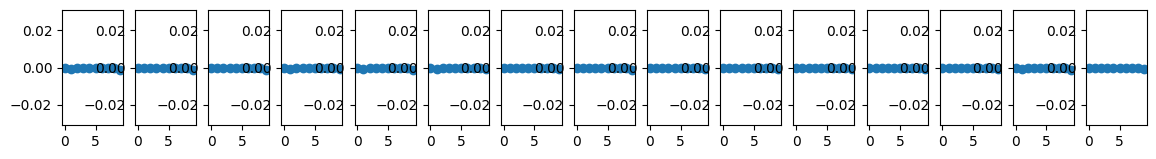

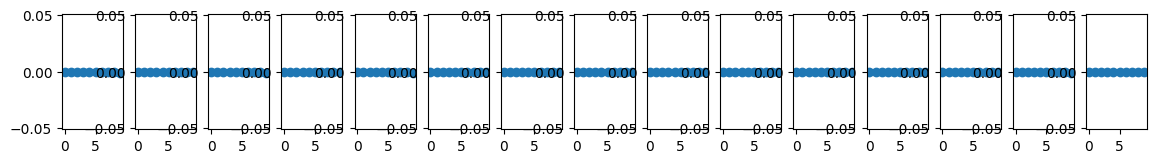

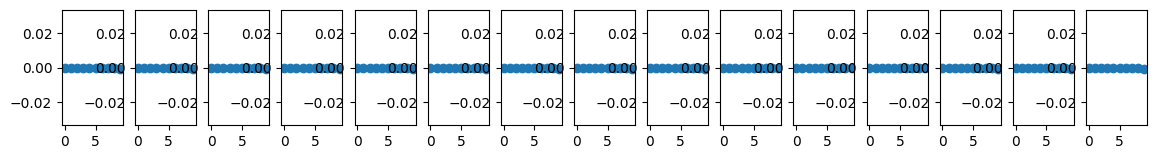

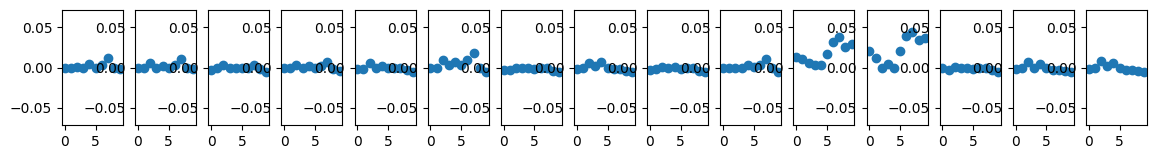

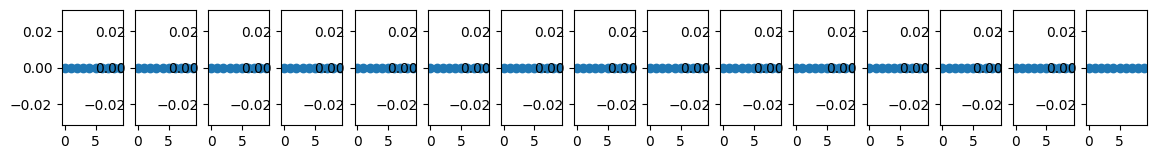

In [64]:
a = np.array(coeffs).reshape(-1, 2, n_port, n_p_bins)
for k in range(0, 5):
    fig, axes = plt.subplots(1, n_port, figsize=(14, 1.5))
    vmax = np.max(np.abs(a[k]))
    for i in range(n_port):
        axes[i].scatter(np.arange(10), a[k,0,i,:])
        axes[i].set_ylim([-vmax, vmax])

In [111]:
print(np.tile(np.arange(0, n_port), 2)[::2])
print(np.arange(0, len(coef), n_p_bins)[::2])

[ 0  2  4  6  8 10 12 14  1  3  5  7  9 11 13]
[  0  20  40  60  80 100 120 140 160 180 200 220 240 260 280]


/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_7978/2623089708.py:23: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(-vlim, vlim)


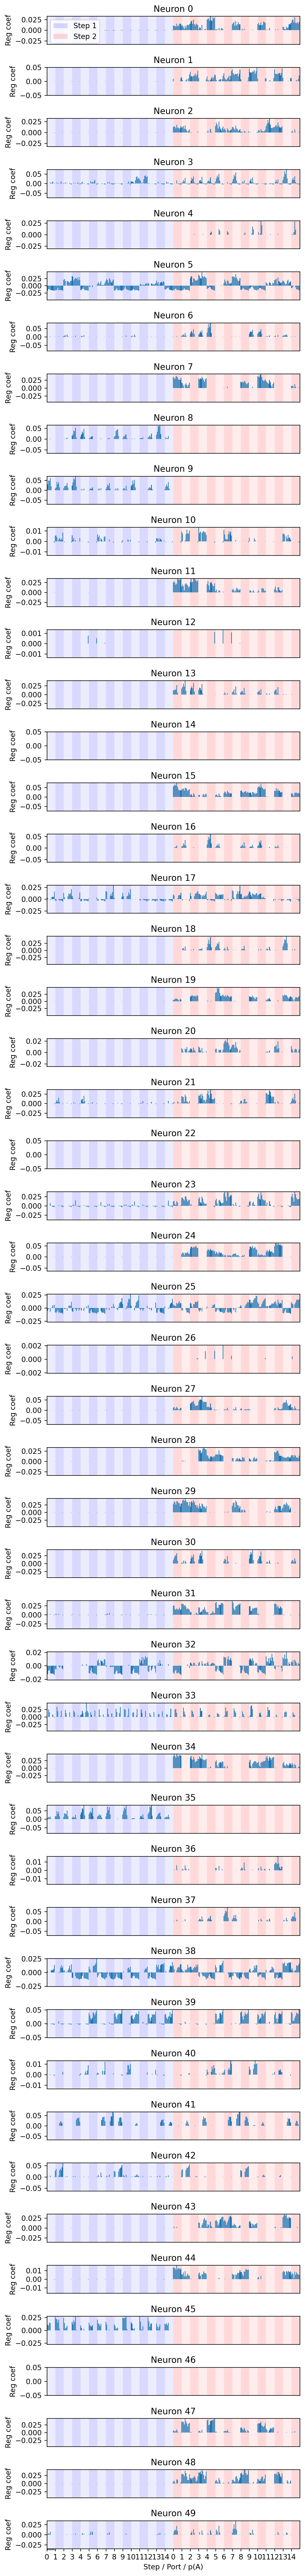

In [32]:
fig, axes = plt.subplots(50,1, figsize=(6,50), dpi=240)

coeffs_ = np.array(coeffs)
for neur_id, (ax, coef) in enumerate(zip(axes, coeffs_)):
    # Add alternating vertical bands every 10
    ax.axvspan(0, len(coef)//2, facecolor='blue', alpha=0.15)
    ax.axvspan(len(coef)//2, len(coef), facecolor='red', alpha=0.15)

    for i in range(0, len(coef), 10):
        if i // 10 % 2 == 0:
            ax.axvspan(i, i+10, facecolor='white', alpha=0.5)
        # else:
            # ax.axvspan(i, i+10, facecolor='white', alpha=0.2)

    # keep_idx = coef != 0
    keep_idx = np.ones_like(coef, dtype=bool)
    # ax.scatter(np.arange(len(coef))[keep_idx], coef[keep_idx], s=3)
    ax.bar(np.arange(len(coef))[keep_idx], coef[keep_idx])
    ax.set_xlim(0, len(coef))
    ax.xaxis.set_visible(False)

    vlim = np.max(np.abs(coef))
    ax.set_ylim(-vlim, vlim)
    ax.set_ylabel('Reg coef')
    ax.set_title(f'Neuron {neur_id}')

axes[-1].xaxis.set_visible(True)
axes[-1].xaxis.set_ticks(np.arange(0, n_p_bins), minor=True)
axes[-1].set_xticks(np.arange(0, len(coef), n_p_bins), np.tile(np.arange(0, n_port), 2))
axes[-1].set_xlabel('Step / Port / p(A)')

# Add legend
axes[0].legend(['Step 1', 'Step 2'], loc='upper left')

plt.tight_layout()

plt.savefig('./regression/reg_coeffs.png')

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_7978/2016921957.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_7978/2016921957.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[port, step].scatter(x_comp[i, dims[0]], i, c=col, s=7, marker='o', label=i)
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_7978/2016921957.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should 

(10, 851)
[0.6856838  0.11107972 0.06339617 0.04769513 0.02506531]
(10, 851)
[0.684349   0.10617308 0.06216586 0.04829366 0.03311639]
(10, 851)
[0.6967612  0.10416947 0.06690694 0.04300248 0.03100245]
(10, 851)
[0.679452   0.10884318 0.06289334 0.04831769 0.0364894 ]
(10, 851)
[0.6718266  0.11112782 0.07057359 0.04707001 0.03900802]
(10, 851)
[0.6842221  0.10679141 0.07292987 0.03903341 0.0352154 ]
(10, 851)
[0.6794952  0.11289115 0.07551933 0.03983364 0.03108446]
(10, 851)
[0.7137753  0.08881798 0.0629627  0.04870657 0.03072481]
(10, 851)
[0.6811413  0.11221259 0.06506363 0.05249033 0.02988543]
(10, 851)
[0.6774389  0.09767585 0.06923983 0.04977496 0.03457529]
(10, 851)
[0.7010297  0.09890705 0.06575798 0.04626085 0.02828152]
(10, 851)
[0.6878814  0.11377561 0.06029505 0.04818311 0.02909769]
(10, 851)
[0.69498384 0.09968784 0.06816725 0.04361667 0.03037236]
(10, 851)
[0.70554715 0.08814698 0.06894625 0.04532708 0.03119445]
(10, 851)
[0.68311036 0.10083161 0.06815377 0.0444888  0.03870

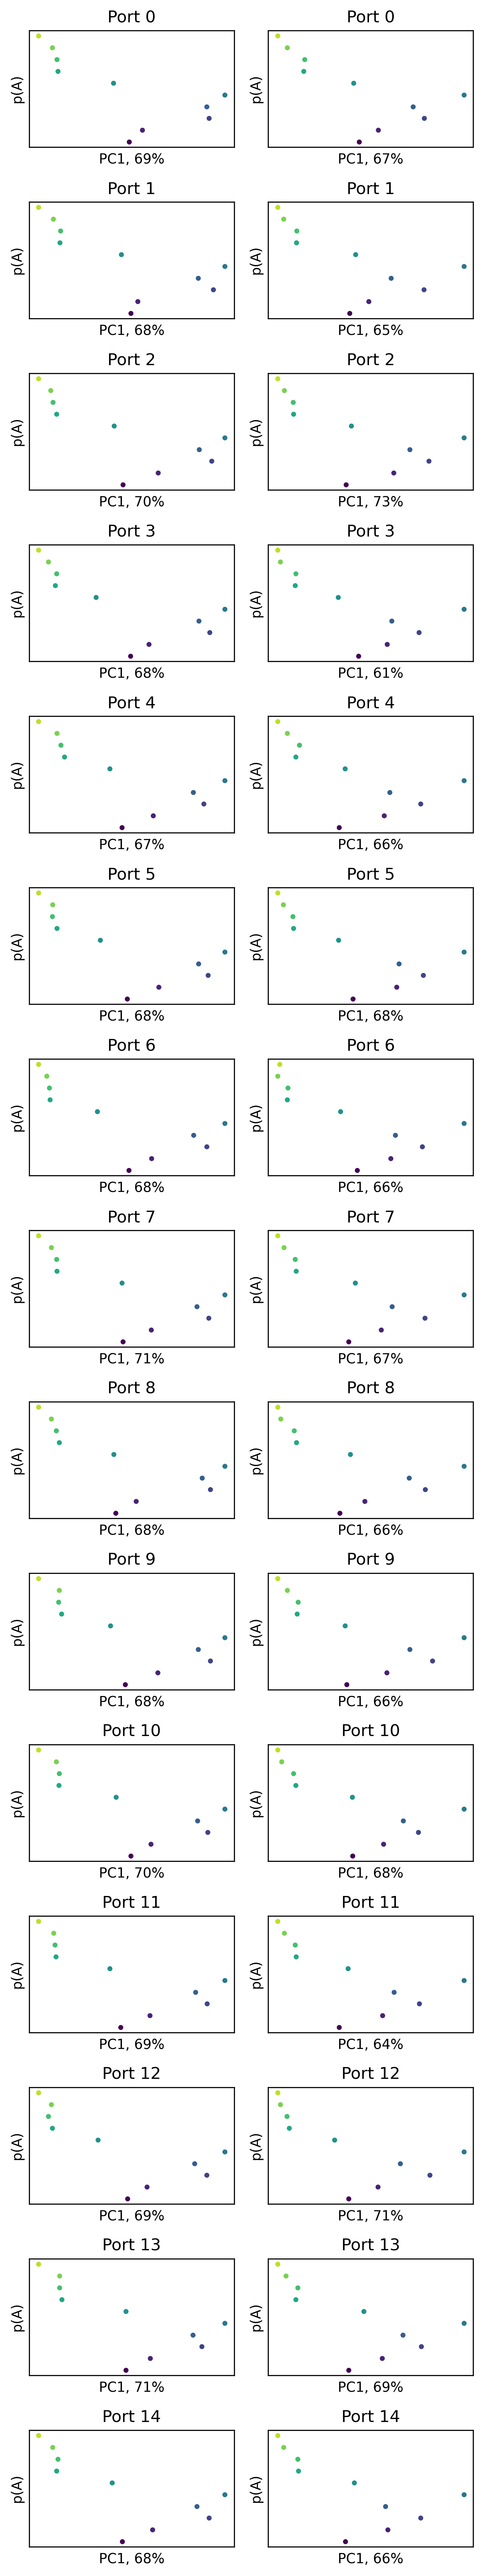

In [37]:
from sklearn.decomposition import PCA

a = np.array(coeffs).reshape(-1, 2, n_port, n_p_bins)

step = 0
port = 0

fig, axes = plt.subplots(n_port, 2, figsize=(5, 14*n_port / 8), dpi=300)
cmap = plt.cm.get_cmap('viridis')

pc1s = np.zeros((2, n_port, a.shape[0]))
pc2s = np.zeros((2, n_port, a.shape[0]))

for step in range(2):
    for port in range(n_port):
        x_pca = a[:, step, port, :].T
        pca = PCA(n_components=5)
        pca.fit(x_pca)
        print(x_pca.shape)
        print(pca.explained_variance_ratio_)

        # action_port = np.argmax(choices[:,:,-Conf.port_dim-1:], axis=-1)
        # a_choice = action_port == layouts[:,0, np.newaxis]
        # b_choice = action_port == layouts[:,1, np.newaxis]
        # null_choice = action_port == 200

        x_comp = pca.transform(x_pca)

        dims = [0]
        if len(dims) > 1:
            for i in range(n_p_bins):
                col = cmap(i / n_p_bins)
                axes[port, step].scatter(x_comp[i, dims[0]], x_comp[i, dims[1]], c=col, s=7, marker='o', label=i)
            axes[port, step].set_ylabel(f'PC{dims[1]+1}, {100*pca.explained_variance_ratio_[dims[1]]:.0f}%')
        else:
            for i in range(n_p_bins):
                col = cmap(i / n_p_bins)
                axes[port, step].scatter(x_comp[i, dims[0]], i, c=col, s=7, marker='o', label=i)
            axes[port, step].set_ylabel(f'p(A)')

        
        axes[port, step].set_title(f'Port {port}')
        axes[port, step].set_xlabel(f'PC{dims[0]+1}, {100*pca.explained_variance_ratio_[dims[0]]:.0f}%')
        axes[port, step].set_xticks([])
        axes[port, step].set_yticks([])
        # axes[port, step].legend()
        
        pc1s[step, port] = pca.components_[0]
        pc2s[step, port] = pca.components_[1]

plt.tight_layout()
# X_comp = np.reshape(X_comp, (hiddens.shape[0], hiddens.shape[1], -1))

os.makedirs('./regression/', exist_ok=True)
plt.savefig('./regression/pca2_prob.png', dpi=300)

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_1886/336904523.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[0, port1] = similarity
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_1886/336904523.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[0, port1] = similarity
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_1886/336904523.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[0, 

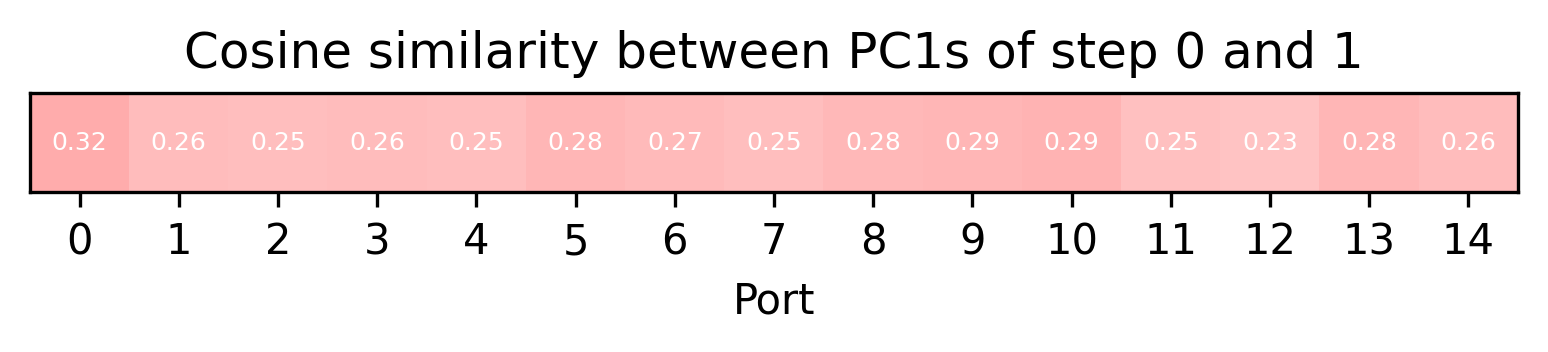

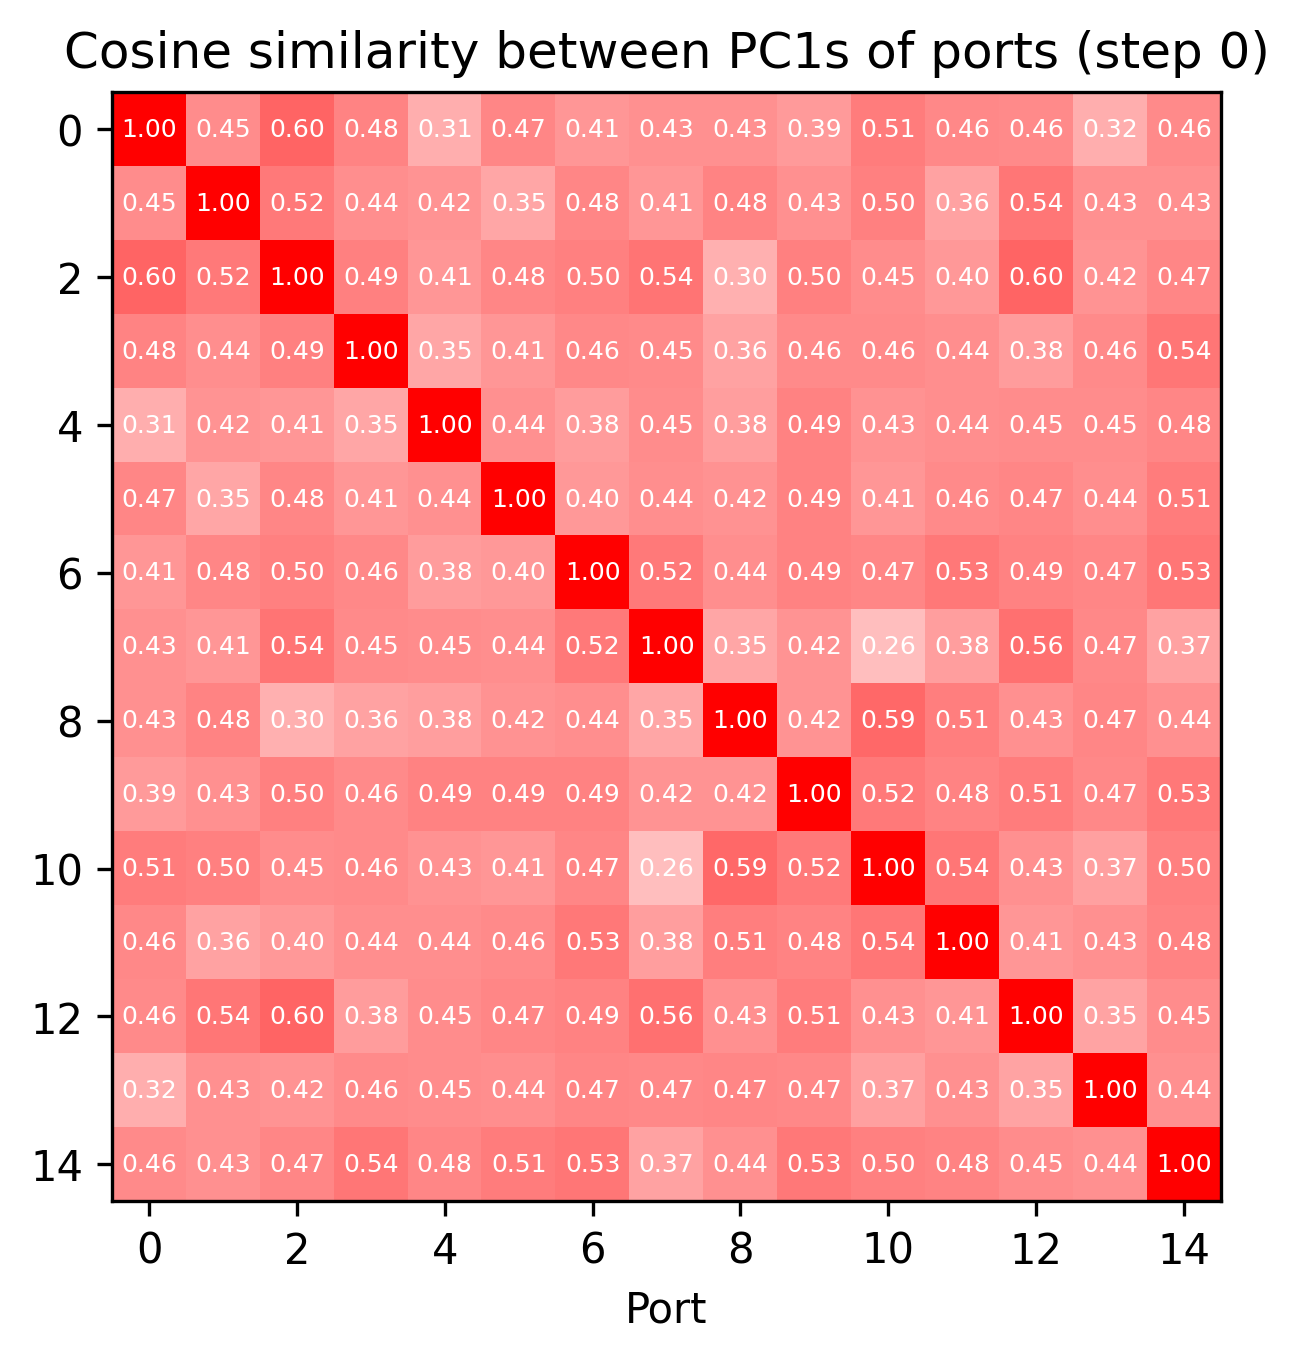

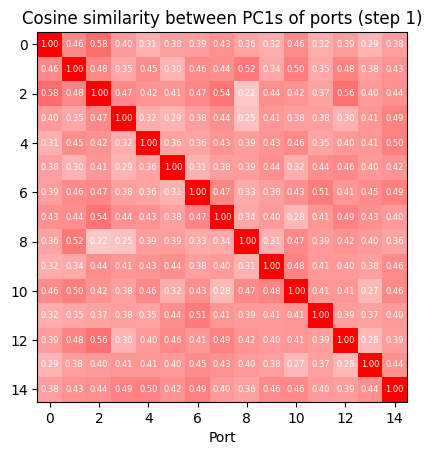

In [122]:
from sklearn.metrics.pairwise import cosine_similarity

plt.figure(dpi=300)
similarities = np.zeros((1, n_port))
# Reshape the vectors to be 2D arrays
for port1 in range(n_port):
    vector1 = pc1s[0, port1, :].reshape(1, -1)
    vector2 = pc1s[1, port1, :].reshape(1, -1)
    # Calculate the cosine similarity
    similarity = cosine_similarity(vector1, vector2)
    similarities[0, port1] = similarity

plt.imshow(similarities, vmin=-1, vmax=1, cmap='bwr')
plt.title('Cosine similarity between PC1s of step 0 and 1')
plt.xlabel('Port')
plt.xticks(np.arange(n_port), np.arange(n_port))
plt.yticks([])

# Add values as text annotations
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', color='white', size=6)

plt.savefig('./regression/pc1_sim_step01.png', dpi=300)

plt.figure(dpi=300)
similarities = np.zeros((n_port, n_port))
# Reshape the vectors to be 2D arrays
for port1 in range(n_port):
    vector1 = pc1s[0, port1, :].reshape(1, -1)
    for port2 in range(n_port):
        vector2 = pc1s[0, port2, :].reshape(1, -1)
        # Calculate the cosine similarity
        similarity = cosine_similarity(vector1, vector2)

        similarities[port1, port2] = similarity

plt.title('Cosine similarity between PC1s of ports (step 0)')
plt.xlabel('Port')
plt.xlabel('Port')
plt.imshow(similarities, vmin=-1, vmax=1, cmap='bwr')

# Add values as text annotations
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', color='white', size=6)

plt.savefig('./regression/pc1_sim_step0.png', dpi=300)

plt.figure()
similarities = np.zeros((n_port, n_port))
# Reshape the vectors to be 2D arrays
for port1 in range(n_port):
    vector1 = pc1s[1, port1, :].reshape(1, -1)
    for port2 in range(n_port):
        vector2 = pc1s[1, port2, :].reshape(1, -1)
        # Calculate the cosine similarity
        similarity = cosine_similarity(vector1, vector2)

        similarities[port1, port2] = similarity

plt.title('Cosine similarity between PC1s of ports (step 1)')
plt.xlabel('Port')
plt.xlabel('Port')
plt.imshow(similarities, vmin=-1, vmax=1, cmap='bwr')

# Add values as text annotations
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', color='white', size=6)

plt.savefig('./regression/pc1_sim_step1.png', dpi=300)



/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_1886/570792953.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[0, port1] = similarity
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_1886/570792953.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[0, port1] = similarity
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_1886/570792953.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[0, por

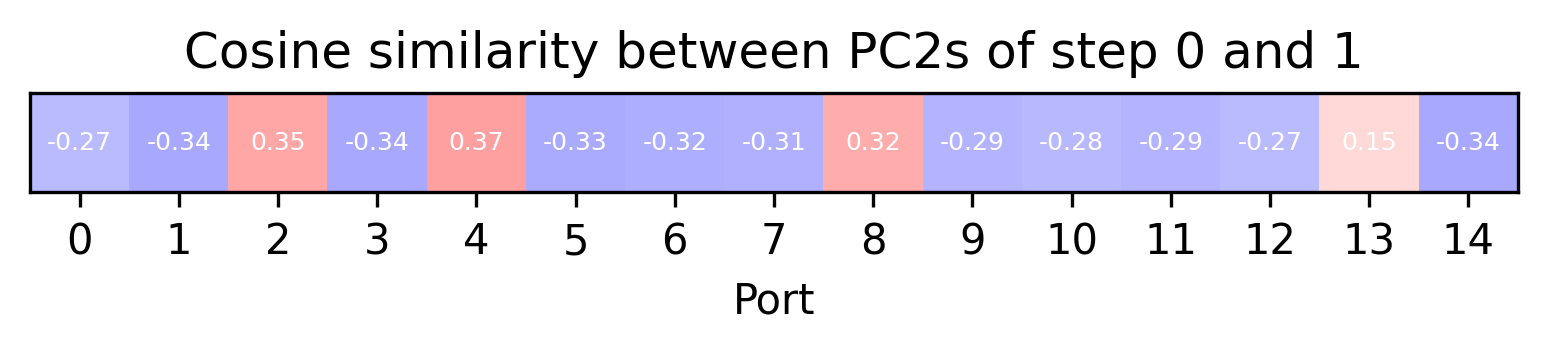

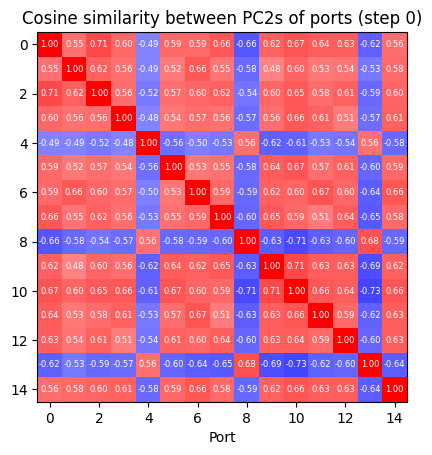

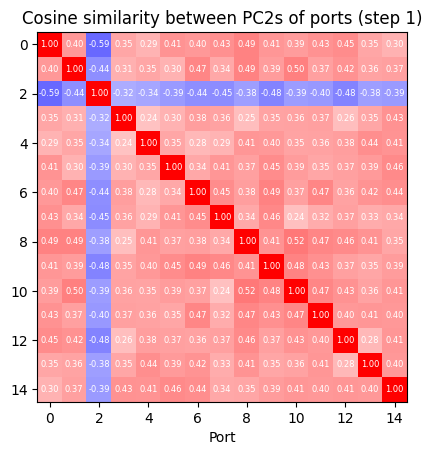

In [123]:
plt.figure(dpi=300)
similarities = np.zeros((1, n_port))
# Reshape the vectors to be 2D arrays
for port1 in range(n_port):
    vector1 = pc2s[0, port1, :].reshape(1, -1)
    vector2 = pc2s[1, port1, :].reshape(1, -1)
    # Calculate the cosine similarity
    similarity = cosine_similarity(vector1, vector2)
    similarities[0, port1] = similarity

plt.imshow(similarities, vmin=-1, vmax=1, cmap='bwr')
plt.title('Cosine similarity between PC2s of step 0 and 1')
plt.xlabel('Port')
plt.xticks(np.arange(n_port), np.arange(n_port))
plt.yticks([])

# Add values as text annotations
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', color='white', size=6)

plt.savefig('./regression/pc2_sim_step01.png', dpi=300)

plt.figure()
similarities = np.zeros((n_port, n_port))
# Reshape the vectors to be 2D arrays
for port1 in range(n_port):
    vector1 = pc2s[0, port1, :].reshape(1, -1)
    for port2 in range(n_port):
        vector2 = pc2s[0, port2, :].reshape(1, -1)
        # Calculate the cosine similarity
        similarity = cosine_similarity(vector1, vector2)

        similarities[port1, port2] = similarity

plt.title('Cosine similarity between PC2s of ports (step 0)')
plt.xlabel('Port')
plt.xlabel('Port')
plt.imshow(similarities, vmin=-1, vmax=1, cmap='bwr')

# Add values as text annotations
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', color='white', size=6)

plt.savefig('./regression/pc2_sim_step0.png', dpi=300)

plt.figure()
similarities = np.zeros((n_port, n_port))
# Reshape the vectors to be 2D arrays
for port1 in range(n_port):
    vector1 = pc2s[1, port1, :].reshape(1, -1)
    for port2 in range(n_port):
        vector2 = pc2s[1, port2, :].reshape(1, -1)
        # Calculate the cosine similarity
        similarity = cosine_similarity(vector1, vector2)

        similarities[port1, port2] = similarity

plt.title('Cosine similarity between PC2s of ports (step 1)')
plt.xlabel('Port')
plt.xlabel('Port')
plt.imshow(similarities, vmin=-1, vmax=1, cmap='bwr')

# Add values as text annotations
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', color='white', size=6)

plt.savefig('./regression/pc2_sim_step1.png', dpi=300)

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_8281/3530597251.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_8281/3530597251.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_comp[i, 0], x_comp[i, 1], c=color)


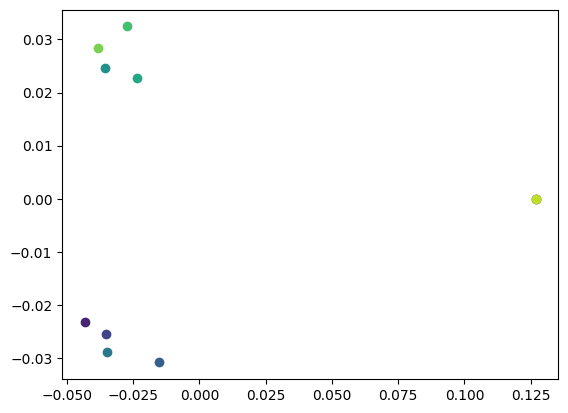

In [154]:
cmap = plt.cm.get_cmap('viridis')
for i in range(10):
    color = cmap(i / 10)
    plt.scatter(x_comp[i, 0], x_comp[i, 1], c=color)

In [78]:
np.arccos(0.56) * 180 / np.pi

55.94420225743209